In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from astropy.table import Table, join, QTable, vstack
import astropy.units as u
import sys
import pyneb as pn
from multiprocessing import Pool
import multiprocessing as mp
import math
from astropy.io import fits
from orcs.process import SpectralCube

from astropy.nddata import NDData, Cutout2D
from astropy.wcs import WCS

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel

from reproject import reproject_interp
import reproject
from regions import PixCoord

import pylab as pl

from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.interpolate import griddata

from orb.fit import fit_lines_in_spectrum
from orb.utils.spectrum import corr2theta, amp_ratio_from_flux_ratio
from orb.core import Lines
import gvar
import orb

import extinction
from extinction import apply, remove

from photutils.detection import DAOStarFinder

import aplpy
import seaborn as sns

from skimage import filters

import statsmodels.api as sm
from scipy.stats import spearmanr

import sys
sys.path.append("/home/habjan/SITELLE/sitelle_metallicities")
import analysis_functions as af

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### Import data

In [3]:
products_data_path = '/home/habjan/SITELLE/data/data_products'
inter_data_path = '/home/habjan/SITELLE/data/data_raw_intermediate'

sit_0628 = fits.open(products_data_path + f"/NGC0628_SITELLE.fits")
OII_0628_mp = fits.open(products_data_path + f"/NGC0628_OII_map_mp.fits")[0]
OII_0628 = fits.open(products_data_path + f"/NGC0628_OII_map.fits")[0]
mask_0628 = fits.open(inter_data_path + f"/NGC0628_nebulae_mask_V2.fits")[0]
infile = open(inter_data_path + f'/NGC0628_physdata_MUSE+SITELLE.fits','rb')
data_0628 = Table.read(infile)
infile = inter_data_path + f"/NGC0628_cube.hdf5"
cube_0628 = SpectralCube(infile)
sit_0628_mp = fits.open(products_data_path + f"/NGC0628_SITELLE_mp.fits")

sit_2835 = fits.open(products_data_path + f"/NGC2835_SITELLE.fits")
#OII_2835_mp = fits.open(f"/NGC2835_OII_map_mp.fits")[0]
OII_2835 = fits.open(products_data_path + f"/NGC2835_OII_map.fits")[0]
mask_2835 = fits.open(inter_data_path + f"/NGC2835_nebulae_mask_V2.fits")[0]
infile = open(inter_data_path + f'/NGC2835_physdata_MUSE+SITELLE.fits','rb')
data_2835 = Table.read(infile)
infile = inter_data_path + f"/NGC2835_cube.hdf5"
cube_2835 = SpectralCube(infile)

sit_3351 = fits.open(products_data_path + f"/NGC3351_SITELLE.fits")
#OII_3351_mp = fits.open(f"/NGC3351_OII_map_mp.fits")[0]
OII_3351 = fits.open(products_data_path + f"/NGC3351_OII_map.fits")[0]
mask_3351 = fits.open(inter_data_path + f"/NGC3351_nebulae_mask_V2.fits")[0]
infile = open(inter_data_path + f'/NGC3351_physdata_MUSE+SITELLE.fits','rb')
data_3351 = Table.read(infile)
infile = inter_data_path + f"/NGC3351_cube.hdf5"
cube_3351 = SpectralCube(infile)

sit_4535 = fits.open(products_data_path + f"/NGC4535_SITELLE.fits")
#OII_4535_mp = fits.open(f"/NGC4535_OII_map_mp.fits")[0]
OII_4535 = fits.open(products_data_path + f"/NGC4535_OII_map.fits")[0]
mask_4535 = fits.open(inter_data_path + f"/NGC4535_nebulae_mask_V2.fits")[0]
infile = open(inter_data_path + f'/NGC4535_physdata_MUSE+SITELLE.fits','rb')
data_4535 = Table.read(infile)
infile = inter_data_path + f"/NGC4535_cube.hdf5"
cube_4535 = SpectralCube(infile)

sit_3627 = fits.open(products_data_path + f"/NGC3627_SITELLE.fits")
#OII_4535_mp = fits.open(f"/NGC4535_OII_map_mp.fits")[0]
#OII_3627 = fits.open(f"/NGC3627_OII_map.fits")[0]
mask_3627 = fits.open(inter_data_path + f"/NGC3627_nebulae_mask_V2.fits")[0]
infile = open(inter_data_path + f'/NGC3627_physdata_MUSE+SITELLE.fits','rb')
data_3627 = Table.read(infile)
infile = inter_data_path + f"/NGC3627_cube.hdf5"
cube_3627 = SpectralCube(infile)

table_dic = {1: data_0628, 2:data_2835, 3:data_3351, 4:data_4535, 5:data_3627}

old cube architecture (level 1). IO performances could be reduced.
Cube is level 1
shape: (2048, 2064, 105)
wavenumber calibration: True
flux calibration: True
wcs calibration: False
old cube architecture (level 1). IO performances could be reduced.
Cube is level 1
shape: (2048, 2064, 223)
wavenumber calibration: True
flux calibration: True
wcs calibration: False
old cube architecture (level 1). IO performances could be reduced.
Cube is level 1
shape: (2048, 2064, 171)
wavenumber calibration: True
flux calibration: True
wcs calibration: False
old cube architecture (level 1). IO performances could be reduced.
Cube is level 1
shape: (2048, 2064, 222)
wavenumber calibration: True
flux calibration: True
wcs calibration: False
old cube architecture (level 1). IO performances could be reduced.
Cube is level 1
shape: (2048, 2064, 128)
wavenumber calibration: True
flux calibration: True
wcs calibration: False


### Make SITELLE deep frames

In [4]:
sit_deep_0628 = fits.PrimaryHDU(data=np.transpose(cube_0628.get_deep_frame().data), header=OII_0628.header)
sit_deep_2835 = fits.PrimaryHDU(data=np.transpose(cube_2835.get_deep_frame().data), header=OII_2835.header)
sit_deep_3351 = fits.PrimaryHDU(data=np.transpose(cube_3351.get_deep_frame().data), header=OII_3351.header)
sit_deep_4535 = fits.PrimaryHDU(data=np.transpose(cube_4535.get_deep_frame().data), header=OII_4535.header)
sit_deep_3627 = fits.PrimaryHDU(data=np.transpose(cube_3627.get_deep_frame().data), header=WCS(cube_3627.get_header(), naxis=2).to_header())

In [5]:
trunc = 4

deep_ind = np.where((sit_0628[1].data < 1/(10**-8 * 3650)) & (sit_0628[1].data > 1/(10**-8 * 3850)))[0]
deep_arr = np.nansum(sit_0628[0].data[deep_ind], axis=0)
smoothed_0628 = filters.gaussian(deep_arr, sigma=1, truncate=trunc, preserve_range=False)
sit_deep_0628 = fits.PrimaryHDU(data=smoothed_0628, header=OII_0628.header)

deep_ind = np.where((sit_2835[1].data < 1/(10**-8 * 3650)) & (sit_2835[1].data > 1/(10**-8 * 3850)))[0]
deep_arr = np.nansum(sit_2835[0].data[deep_ind], axis=0)
smoothed_2835 = filters.gaussian(deep_arr, sigma=2, truncate=trunc, preserve_range=False)
sit_deep_2835 = fits.PrimaryHDU(data=smoothed_2835, header=OII_2835.header)

deep_ind = np.where((sit_3351[1].data < 1/(10**-8 * 3650)) & (sit_3351[1].data > 1/(10**-8 * 3850)))[0]
deep_arr = np.nansum(sit_3351[0].data[deep_ind], axis=0)
smoothed_3351 = filters.gaussian(deep_arr, sigma=2, truncate=trunc, preserve_range=False)
sit_deep_3351 = fits.PrimaryHDU(data=smoothed_3351, header=OII_3351.header)

deep_ind = np.where((sit_4535[1].data < 1/(10**-8 * 3650)) & (sit_4535[1].data > 1/(10**-8 * 3850)))[0]
deep_arr = np.nansum(sit_4535[0].data[deep_ind], axis=0)
smoothed_4535 = filters.gaussian(deep_arr, sigma=3, truncate=trunc, preserve_range=False)
sit_deep_4535 = fits.PrimaryHDU(data=smoothed_4535, header=OII_4535.header)

### Plot all four SITELLE cubes in a single plot, to take up ~1 page in the paper

Text(0.05, -0.35, 'Dec')

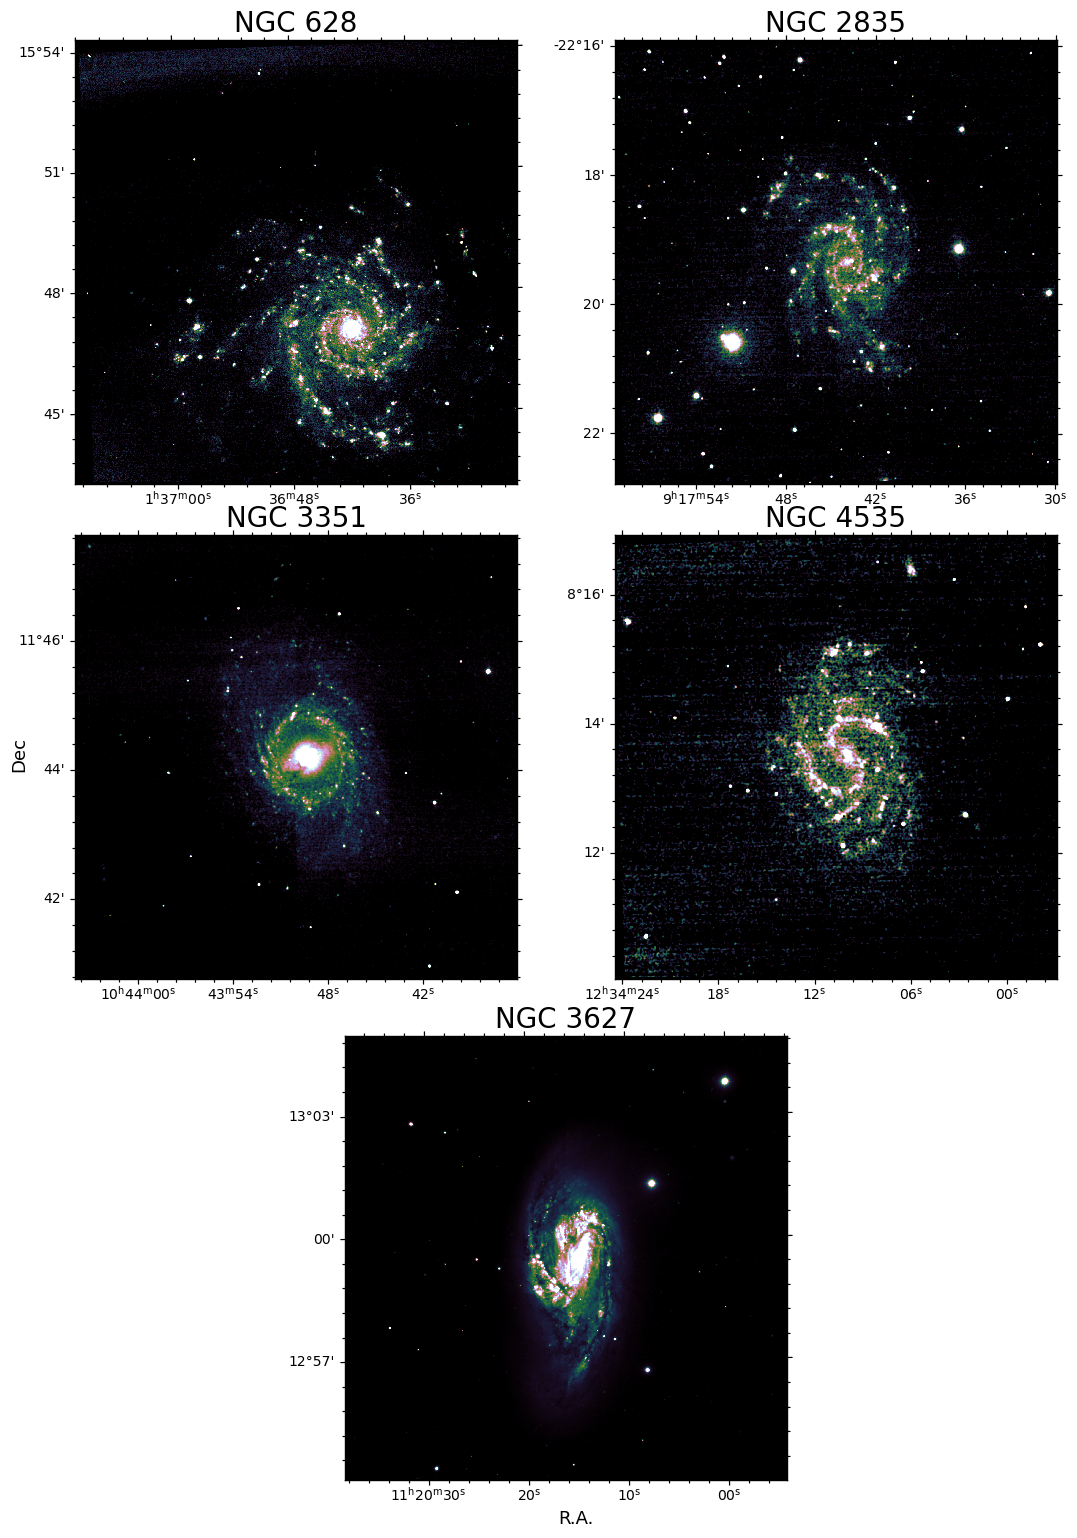

In [6]:
fig = plt.figure(figsize=(13, 6))
cmap = 'cubehelix'

up = 0.9955
low = 0.7

dx = 0.34
dy = 0.74

fs = 20

f1 = aplpy.FITSFigure(sit_deep_0628, figure=fig, subplot=[0.1,0.1, dx, dy])
#f1.recenter(coord_dic['NGC0628'][0], coord_dic['NGC0628'][1], width=zoom_dic['NGC0628'][0], height=zoom_dic['NGC0628'][0])
f1.show_colorscale(cmap=cmap, vmin=np.quantile(sit_deep_0628.data, low), vmax=np.quantile(sit_deep_0628.data, up))
f1.set_title('NGC 628', fontsize = fs)
f1.axis_labels.hide_x()
f1.axis_labels.hide_y()

#f1 = aplpy.FITSFigure(sit_deep_0628, figure=fig, subplot=[0.1,0.1, dx, dy])
#f1.recenter(coord_dic['NGC0628'][0], coord_dic['NGC0628'][1], width=zoom_dic['NGC0628'][0], height=zoom_dic['NGC0628'][0])
#f1.show_colorscale(cmap=cmap, vmin=np.quantile(sit_deep_0628.data, low), vmax=np.quantile(sit_deep_0628.data, up))
#f1.set_title('NGC 628')
#f1.axis_labels.hide_x()
#f1.axis_labels.hide_y()

f2 = aplpy.FITSFigure(sit_deep_2835, figure=fig, subplot=[0.515,0.1,dx,dy])
#f2.recenter(coord_dic['NGC2835'][0], coord_dic['NGC2835'][1], width=zoom_dic['NGC2835'][0], height=zoom_dic['NGC2835'][0])
f2.show_colorscale(cmap=cmap, vmin=np.quantile(sit_deep_2835.data, low), vmax=np.quantile(sit_deep_2835.data, up))
f2.set_title('NGC 2835', fontsize = fs)
f2.axis_labels.hide_x()
f2.axis_labels.hide_y()

f3 = aplpy.FITSFigure(sit_deep_3351, figure=fig, subplot=[0.1,-0.725,dx,dy])
#f3.recenter(coord_dic['NGC3351'][0], coord_dic['NGC3351'][1], width=zoom_dic['NGC3351'][0], height=zoom_dic['NGC3351'][0])
f3.show_colorscale(cmap=cmap, vmin=np.quantile(sit_deep_3351.data, low), vmax=np.quantile(sit_deep_3351.data, up+0.002))
f3.set_title('NGC 3351', fontsize = fs)
f3.axis_labels.hide_x()
f3.axis_labels.hide_y()

f4 = aplpy.FITSFigure(sit_deep_4535, figure=fig, subplot=[0.515, -0.725,dx,dy])
#f4.recenter(coord_dic['NGC4535'][0], coord_dic['NGC4535'][1], width=zoom_dic['NGC4535'][0], height=zoom_dic['NGC4535'][0])
f4.show_colorscale(cmap=cmap, vmin=np.quantile(sit_deep_4535.data, low), vmax=np.quantile(sit_deep_4535.data, up))
f4.set_title('NGC 4535', fontsize = fs)
f4.axis_labels.hide_x()
f4.axis_labels.hide_y()

f4 = aplpy.FITSFigure(sit_deep_3627, figure=fig, subplot=[0.3075, -1.56, dx,dy])
#f4.recenter(coord_dic['NGC4535'][0], coord_dic['NGC4535'][1], width=zoom_dic['NGC4535'][0], height=zoom_dic['NGC4535'][0])
f4.show_colorscale(cmap=cmap, vmin=np.quantile(sit_deep_3627.data, low), vmax=np.quantile(sit_deep_3627.data, up))
f4.set_title('NGC 3627', fontsize = fs)
f4.axis_labels.hide_x()
f4.axis_labels.hide_y()

#fig.suptitle('ORCS Deep Frame', fontsize=20)
fig.supxlabel('R.A.', x =0.485, y=-1.64, fontsize=13)
fig.supylabel('Dec', x =0.05, y=-0.35, fontsize=13)

### Make array of high SNR velocity values and then interpolate this map using nearest neighbors

In [7]:
snr = 5
high_vel_ind = np.where(data_0628['OII3727_FLUX_CORR'] / data_0628['OII3727_FLUX_CORR_ERR'] > snr)[0]

vel_mask = np.zeros(mask_0628.data.shape)
for i in high_vel_ind:
    vel_mask[mask_0628.data == i] = data_0628['OII3727_VEL'][i]

x, y = np.where(vel_mask != 0)
x_grid, y_grid = np.meshgrid(np.arange(vel_mask.shape[0]), np.arange(vel_mask.shape[1]))
vel_smoothed = griddata(points = (x, y), values = vel_mask[np.where(vel_mask != 0)], xi=(x_grid, y_grid), method='nearest')
vel_map_0628 = fits.PrimaryHDU(data=vel_smoothed, header=mask_0628.header)

### Plot the regular velocity map

Text(0.5, 1.0, 'NGC 628 Velocity Plot')

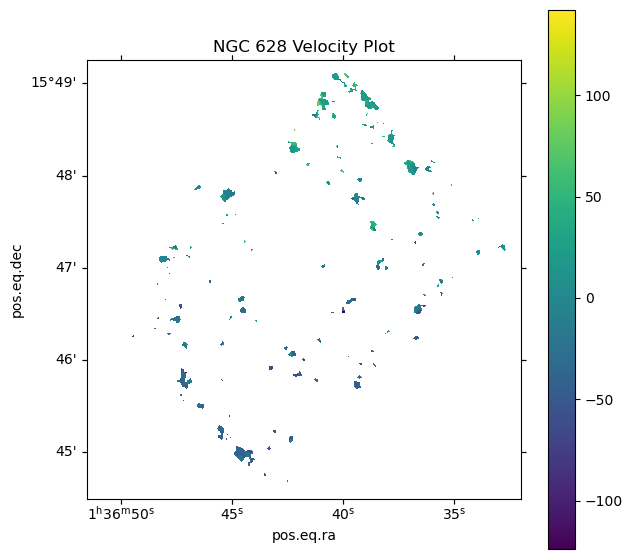

In [8]:
nan_vel = np.copy(vel_mask)
nan_vel[nan_vel == 0] = np.nan 

fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111, projection=WCS(vel_map_0628.header))

im = ax.imshow(nan_vel, vmin=np.nanquantile(nan_vel, 0), vmax=np.nanquantile(nan_vel, 1))

cbar = plt.colorbar(im, ax=ax)

plt.title('NGC 628 Velocity Plot')

### Plot the smoothed velocity map

Text(0.5, 1.0, 'NGC 628 Smoothed Velocity Plot')

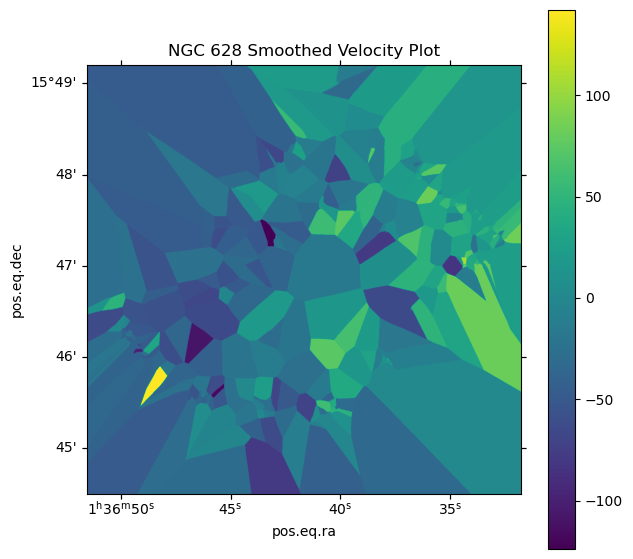

In [9]:
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111, projection=WCS(vel_map_0628.header))

im = ax.imshow(vel_map_0628.data, vmin=np.nanquantile(vel_map_0628.data, 0), vmax=np.nanquantile(vel_map_0628.data, 1))

cbar = plt.colorbar(im, ax=ax)

plt.title('NGC 628 Smoothed Velocity Plot')

### Use the smoothed velocity map to make a smoothed OII map

In [10]:
wave3729 = 3728.815
c = 299792
galvel = 651

up_down = 15

test = fits.open(inter_data_path + f"/NGC0628_SITELLE_mp.fits")

### Go from Velocities to wavenumber
red3729 = 1/((wave3729*(vel_map_0628.data+galvel)/(c) + wave3729) * 10**-8)
### Make a 3d boolean above and below the peak of [OII]3727
wave_bool = (red3729 + up_down > sit_0628[1].data[:, None, None]) & (red3729 - up_down < sit_0628[1].data[:, None, None])
### make a masked array of where [OII]3727 is at each point in the cube
#cube_masked = np.ma.masked_array(sit_0628_mp[0].data, ~wave_bool)
cube_masked = np.ma.masked_array(test[0].data, ~wave_bool)
### sum over all wavelength channels
oii_map_sum = np.nansum(cube_masked, axis=0)
### Smooth the OII map 
oii_smoothed = filters.gaussian(oii_map_sum, sigma=1.5)
### Save as a fits file
oii_map = fits.PrimaryHDU(data=oii_smoothed, header=mask_0628.header)

### Plot the OII map in imshow

Text(0.5, 1.0, 'NGC 628 Smoothed OII map')

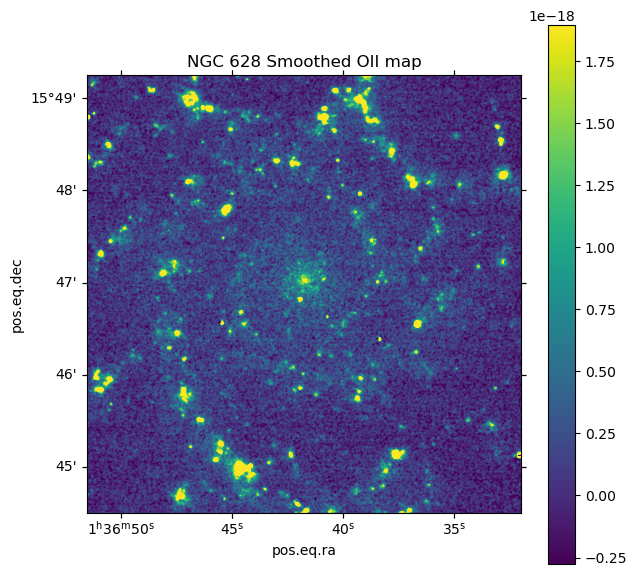

In [11]:
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111, projection=WCS(mask_0628.header))

im = ax.imshow(oii_map.data, vmin=np.nanquantile(oii_map.data, 0.01), vmax=np.nanquantile(oii_map.data, 0.99))

cbar = plt.colorbar(im, ax=ax)

plt.title('NGC 628 Smoothed OII map')

### Plot OII map with HII region mask overlaid

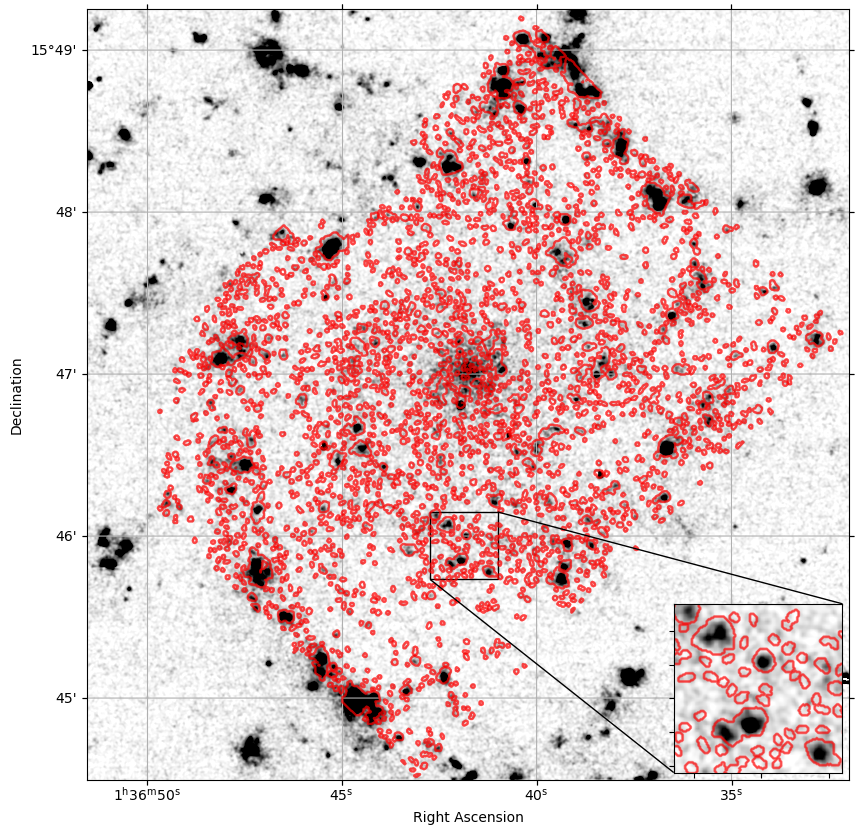

In [12]:
#reg1, reg2 = 184, 311

hii_mask = np.copy(mask_0628.data)
#hii_mask[hii_mask == reg1] = 10**4
#hii_mask[hii_mask == reg2] = 10**4
#hii_mask[hii_mask < 10**3.9] = -1

hii_mask[hii_mask > 0] = 10**4

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection=WCS(mask_0628.header))

ax.imshow(oii_map.data, cmap='Greys', vmin=np.nanquantile(oii_map.data, 0.1), vmax=np.nanquantile(oii_map.data, 0.985))
ax.contour(hii_mask, colors='red', alpha=0.17)
ax.update({'xlabel': 'Right Ascension', 'ylabel': 'Declination'})
ax.grid(False)

axins = zoomed_inset_axes(ax, 2.5, loc=4)
axins.imshow(oii_map.data, cmap='Greys', vmin=np.nanquantile(oii_map.data, 0.1), vmax=np.nanquantile(oii_map.data, 0.985))
axins.contour(hii_mask, colors='red', alpha=0.17)

lim_dic = {'NGC4535':[475, 575, 750, 850], 'NGC3351':[325, 450, 735, 860], 'NGC2835':[600, 700, 275, 375] ,'NGC0628':[635, 760, 370, 495]}

galaxy = 'NGC0628'

axins.set_xlim(lim_dic[galaxy][0], lim_dic[galaxy][1])
axins.set_ylim(lim_dic[galaxy][2], lim_dic[galaxy][3])

plt.xticks(visible=False)
plt.yticks(visible=False)
plt.grid(False)
mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="0.0")
plt.draw()
plt.show()

# Physical Quantity plots

### Import strong line table

In [13]:
infile = open(products_data_path + f'/strong_line_MUSE+SITELLE.fits','rb')
strong_data = Table.read(infile)

galdic = {1:'NGC4254', 6:'NGC3627', 5:'NGC4535', 4:'NGC3351', 3:'NGC2835', 2:'NGC0628'}

### Function to find Spearman rank correlation coefficient and MC uncertainty

In [14]:
def spear_func(in_x, in_y, in_x_err, in_y_err):
    spear = spearmanr(in_x, in_y)[0]
    spear_err = []
    for mc in range(10**3):
        try:
            spear_err.append(spearmanr(np.random.normal(in_x, in_x_err), np.random.normal(in_y, in_y_err))[0])
        except:
            continue
    return spear, np.nanstd(spear_err)

### Function to find WLS and MC uncertainty

In [15]:
def WLS_func(in_x, in_y, in_x_err, in_y_err):

    weights = 1.0 / in_y_err**2
    X = sm.add_constant(in_x)
    model = sm.WLS(in_y, X, weights=weights)
    results = model.fit()
    WLS_coef, WLS_slope = results.params[0], results.params[1]
    mc_vals = np.array([sm.WLS(np.random.normal(in_y, in_y_err), sm.add_constant(np.random.normal(in_x, in_x_err)), weights=weights).fit().params for mc in range(10**3)])

    return WLS_coef, WLS_slope, np.nanstd(mc_vals[:, 0]), np.nanstd(mc_vals[:, 1])

### Functtion for MC uncertainty

In [16]:
def quick_mc_err(quantity, quantity_err, iters):
    err_arr = np.array([np.random.normal(quantity, quantity_err) for mc in range(iters)])
    return np.nanstd(err_arr)

### Histogram of differences in density

/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


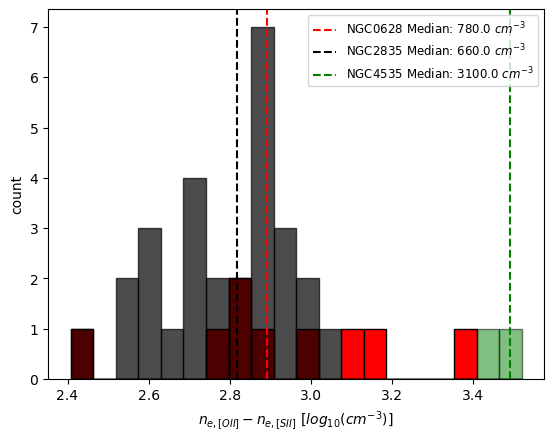

In [17]:
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}

plot_ind = np.where(~np.isnan(strong_data['OII_DEN'] - strong_data['SII_DEN']))[0]

a=np.random.random(100)*0.5 #a uniform distribution
b=1-np.random.normal(size=100)*0.1 #a normal distribution 
bins=np.histogram(np.log10(strong_data['OII_DEN'][plot_ind] - strong_data['SII_DEN'][plot_ind]), bins=20)[1]

a_v = np.array([1, 0.7, 0.6, 0.5, 0.3])

for i in range(2, len(galdic)+1):
    plot_bool = np.where((strong_data['gal_name'] == galdic[i]) & (strong_data['OII_DEN']/strong_data['OII_DEN_ERR'] > 1) & (strong_data['SII_DEN']/strong_data['SII_DEN_ERR'] > 0.5))[0]
    plt.hist(np.log10(strong_data['OII_DEN'] - strong_data['SII_DEN'])[plot_bool], color=colordic[i - 1], bins=bins, alpha=a_v[i-2], edgecolor = 'k')

    if len(np.log10(strong_data['OII_DEN'] - strong_data['SII_DEN'])[plot_bool]) > 0:

        med = np.round(np.nanmedian(np.log10(strong_data['OII_DEN'] - strong_data['SII_DEN'])[plot_bool]), decimals=3)
        gal = strong_data['gal_name'][plot_bool][0]
        plt.axvline(med, c=colordic[i - 1], linestyle='--', label=f'{gal} Median: {np.round(10**med, decimals=-1)}'r' $cm^{-3}$')

plt.xlabel(r'$n_{e, [OII]} - n_{e, [SII]}$ [$log_{10}(cm^{-3})$]')
plt.ylabel(r'count')

plt.legend(fontsize=8.5)

### Plot O+ abundances against O+(T([NII]), n([OII]), [OII]3727)

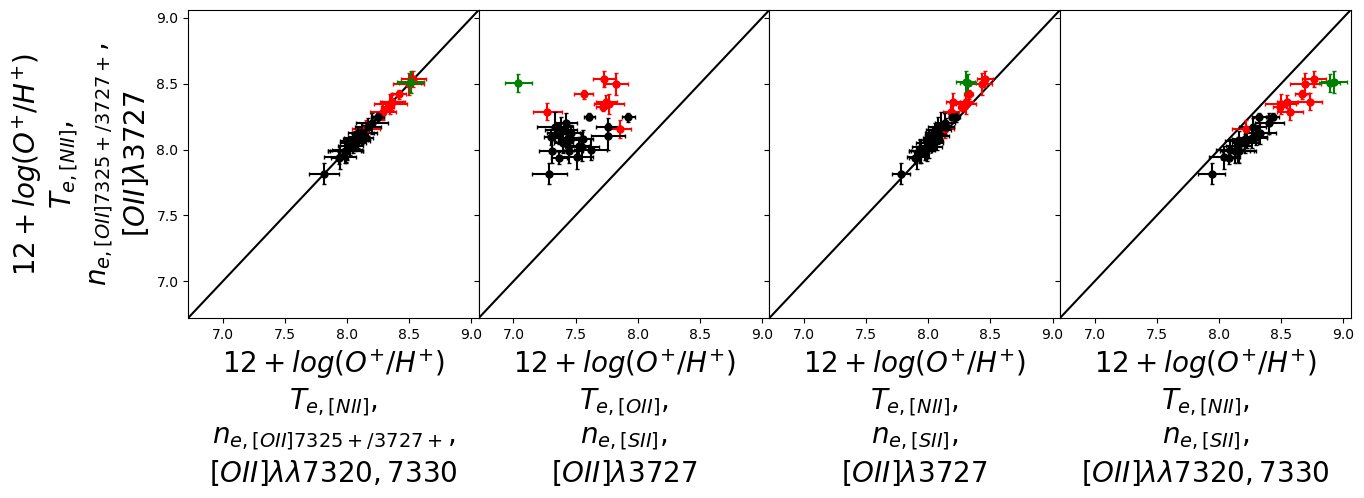

In [18]:
seq = np.linspace(-3, 15, num = 20)
snr = 3
galdic = {1:'NGC4254', 6:'NGC3627', 5:'NGC4535', 4:'NGC3351', 3:'NGC2835', 2:'NGC0628'}
colordic = {2: 'red', 3:'k', 4:'blue', 5:'green', 6:'m'}

labels = np.array(['O2_NII_7325_OII', 'O2_OII_3727_SII', 'O2_NII_3727_SII', 'O2_NII_7325_SII'])
pq_labels = [
    r'$12 + log\left(O^{+}/H^{+}\right)$' + '\n' + r'$T_{e, [NII]},$' + '\n' + r'$n_{e, [OII]7325+/3727+},$' + '\n' + r'$[OII]\lambda3727$', 
    r'$12 + log\left(O^{+}/H^{+}\right)$' + '\n' + r'$T_{e, [NII]},$' + '\n' + r'$n_{e, [OII]7325+/3727+},$' + '\n' + r'$[OII]\lambda\lambda7320, 7330$',
    r'$12 + log\left(O^{+}/H^{+}\right)$' + '\n' + r'$T_{e, [OII]},$' + '\n' + r'$n_{e, [SII]},$' + '\n' + r'$[OII]\lambda3727$', 
    r'$12 + log\left(O^{+}/H^{+}\right)$' + '\n' + r'$T_{e, [NII]},$' + '\n' + r'$n_{e, [SII]},$' + '\n' + r'$[OII]\lambda3727$',
    r'$12 + log\left(O^{+}/H^{+}\right)$' + '\n' + r'$T_{e, [NII]},$' + '\n' + r'$n_{e, [SII]},$' + '\n' + r'$[OII]\lambda\lambda7320, 7330$']
label_size = 20

plt.figure(figsize=(15, 20))
axes = []

for j in range(len(labels)):
    if j == 0 :
        axes.append(plt.subplot(5,4,j+1))
    else:
        axes.append(plt.subplot(5,4,j+1, sharex=axes[0], sharey=axes[0]))
    
    if j%4 == 1 or j%4 == 2 or j%4 == 3:
        axes[j].tick_params('y', labelleft=False)
    
    axes[-1].set_xlabel(pq_labels[j+1], fontsize = label_size)
    if j == 0:
        axes[-1].set_ylabel(pq_labels[0], fontsize= label_size)
    
    axes[-1].plot(np.linspace(6, 10, 10), np.linspace(6, 10, 10), c='k', alpha=1)

    lim_list = []

    for i in range(2, len(galdic) + 1):
        plot_bool = np.where((strong_data['gal_name'] == galdic[i]) & (strong_data['O2_NII_3727_OII']/strong_data['O2_NII_3727_OII_ERR'] > snr) & (strong_data[labels[j]]/strong_data[labels[j]+'_ERR'] > snr))[0]
        a_val = 1
        mark_s = 10
        cap_s = 1.25
        axes[j].errorbar(12+np.log10(strong_data[labels[j]][plot_bool]), 12+np.log10(strong_data['O2_NII_3727_OII'][plot_bool]),
                         xerr=1/np.log(10) * (strong_data[labels[j]+'_ERR'][plot_bool] / strong_data[labels[j]][plot_bool]),
                         yerr= 1/np.log(10) * (strong_data['O2_NII_3727_OII_ERR'][plot_bool] / strong_data['O2_NII_3727_OII'][plot_bool]), 
                         c=colordic[i],fmt=".", markersize=mark_s, capsize=cap_s, alpha=a_val,)
        
        lim_list.append(np.array(12+np.log10(strong_data[labels[j]][plot_bool]))) 
        lim_list.append(np.array(12+np.log10(strong_data['O2_NII_3727_OII'][plot_bool])))  

    lim_list = np.concatenate(lim_list)

    axes[-1].set_ylim(np.nanquantile(lim_list, 0)*0.86, np.nanquantile(lim_list, 1)*1.015)
    axes[-1].set_xlim(np.nanquantile(lim_list, 0)*0.86, np.nanquantile(lim_list, 1)*1.015)

    #axes[-1].text(0.475, 10, pq_labels[j+1])

    #axes[j].legend(fontsize=9)

plt.subplots_adjust(wspace=0,hspace=0)

### O2+ plot

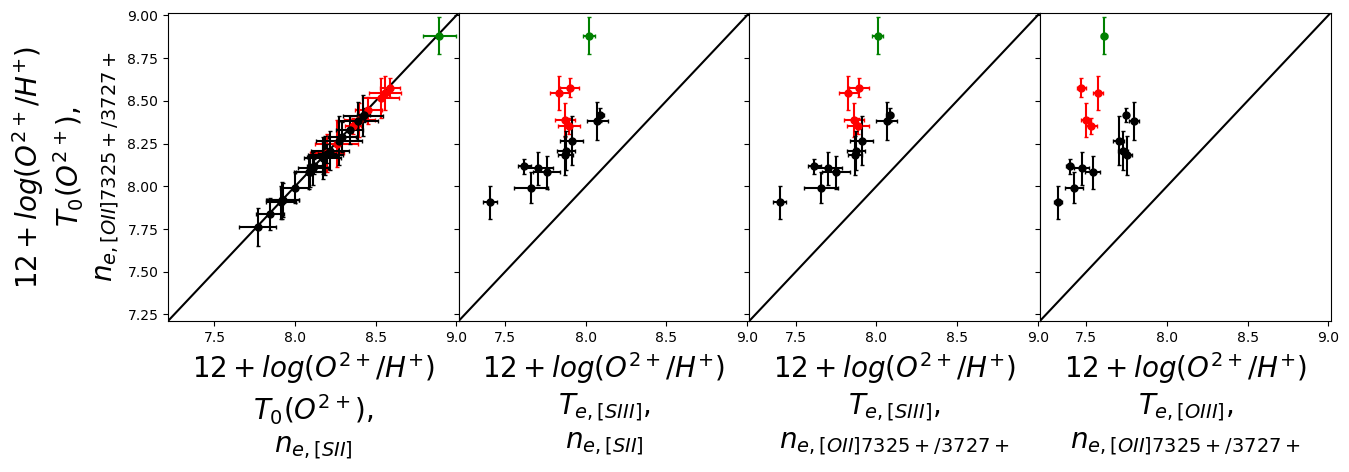

In [19]:
seq = np.linspace(-3, 15, num = 20)
snr = 3
galdic = {1:'NGC4254', 6:'NGC3627', 5:'NGC4535', 4:'NGC3351', 3:'NGC2835', 2:'NGC0628'}
colordic = {2: 'red', 3:'k', 4:'blue', 5:'green', 6:'m'}

labels = np.array(['O3_T0_SII', 'O3_SIII_SII', 'O3_SIII_OII', 'O3_OIII_OII'])
pq_labels = [
    r'$12 + log\left(O^{2+}/H^{+}\right)$' + '\n' + r'$T_{0}(O^{2+}),$' + '\n' + r'$n_{e, [OII]7325+/3727+}$', 
    r'$12 + log\left(O^{2+}/H^{+}\right)$' + '\n' + r'$T_{0}(O^{2+}),$' + '\n' + r'$n_{e, [SII]}$',
    r'$12 + log\left(O^{2+}/H^{+}\right)$' + '\n' + r'$T_{e, [SIII]},$' + '\n' + r'$n_{e, [SII]}$',
    r'$12 + log\left(O^{2+}/H^{+}\right)$' + '\n' + r'$T_{e, [SIII]},$' + '\n' + r'$n_{e, [OII]7325+/3727+}$', 
    r'$12 + log\left(O^{2+}/H^{+}\right)$' + '\n' + r'$T_{e, [OIII]},$' + '\n' + r'$n_{e, [OII]7325+/3727+}$']
label_size = 20

plt.figure(figsize=(15, 20))
axes = []

for j in range(len(labels)):
    if j == 0 :
        axes.append(plt.subplot(5,4,j+1))
    else:
        axes.append(plt.subplot(5,4,j+1, sharex=axes[0], sharey=axes[0]))
    
    if j%4 == 1 or j%4 == 2 or j%4 == 3:
        axes[j].tick_params('y', labelleft=False)
    
    axes[-1].set_xlabel(pq_labels[j+1], fontsize = label_size)
    if j == 0:
        axes[-1].set_ylabel(pq_labels[0], fontsize= label_size)
    
    axes[-1].plot(np.linspace(6, 10, 10), np.linspace(6, 10, 10), c='k', alpha=1)

    lim_list = []

    for i in range(2, len(galdic) + 1):
        plot_bool = np.where((strong_data['gal_name'] == galdic[i]) & (strong_data['O3_T0_OII']/strong_data['O3_T0_OII_ERR'] > snr) & (strong_data[labels[j]]/strong_data[labels[j]+'_ERR'] > snr))[0]
        a_val = 1
        mark_s = 10
        cap_s = 1.25
        axes[j].errorbar(12+np.log10(strong_data[labels[j]][plot_bool]), 12+np.log10(strong_data['O3_T0_OII'][plot_bool]),
                         xerr=1/np.log(10) * (strong_data[labels[j]+'_ERR'][plot_bool] / strong_data[labels[j]][plot_bool]),
                         yerr= 1/np.log(10) * (strong_data['O3_T0_OII_ERR'][plot_bool] / strong_data['O3_T0_OII'][plot_bool]), 
                         c=colordic[i],fmt=".", markersize=mark_s, capsize=cap_s, alpha=a_val,)
        
        lim_list.append(np.array(12+np.log10(strong_data[labels[j]][plot_bool]))) 
        lim_list.append(np.array(12+np.log10(strong_data['O3_T0_OII'][plot_bool])))  

    lim_list = np.concatenate(lim_list)

    axes[-1].set_ylim(np.nanquantile(lim_list, 0)*0.985, np.nanquantile(lim_list, 1)*1.015)
    axes[-1].set_xlim(np.nanquantile(lim_list, 0)*0.985, np.nanquantile(lim_list, 1)*1.015)

    #axes[-1].text(0.475, 10, pq_labels[j+1])

    #axes[j].legend(fontsize=9)

plt.subplots_adjust(wspace=0,hspace=0)

### Plot Direct Z's against MD23

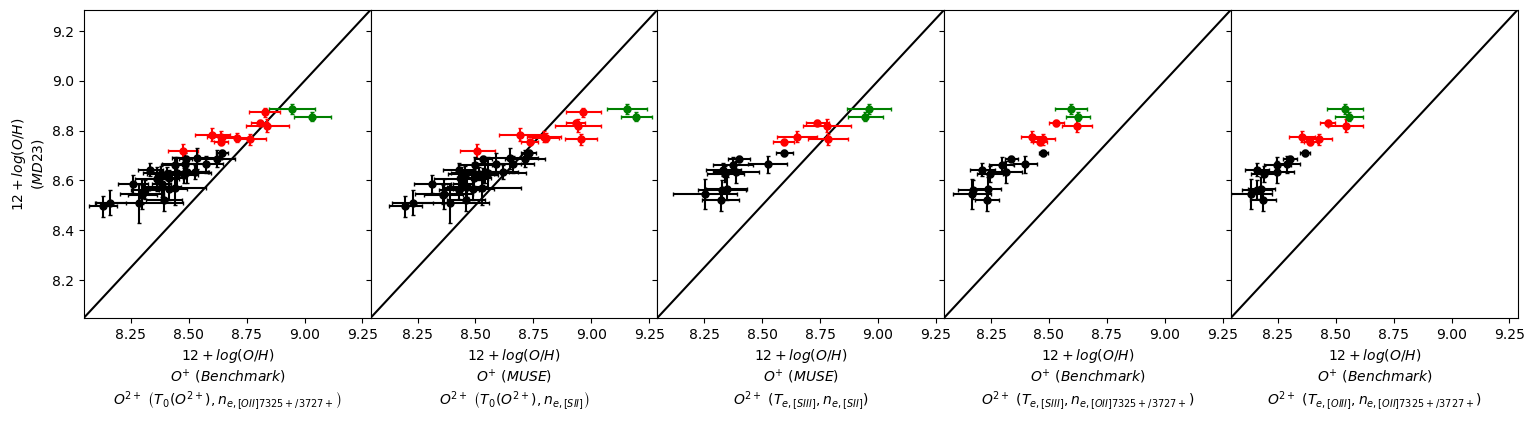

In [20]:
seq = np.linspace(-3, 15, num = 20)
snr = 3
galdic = {1:'NGC4254', 6:'NGC3627', 5:'NGC4535', 4:'NGC3351', 3:'NGC2835', 2:'NGC0628'}
colordic = {2: 'red', 3:'k', 4:'blue', 5:'green', 6:'m'}

labels = np.array(['OH_T0_OII', 'OH_T0_SII', 'OH_SIII_SII', 'OH_SIII_OII', 'OH_OIII_OII'])
pq_labels = [r'$12+log(O/H)$' + '\n' + r'$(MD23)$', 
             r'$12+log(O/H)$' + '\n' + r'$O^{+}$ $\left(Benchmark\right)$' + '\n' + r'$O^{2+}$ $\left(T_{0}(O^{2+}), n_{e, [OII]7325+/3727+}\right)$',
             r'$12+log(O/H)$' + '\n' + r'$O^{+}$ $\left(MUSE\right)$' + '\n' + r'$O^{2+}$ $\left(T_{0}(O^{2+}), n_{e, [SII]}\right)$',
             r'$12+log(O/H)$' + '\n' + r'$O^{+}$ $\left(MUSE\right)$' + '\n' + r'$O^{2+}$ $\left(T_{e, [SIII]}, n_{e, [SII]}\right)$', 
             r'$12+log(O/H)$' + '\n' + r'$O^{+}$ $\left(Benchmark\right)$' + '\n' + r'$O^{2+}$ $\left(T_{e, [SIII]}, n_{e, [OII]7325+/3727+}\right)$',
             r'$12+log(O/H)$' + '\n' + r'$O^{+}$ $\left(Benchmark\right)$' + '\n' + r'$O^{2+}$ $\left(T_{e, [OIII]}, n_{e, [OII]7325+/3727+}\right)$',]
label_size = 10

plt.figure(figsize=(18.5, 20))
axes = []
lim_list = []

for j in range(len(labels)):
    if j == 0 :
        axes.append(plt.subplot(5,5,j+1))
    else:
        axes.append(plt.subplot(5,5,j+1, sharex=axes[0], sharey=axes[0]))
    
    if j%5 == 1 or j%5 == 2 or j%5 == 3 or j%5 == 4:
        axes[j].tick_params('y', labelleft=False)
    
    axes[-1].set_xlabel(pq_labels[j+1], fontsize = label_size)
    if j == 0:
        axes[-1].set_ylabel(pq_labels[0], fontsize= label_size)
    
    axes[-1].plot(np.linspace(-10, 20, 10), np.linspace(-10, 20, 10), c='k', alpha=1)

    for i in range(2, len(galdic) + 1):
        plot_bool = np.where((strong_data['gal_name'] == galdic[i]) & (strong_data[labels[j]]/strong_data[labels[j]+'_ERR'] > snr))[0]
        a_val = 1
        mark_s = 10
        cap_s = 1.25
        axes[j].errorbar(strong_data[labels[j]][plot_bool], strong_data['met_md23'][plot_bool],
                         xerr=strong_data[labels[j]+'_ERR'][plot_bool],
                         yerr= strong_data['met_md23_err'][plot_bool], 
                         c=colordic[i],fmt=".", markersize=mark_s, capsize=cap_s, alpha=a_val,)
        
        lim_list.append(np.array(strong_data[labels[j]][plot_bool])) 
        lim_list.append(np.array(strong_data['met_md23'][plot_bool]))  

lim_list_1 = np.concatenate(lim_list)

axes[-1].set_ylim(np.nanmin(lim_list_1)*0.99, np.nanmax(lim_list_1)*1.01)
axes[-1].set_xlim(np.nanmin(lim_list_1)*0.99, np.nanmax(lim_list_1)*1.01)

plt.subplots_adjust(wspace=0,hspace=0)

### Benchmark versus MD23 metallicity

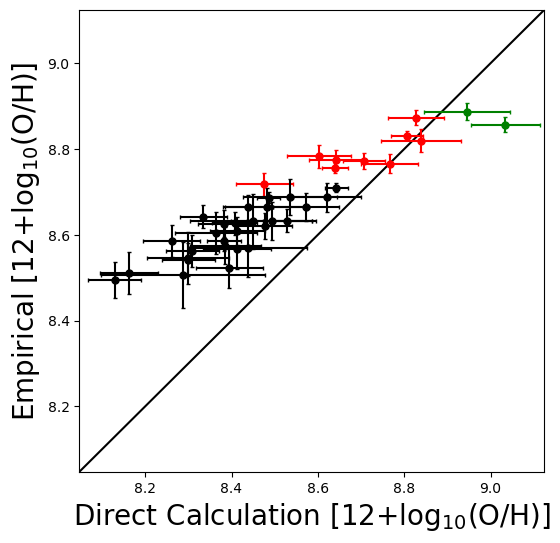

In [74]:
seq = np.linspace(-3, 15, num = 20)
snr = 3
galdic = {1:'NGC4254', 6:'NGC3627', 5:'NGC4535', 4:'NGC3351', 3:'NGC2835', 2:'NGC0628'}
colordic = {2: 'red', 3:'k', 4:'blue', 5:'green', 6:'m'}

labels = np.array(['OH_T0_OII'])
pq_labels = [r'Empirical [12+log$_{10}$(O/H)]', 
             r'Direct Calculation [12+log$_{10}$(O/H)]',]
label_size = 20

plt.figure(figsize=(30, 30))
axes = []
lim_list = []

for j in range(len(labels)):
    if j == 0 :
        axes.append(plt.subplot(5,5,j+1))
    else:
        axes.append(plt.subplot(5,5,j+1, sharex=axes[0], sharey=axes[0]))
    
    if j%5 == 1 or j%5 == 2 or j%5 == 3 or j%5 == 4:
        axes[j].tick_params('y', labelleft=False)
    
    axes[-1].set_xlabel(pq_labels[j+1], fontsize = label_size)
    if j == 0:
        axes[-1].set_ylabel(pq_labels[0], fontsize= label_size)
    
    axes[-1].plot(np.linspace(-10, 20, 10), np.linspace(-10, 20, 10), c='k', alpha=1)

    for i in range(2, len(galdic) + 1):
        plot_bool = np.where((strong_data['gal_name'] == galdic[i]) & (strong_data[labels[j]]/strong_data[labels[j]+'_ERR'] > snr))[0]
        a_val = 1
        mark_s = 10
        cap_s = 1.25
        axes[j].errorbar(strong_data[labels[j]][plot_bool], strong_data['met_md23'][plot_bool],
                         xerr=strong_data[labels[j]+'_ERR'][plot_bool],
                         yerr= strong_data['met_md23_err'][plot_bool], 
                         c=colordic[i],fmt=".", markersize=mark_s, capsize=cap_s, alpha=a_val,)
        
        lim_list.append(np.array(strong_data[labels[j]][plot_bool])) 
        lim_list.append(np.array(strong_data['met_md23'][plot_bool]))  
        

lim_list_1 = np.concatenate(lim_list)

axes[-1].set_ylim(np.nanmin(lim_list_1)*0.99, np.nanmax(lim_list_1)*1.01)
axes[-1].set_xlim(np.nanmin(lim_list_1)*0.99, np.nanmax(lim_list_1)*1.01)

plt.subplots_adjust(wspace=0,hspace=0)

### Te-Te relationships

In [21]:
def rv23_nii_siii(in_temp):
    temp = in_temp / 10**4
    out_temp = 1.35 * temp - 0.24
    return out_temp

def rv23_oii_siii(in_temp):
    temp = in_temp / 10**4
    out_temp = 0.67 * temp - 0.022
    return out_temp

def rv23_oii_nii(in_temp):
    temp = in_temp / 10**4
    out_temp = 0.47 * temp + 0.36
    return out_temp

def delgado_oii_nii(in_temp):
    return 0.62 * in_temp + 2660

def chaos_nii_siii(in_temp):
    temp = in_temp / 10**4
    out_temp = 1.46 * temp - 0.41
    return out_temp

def z21_nii_siii(in_temp):
    return 1.4 * in_temp - 3700

def z21_oii_siii(in_temp):
    return 0.67 * in_temp + 2200

def z21_oii_nii(in_temp):
    return 0.46 * in_temp + 4400

### Make a corner plot of temperature and densities

NGC0628 9 OII_TEMP NII_TEMP
NGC2835 26 OII_TEMP NII_TEMP
NGC3351 0 OII_TEMP NII_TEMP
NGC4535 2 OII_TEMP NII_TEMP
NGC3627 0 OII_TEMP NII_TEMP
OII_TEMP NII_TEMP 0.6666307633521553 0.11561041191234717 0.06118743493288366 0.05544130383682608 37
NGC0628 5 OII_TEMP SIII_TEMP
NGC2835 14 OII_TEMP SIII_TEMP
NGC3351 0 OII_TEMP SIII_TEMP
NGC4535 2 OII_TEMP SIII_TEMP
NGC3627 0 OII_TEMP SIII_TEMP
OII_TEMP SIII_TEMP 0.6467978132757436 0.08613913609485091 0.09602248311288104 0.08355308807411686 21
NGC0628 6 NII_TEMP SIII_TEMP
NGC2835 12 NII_TEMP SIII_TEMP
NGC3351 0 NII_TEMP SIII_TEMP
NGC4535 5 NII_TEMP SIII_TEMP
NGC3627 0 NII_TEMP SIII_TEMP
NII_TEMP SIII_TEMP -0.0023556872018211106 0.9520777290693704 0.060748446970626854 0.07878529840030982 23


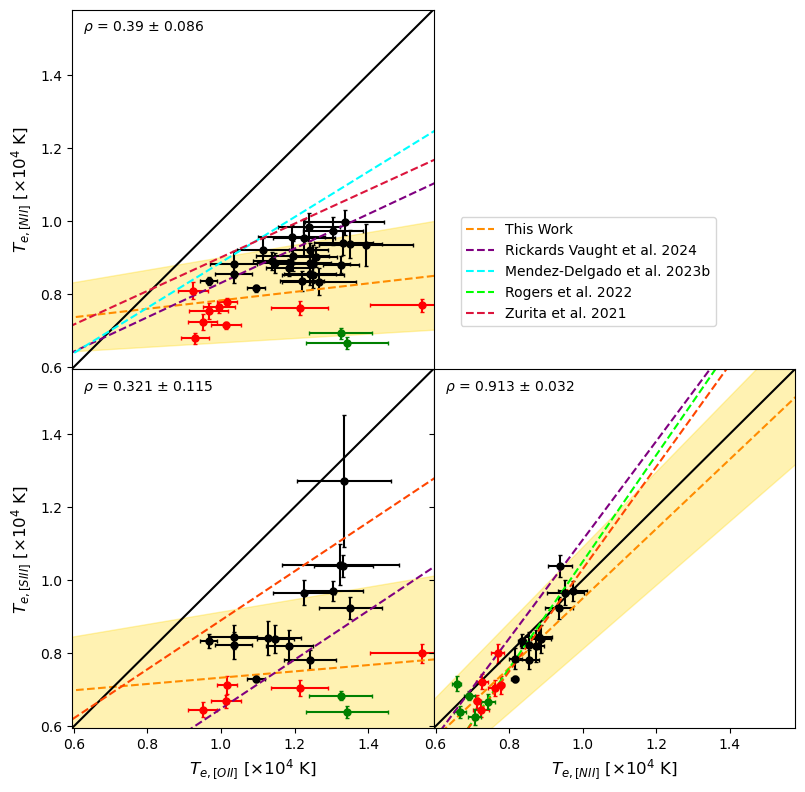

In [22]:
fig = plt.figure(figsize=(14, 14))

pq_list = ['OII_TEMP', 'NII_TEMP', 'SIII_TEMP']#, 'OIII_TEMP_MD23', 'OIII_TEMP_B12']#, 'SII_DEN_NII', 'SII_DEN_SIII']
pq_labels = [r'$T_{e, [O II]}$ [$\times 10^{4}$ K]', r'$T_{e, [N II]}$ [$\times 10^{4}$ K]', r'$T_{e, [S III]}$ [$\times 10^{4}$ K]'] 
            #r'$T_{0}(O^{2+})$ [$\times 10^{4}$ K]', r'$T_{e}$ [OIII] [$\times 10^{4}$ K]']

colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
galdic = {1:'NGC4254', 5:'NGC4535', 4:'NGC3351', 3:'NGC2835', 2:'NGC0628', 6:'NGC3627'}

snr = 0.9
axes = []
mc_count = 0
label_size = 12

s_line = np.linspace(-10, 10**5, 100)

fit_plot = []

for i in range(len(pq_list)):
    lim_data = []
    for j in range(len(pq_list)):
        if j - i < 0:
            if len(axes) == 0:
                axes.append(plt.subplot2grid((len(pq_list), len(pq_list)), (i, j)))
            else:
                axes.append(plt.subplot2grid((len(pq_list), len(pq_list)), (i, j) , sharex=axes[j], sharey=axes[j]))

            if i == len(pq_list) - 1:
                axes[-1].set_xlabel(pq_labels[j], fontsize=label_size)
            if j == 0:
                axes[-1].set_ylabel(pq_labels[i], fontsize=label_size)

            if j != 0:
                axes[-1].tick_params('y', labelleft=False)
            if i != len(pq_list) - 1:
                axes[-1].tick_params('x', labelbottom=False)

            plot_data_x, plot_data_x_err = [], []
            plot_data_y, plot_data_y_err = [], []
            
            for k in range(1, len(table_dic)+1):
                plot_ind = np.where(~np.isnan(np.array(table_dic[k][pq_list[j]] + table_dic[k][pq_list[j]])) & (table_dic[k][pq_list[i]] / table_dic[k][pq_list[i]+'_ERR'] > snr) & (table_dic[k][pq_list[j]] / table_dic[k][pq_list[j]+'_ERR']  > snr))[0]
                gal_name = table_dic[k]['gal_name'][0]
                print(gal_name, len(plot_ind), pq_list[j], pq_list[i])

                lim_data.append(np.array(table_dic[k][pq_list[i]][plot_ind]))
                lim_data.append(np.array(table_dic[k][pq_list[j]][plot_ind]))

                axes[-1].errorbar(table_dic[k][pq_list[j]][plot_ind] / 10**4, table_dic[k][pq_list[i]][plot_ind] / 10**4,
                            xerr=table_dic[k][pq_list[j]+'_ERR'][plot_ind] / 10**4, yerr=table_dic[k][pq_list[i]+'_ERR'][plot_ind] / 10**4,
                            c=colordic[k], fmt="o", markersize=5, capsize=1.5, alpha=1)

               # axes[-1].errorbar(table_dic[k][pq_list[j]][plot_ind] / 10**4, table_dic[k][pq_list[i]][plot_ind] / 10**4,
                #            #xerr=table_dic[k][pq_list[j]+'_ERR'][plot_ind] / 10**4, yerr=table_dic[k][pq_list[i]+'_ERR'][plot_ind] / 10**4,
                 #           c=colordic[k], fmt=".", markersize=8, capsize=0.5, alpha=1)
                
                div_f = 10**4
                plot_data_x = np.concatenate([plot_data_x, np.array(table_dic[k][pq_list[j]][plot_ind] / div_f)])
                plot_data_x_err = np.concatenate([plot_data_x_err, np.array(table_dic[k][pq_list[j]+'_ERR'][plot_ind] / div_f)])
                plot_data_y = np.concatenate([plot_data_y, np.array(table_dic[k][pq_list[i]][plot_ind] / div_f)])
                plot_data_y_err = np.concatenate([plot_data_y_err, np.array(table_dic[k][pq_list[i]+'_ERR'][plot_ind] / div_f)])
            
            spear, spear_err = spear_func(plot_data_x, plot_data_y, plot_data_x_err, plot_data_y_err)

            fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(plot_data_x, plot_data_y, plot_data_x_err, plot_data_y_err)

            print(pq_list[j], pq_list[i], fit_coef, fit_slope, fit_coef_err, fit_slope_err, len(plot_data_x))

            axes[-1].plot(s_line, fit_coef + fit_slope*s_line, 
                          c='darkorange', linestyle='--')#, 
                          #label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
            axes[-1].fill_between(s_line, 
                                  (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*s_line, 
                                  (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*s_line,
                                  color='gold', alpha=0.3)
            
            axes[-1].text(0.625, 1.52, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
            
            axes[-1].plot(np.linspace(-1, 10**11, 10), np.linspace(-1, 10**11, 10), c='k', alpha=1)
            
            #Te-Te relations from other papers
            
            if pq_list[i] == 'SIII_TEMP' and pq_list[j] == 'NII_TEMP':
                
                plt.plot(s_line / 10**4, rv23_nii_siii(s_line), c='purple', linestyle='--')
                plt.plot(s_line / 10**4, chaos_nii_siii(s_line), c='lime', linestyle='--')
                plt.plot(s_line  / 10**4, z21_nii_siii(s_line)  / 10**4, c='orangered', linestyle='--')
            
            if pq_list[i] == 'SIII_TEMP' and pq_list[j] == 'OII_TEMP':
                
                plt.plot(s_line  / 10**4, rv23_oii_siii(s_line), c='purple', linestyle='--')
                plt.plot(s_line  / 10**4, z21_oii_siii(s_line)  / 10**4, c='orangered', linestyle='--')
                
            if pq_list[i] == 'NII_TEMP' and pq_list[j] == 'OII_TEMP':
                
                plt.plot(s_line / 10**4, rv23_oii_nii(s_line), c='purple', linestyle='--')
                plt.plot(s_line  / 10**4, delgado_oii_nii(s_line)  / 10**4, c='cyan', linestyle='--')
                plt.plot(s_line  / 10**4, z21_oii_nii(s_line)  / 10**4, c='crimson', linestyle='--')

    if i != 0:
        l_bound = np.quantile(np.concatenate(lim_data) / 10**4, 0)
        h_bound = np.quantile(np.concatenate(lim_data) / 10**4, 1)
        up_val = 1.02
        down_val = 0.95
        axes[-1].set_ylim(l_bound*down_val, h_bound*up_val)
        axes[-1].set_xlim(l_bound*down_val, h_bound*up_val)
        #axes[-1].set_ylim(0.5, 2.35)
        #axes[-1].set_xlim(0.5, 2.35)
        #axes[-1].set_xscale('log')
        #axes[-1].set_yscale('log')

f_line = np.linspace(-10, -1, 10)
plt.plot(f_line, f_line, c='darkorange', linestyle='--', label='This Work')
plt.plot(f_line, f_line, c='purple', linestyle='--', label='Rickards Vaught et al. 2024')
plt.plot(f_line, f_line, c='cyan', linestyle='--', label='Mendez-Delgado et al. 2023b')
plt.plot(f_line, f_line, c='lime', linestyle='--', label='Rogers et al. 2022')
plt.plot(f_line, f_line, c='crimson', linestyle='--', label='Zurita et al. 2021')

plt.legend(bbox_to_anchor=(0.8, 1.1))

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Make O++ and O+ plot from Amayo et al. 2022

8.02139498927611 0.9543240693191066 0.11423560210374804 0.21144290517851388


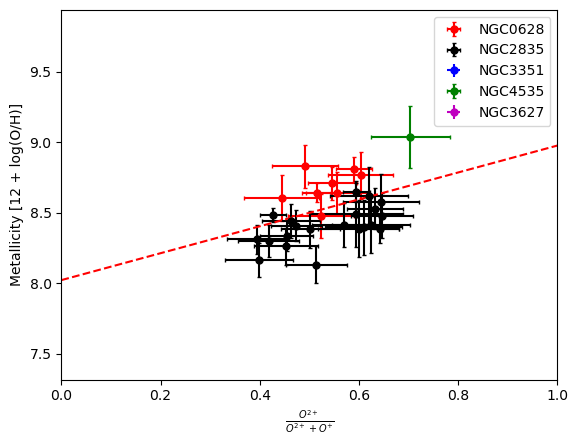

In [23]:
o2_str = 'O2_NII_3727_OII'
o3_str = 'O3_T0_OII'
met_str = 'OH_T0_OII'

plot_ind = np.where((np.array(strong_data[o2_str])/ np.array(strong_data[o2_str + '_ERR']) > 3) & (np.array(strong_data[o3_str])/np.array(strong_data[o3_str + '_ERR']) > 3) )[0]

o2 = np.array(np.array(strong_data[o2_str][plot_ind]))
o3 =np.array(np.array(strong_data[o3_str][plot_ind])) 
omega = o3 / (o3 + o2)

o2_err = np.array(strong_data[o2_str + '_ERR'][plot_ind])
o3_err= np.array(strong_data[o3_str + '_ERR'][plot_ind])

d_err = np.sqrt(o2_err**2 + o3_err**2)
omega_err = omega * np.sqrt((d_err / (o2 + o3))**2 + (o3_err / o3)**2)

met = np.array(strong_data[met_str][plot_ind])
met_err = np.array(strong_data[met_str + '_ERR'][plot_ind])

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(omega, met, omega_err, met_err)
print(fit_coef, fit_slope, fit_coef_err, fit_slope_err)

for k in range(1, 6):
    
    gal_ind = np.where(strong_data[plot_ind]['gal_name'] == galdic[k+1])
    
    plt.errorbar(omega[gal_ind], met[gal_ind], omega_err[gal_ind], met_err[gal_ind],
                 c=colordic[k], fmt="o", markersize=5, capsize=1.5, alpha=1, label=galdic[k+1])

plt.plot(np.linspace(0, 5*10**4, 20), fit_coef + fit_slope*np.linspace(0, 5*10**4, 20), c='red', linestyle='--')

plt.plot(np.linspace(0, 5*10**4, 20), np.linspace(0, 5*10**4, 20), c='k')

plt.xlabel(r'$\frac{O^{2+}}{O^{2+} + O^{+}}$')
plt.ylabel('Metallicity [12 + log(O/H)]')

min_met = np.nanmin(met) * 0.9
max_met = np.nanmax(met) * 1.1
plt.xlim(0, 1)
plt.ylim(min_met, max_met)

plt.legend()

### Compare each of our N/O derivations

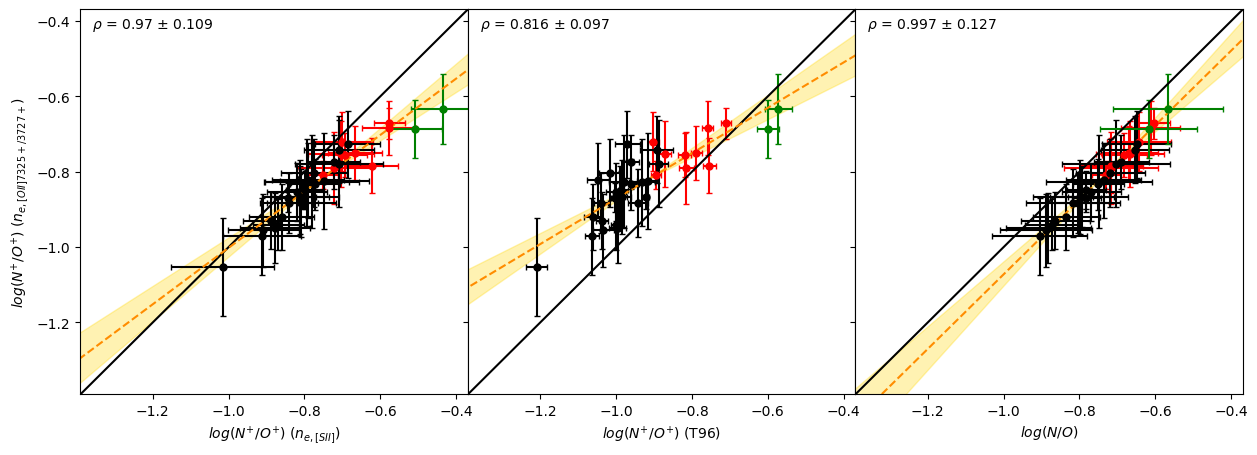

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s = 5
cap_s = 2
a_val = 1

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['N2_ABUN_SII']/strong_data['N2_ABUN_SII_ERR'] > snr) & (strong_data['N2_ABUN_OII']/strong_data['N2_ABUN_OII_ERR'] > snr))[0]

    axs[0].errorbar(np.log10(strong_data['N2_ABUN_SII'][plot_ind]), np.log10(strong_data['N2_ABUN_OII'][plot_ind]),
                    xerr=1/np.log(10) * (strong_data['N2_ABUN_SII_ERR'][plot_ind] / strong_data['N2_ABUN_SII'][plot_ind]),
                    yerr=1/np.log(10) * (strong_data['N2_ABUN_OII_ERR'][plot_ind] / strong_data['N2_ABUN_OII'][plot_ind]), 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

plot_ind_1 = np.where((strong_data['N2_ABUN_SII']/strong_data['N2_ABUN_SII_ERR'] > snr) & (strong_data['N2_ABUN_OII']/strong_data['N2_ABUN_OII_ERR'] > snr))[0]
lim_list = np.concatenate([np.log10(np.array(strong_data['N2_ABUN_SII'][plot_ind_1])), np.log10(np.array(strong_data['N2_ABUN_OII'][plot_ind_1]))])

axs[0].plot(np.linspace(-2, 1, 100), np.linspace(-2, 1, 100), c='k')
axs[0].set_ylabel(r'$log(N^{+}/O^{+})$ $(n_{e, [OII]7325+/3727+})$')
axs[0].set_xlabel(r'$log(N^{+}/O^{+})$ $(n_{e, [SII]})$')

x, y = np.log10(np.array(strong_data['N2_ABUN_SII'][plot_ind_1])), np.log10(np.array(strong_data['N2_ABUN_OII'][plot_ind_1]))
x_err = 1/np.log(10) * (strong_data['N2_ABUN_SII_ERR'][plot_ind_1] / strong_data['N2_ABUN_SII'][plot_ind_1])
y_err = 1/np.log(10) * (strong_data['N2_ABUN_OII_ERR'][plot_ind_1] / strong_data['N2_ABUN_OII'][plot_ind_1])
spear, spear_err = spear_func(x, y, x_err, y_err)
fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[0].plot(np.linspace(-5, 5, 10), fit_coef + fit_slope*np.linspace(-5, 5, 10), 
             c='darkorange', linestyle='--') 
             #label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].fill_between(np.linspace(-5, 5, 10), 
                     (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-5, 5, 10), 
                     (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-5, 5, 10),
                     color='gold', alpha=0.3)
axs[0].text(-1.36, -0.42, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
#axs[0].legend()

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['N2_ABUN_OII']/strong_data['N2_ABUN_OII_ERR'] > snr) & (1 / (np.log(10) * strong_data['NO_t96_err']) > snr))[0]

    axs[1].errorbar(strong_data['NO_t96'][plot_ind], np.log10(strong_data['N2_ABUN_OII'][plot_ind]),
             yerr=1/np.log(10) * (strong_data['N2_ABUN_OII_ERR'][plot_ind] / strong_data['N2_ABUN_OII'][plot_ind]),
             xerr=strong_data['NO_t96_err'][plot_ind], c=colordic[k-1],
             fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

plot_ind_2 = np.where((strong_data['N2_ABUN_OII']/strong_data['N2_ABUN_OII_ERR'] > snr) & (1 / (np.log(10) * strong_data['NO_t96_err']) > snr))[0]
lim_list = np.concatenate([lim_list, np.log10(np.array(strong_data['N2_ABUN_OII'][plot_ind_2])), np.array(strong_data['NO_t96'][plot_ind_2])])

axs[1].plot(np.linspace(-2, 1, 100), np.linspace(-2, 1, 100), c='k')
axs[1].set_xlabel(r'$log(N^{+}/O^{+})$ (T96)')

axs[1].set_xlim(np.nanmin(lim_list)*1.15, np.nanmax(lim_list)*0.85)
axs[1].set_ylim(np.nanmin(lim_list)*1.15, np.nanmax(lim_list)*0.85)

x, y = np.array(strong_data['NO_t96'][plot_ind_2]), np.log10(np.array(strong_data['N2_ABUN_OII'][plot_ind_2]))
x_err = np.array(strong_data['NO_t96_err'][plot_ind_2])
y_err = 1/np.log(10) * (strong_data['N2_ABUN_OII_ERR'][plot_ind_2] / strong_data['N2_ABUN_OII'][plot_ind_2])
spear, spear_err = spear_func(x, y, x_err, y_err)
fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[1].plot(np.linspace(-5, 5, 10), fit_coef + fit_slope*np.linspace(-5, 5, 10), 
             c='darkorange', linestyle='--')
             #label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].fill_between(np.linspace(-5, 5, 10), 
                     (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-5, 5, 10), 
                     (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-5, 5, 10),
                     color='gold', alpha=0.3)
axs[1].text(-1.36, -0.42, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

plot_ind_3 = np.where((strong_data['N2_ABUN_OII']/strong_data['N2_ABUN_OII_ERR'] > snr) & (1 / (np.log(10) * strong_data['N_T0_ERR']) > snr))[0]
lim_list = np.concatenate([lim_list, np.log10(np.array(strong_data['N2_ABUN_OII'][plot_ind_3])), np.array(strong_data['N_T0'][plot_ind_3])])

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['N2_ABUN_OII']/strong_data['N2_ABUN_OII_ERR'] > snr) & (1 / (np.log(10) * strong_data['N_T0_ERR']) > snr))[0]

    axs[2].errorbar(strong_data['N_T0'][plot_ind], np.log10(strong_data['N2_ABUN_OII'][plot_ind]),
             yerr=1/np.log(10) * (strong_data['N2_ABUN_OII_ERR'][plot_ind] / strong_data['N2_ABUN_OII'][plot_ind]),
             xerr=strong_data['N_T0_ERR'][plot_ind], c=colordic[k-1],
             fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

axs[2].plot(np.linspace(-2, 1, 100), np.linspace(-2, 1, 100), c='k')
axs[2].set_xlabel(r'$log(N/O)$')

axs[2].set_xlim(np.nanmin(lim_list)*1.15, np.nanmax(lim_list)*0.85)
axs[2].set_ylim(np.nanmin(lim_list)*1.15, np.nanmax(lim_list)*0.85)

x, y = np.array(strong_data['N_T0'][plot_ind_3]), np.log10(np.array(strong_data['N2_ABUN_OII'][plot_ind_3]))
x_err = np.array(strong_data['N_T0_ERR'][plot_ind_3])
y_err = 1/np.log(10) * (strong_data['N2_ABUN_OII_ERR'][plot_ind_3] / strong_data['N2_ABUN_OII'][plot_ind_3])
spear, spear_err = spear_func(x, y, x_err, y_err)
fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[2].plot(np.linspace(-5, 5, 10), fit_coef + fit_slope*np.linspace(-5, 5, 10), 
             c='darkorange', linestyle='--')
             #label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[2].fill_between(np.linspace(-5, 5, 10), 
                     (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-5, 5, 10), 
                     (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-5, 5, 10),
                     color='gold', alpha=0.3)
axs[2].text(-1.36, -0.42, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Find spearman coefficient for plot above

In [25]:
x, y = np.log10(np.array(strong_data['N2_ABUN_SII'][plot_ind_1])), np.log10(np.array(strong_data['N2_ABUN_OII'][plot_ind_1]))
x_err = 1/np.log(10) * (strong_data['N2_ABUN_SII_ERR'][plot_ind_1] / strong_data['N2_ABUN_SII'][plot_ind_1])
y_err = 1/np.log(10) * (strong_data['N2_ABUN_OII_ERR'][plot_ind_1] / strong_data['N2_ABUN_OII'][plot_ind_1])

print(spear_func(x, y, x_err, y_err))

x, y = np.array(strong_data['NO_t96'][plot_ind_2]), np.log10(np.array(strong_data['N2_ABUN_OII'][plot_ind_2]))
x_err = np.array(strong_data['NO_t96_err'][plot_ind_2])
y_err = 1/np.log(10) * (strong_data['N2_ABUN_OII_ERR'][plot_ind_2] / strong_data['N2_ABUN_OII'][plot_ind_2])

print(spear_func(x, y, x_err, y_err))

(0.9696267696267697, 0.11369699710557132)
(0.8159588159588159, 0.09506852178787974)


### N/O verus r_eff, O/H

NGC0628
NGC2835
NGC3351
NGC4535
NGC3627
0.029356248260269627 0.0485470641326934
9
22
0
2
0


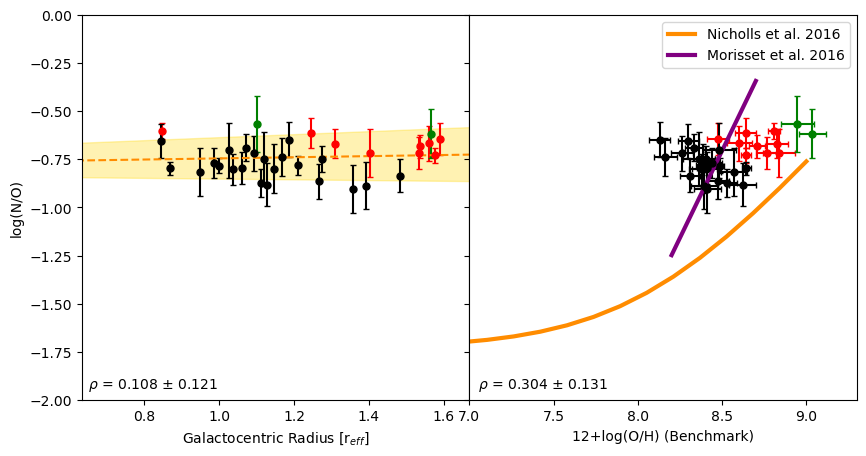

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s = 5
cap_s = 2
a_val = 1

N_abun = 'N_T0'

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * strong_data[N_abun+'_ERR']) > snr))[0]
    print(galdic[k])
    axs[0].errorbar(strong_data['r_reff'][plot_ind], strong_data[N_abun][plot_ind],
                    yerr= strong_data[N_abun+'_ERR'][plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

plot_ind_1 = np.where((1 / (np.log(10) * strong_data[N_abun+'_ERR']) > snr))[0]
lim_list = np.array(strong_data[N_abun][plot_ind_1])
#axs[0].set_ylim(np.nanmin(lim_list)*1.5, np.nanmax(lim_list)*0.5)
axs[0].set_ylim(-2, 0)

x, y = np.array(strong_data['r_reff'][plot_ind_1]), np.array(strong_data[N_abun][plot_ind_1])
x_err = np.array([0 for i in range(len(x))])
y_err = np.array(strong_data[N_abun+'_ERR'][plot_ind_1])
spear, spear_err = spear_func(x, y, x_err, y_err)
fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

print(fit_slope, fit_slope_err)

axs[0].plot(np.linspace(-5, 5, 10), fit_coef + fit_slope*np.linspace(-5, 5, 10), 
             c='darkorange', linestyle='--')
             #label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].fill_between(np.linspace(-5, 5, 10), 
                     (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-5, 5, 10), 
                     (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-5, 5, 10),
                     color='gold', alpha=0.3)

lim_list = np.array(strong_data['r_reff'][plot_ind_1])
axs[0].set_xlim(np.nanmin(lim_list)*0.75, np.nanmax(lim_list)*1.05)

axs[0].text(0.65, -1.94, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

axs[0].set_ylabel(r'log(N/O)')
axs[0].set_xlabel(r'Galactocentric Radius [r$_{eff}$]')

met, met_err = 'OH_T0_OII', 'OH_T0_OII_ERR'
#met, met_err = 'met_md23', 'met_md23'

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * strong_data[N_abun+'_ERR']) > snr) & (1 / (np.log(10) * strong_data[met_err]) > snr))[0]

    axs[1].errorbar(strong_data[met][plot_ind], strong_data[N_abun][plot_ind],
                 yerr= strong_data[N_abun+'_ERR'][plot_ind],
                 xerr=strong_data[met_err][plot_ind], c=colordic[k-1],
                 fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)
    
    print(len(plot_ind))
plot_ind_2 = np.where((1 / (np.log(10) * strong_data[N_abun+'_ERR']) > snr) & (1 / (np.log(10) * strong_data[met_err]) > snr))[0]
lim_list = np.array(strong_data[met][plot_ind_2])
#axs[1].set_xlim(np.nanmin(lim_list)*0.9, np.nanmax(lim_list)*1.1)
axs[1].set_xlim(7, 9.3)

def nicholls_rel(line_in):
    return np.log10(10**-1.732 + 10**(line_in + 2.19 - 12))

def morisset_rel(line_in):
    return -16.09 + 1.81 * (line_in)

def pilyugin_rel(line_in):
    
    z0 = 8.23 
    
    if line_in < z0:
        val = -1.39 + 0.39(line_in-z0) + 0.30*(line_in-z0)**2
        return val
    
    elif line_in > z0:
        val -1.39 + 1.24(line_in-z0) + 1.63*(line_in-z0)**2
        return val

n_line = np.linspace(6, 9, 20)

axs[1].plot(n_line, nicholls_rel(n_line), c='darkorange', label='Nicholls et al. 2016',
            linewidth=3)

n_line = np.linspace(8.2, 8.7, 20)

axs[1].plot(n_line, np.array([morisset_rel(n_line[i]) for i in range(len(n_line))]), c='purple', label='Morisset et al. 2016',
            linewidth=3)

n_line = np.linspace(7.1, 8.8, 20)

#axs[1].plot(n_line, np.array([pilyugin_rel(n_line[i]) for i in range(len(n_line))]), c='cyan', label='Pilyugin et al. 2012',
 #           linewidth=3)

x, y = np.array(strong_data[met][plot_ind_2]), np.array(strong_data[N_abun][plot_ind_2])
x_err = np.array(strong_data[met_err][plot_ind_2])
y_err = np.array(strong_data[N_abun+'_ERR'][plot_ind_2])
spear, spear_err = spear_func(x, y, x_err, y_err)
fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[1].text(7.05, -1.94, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

axs[1].set_xlabel(r'12+log(O/H) (Benchmark)')
axs[1].legend()

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Make the same N/O plot but with R25 and MD23

NGC0628
NGC2835
NGC3351
NGC4535
NGC3627


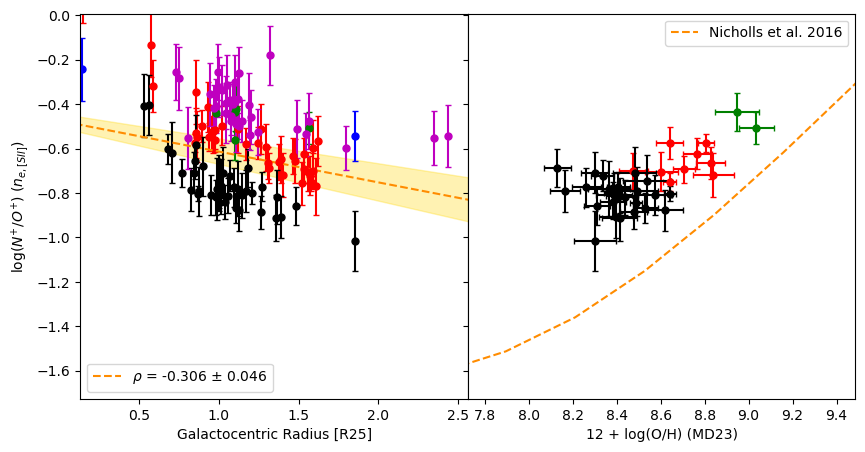

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}

N_abun = 'N2_ABUN_SII'

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (np.array(strong_data[N_abun]/strong_data[N_abun+'_ERR']) > snr))[0]
    print(galdic[k])
    axs[0].errorbar(strong_data['r_reff'][plot_ind], np.log10(strong_data[N_abun][plot_ind]),
                    yerr=1/np.log(10) * (strong_data[N_abun+'_ERR'][plot_ind] / strong_data[N_abun][plot_ind]), 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

plot_ind_1 = np.where((strong_data[N_abun]/strong_data[N_abun+'_ERR'] > snr))[0]
lim_list = np.log10(np.array(strong_data[N_abun][plot_ind_1]))
#axs[0].set_ylim(np.nanmin(lim_list)*2, 1)
axs[0].set_ylim(np.nanmin(lim_list)*1.7, np.nanmax(lim_list)*0.1)

x, y = np.array(strong_data['r_reff'][plot_ind_1]), np.log10(np.array(strong_data[N_abun][plot_ind_1]))
x_err = np.array([0 for i in range(len(x))])
y_err = 1/np.log(10) * (np.array(strong_data[N_abun+'_ERR'][plot_ind_1]) / np.array(strong_data[N_abun][plot_ind_1]))
spear, spear_err = spear_func(x, y, x_err, y_err)
fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[0].plot(np.linspace(-5, 5, 10), fit_coef + fit_slope*np.linspace(-5, 5, 10), 
             c='darkorange', linestyle='--', 
             label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].fill_between(np.linspace(-5, 5, 10), 
                     (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-5, 5, 10), 
                     (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-5, 5, 10),
                     color='gold', alpha=0.3)
axs[0].legend()

lim_list = np.array(strong_data['r_reff'][plot_ind_1])
axs[0].set_xlim(np.nanmin(lim_list)*0.95, np.nanmax(lim_list)*1.05)

axs[0].set_ylabel(r'log($N^{+}/O^{+}$) ($n_{e, [SII]}$)')
axs[0].set_xlabel(r'Galactocentric Radius [R25]')

#met, met_err = 'met_md23', 'met_md23_err'
met, met_err = 'OH_T0_OII', 'OH_T0_OII_ERR'

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data[N_abun]/strong_data[N_abun+'_ERR'] > snr) & (1 / (np.log(10) * strong_data[met_err]) > snr))[0]

    axs[1].errorbar(strong_data[met][plot_ind], np.log10(strong_data[N_abun][plot_ind]),
                 yerr=1/np.log(10) * (strong_data[N_abun+'_ERR'][plot_ind] / strong_data[N_abun][plot_ind]),
                 xerr=strong_data[met_err][plot_ind], c=colordic[k-1],
                 fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

plot_ind_2 = np.where((strong_data[N_abun]/strong_data[N_abun+'_ERR'] > snr) & (1 / (np.log(10) * strong_data[met_err]) > snr))[0]
lim_list = np.array(strong_data[met][plot_ind_2])
#axs[1].set_xlim(np.nanmin(lim_list)*0.8, np.nanmax(lim_list)*1.2)
axs[1].set_xlim(np.nanmin(lim_list)*0.95, np.nanmax(lim_list)*1.05)

def nicholls_rel(line_in):
    return np.log10(10**-1.732 + 10**(line_in + 2.19 - 12))

n_line = np.linspace(6, 12, 20)

axs[1].plot(n_line, nicholls_rel(n_line), linestyle='--', c='darkorange', label='Nicholls et al. 2016')

axs[1].set_xlabel(r'12 + log(O/H) (MD23)')
axs[1].legend()

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Find spearman coefficients for the plots above

In [28]:
x, y = np.array(strong_data['r_reff'][plot_ind_1]), np.log10(np.array(strong_data['N2_ABUN_SII'][plot_ind_1]))
x_err = np.zeros(len(strong_data['r_reff'][plot_ind_1]))
y_err = 1/np.log(10) * (strong_data['N2_ABUN_SII_ERR'][plot_ind_1] / strong_data['N2_ABUN_SII'][plot_ind_1])

print(spear_func(x, y, x_err, y_err))

x, y = np.array(strong_data['met_md23'][plot_ind_2]), np.log10(np.array(strong_data['N2_ABUN_SII'][plot_ind_2]))
x_err = np.array(strong_data['met_md23_err'][plot_ind_2])
y_err = 1/np.log(10) * (strong_data['N2_ABUN_SII_ERR'][plot_ind_2] / strong_data['N2_ABUN_SII'][plot_ind_2])

print(spear_func(x, y, x_err, y_err))

(-0.30556286830967383, 0.047313700478727495)
(0.6175032175032176, 0.09786532773605701)


### Make a density-density plot

8
17
0
2
0


Text(0.5, 0, 'n([OII]7325+/3727+) [$log(cm^{-3})$]')

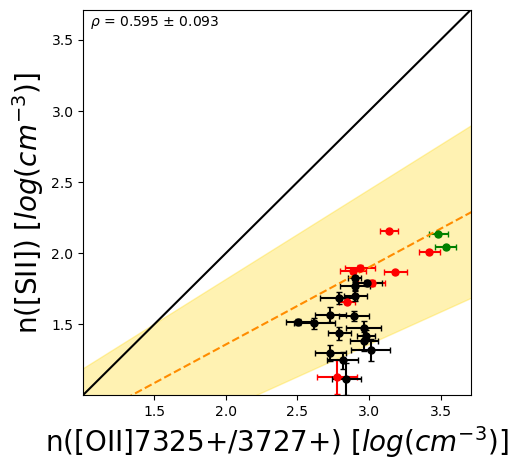

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}

mark_s = 5

### t^2 versus n([OII]) - n([SII])

oii_log = np.log10(strong_data['OII_DEN'])
oii_err = 1/np.log(10) * ((strong_data['OII_DEN_ERR']) / (strong_data['OII_DEN']))

sii_log = np.log10(strong_data['SII_DEN'])
sii_err = 1/np.log(10) * ((strong_data['SII_DEN_ERR']) / (strong_data['SII_DEN']))

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * oii_err) > snr) & (1 / (np.log(10) * sii_err) > snr))[0]

    axs.errorbar(oii_log[plot_ind], sii_log[plot_ind],
                 xerr = oii_err[plot_ind],
                 yerr= sii_err[plot_ind], 
                 c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)
    
    print(len(plot_ind))

plot_ind_1 = np.where((1 / (np.log(10) * oii_err) > snr) & (1 / (np.log(10) * sii_err) > snr))[0]

x, y = oii_log[plot_ind_1], sii_log[plot_ind_1]
x_err = oii_err[plot_ind_1]
y_err = sii_err[plot_ind_1]

axs.set_xlim(np.nanmin(np.concatenate([x, y]))*0.9, np.nanmax(np.concatenate([x, y]))*1.05)
axs.set_ylim(np.nanmin(np.concatenate([x, y]))*0.9, np.nanmax(np.concatenate([x, y]))*1.05)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs.plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='darkorange', linestyle='--')
axs.fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.3)

axs.text(1.05, 3.6, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

axs.plot(np.linspace(-2, 5, 100), np.linspace(-2, 5, 100), c='k')

axs.set_ylabel(r'n([SII]) [$log(cm^{-3})$]', fontsize = 20)
#axs.set_xlabel(r'log(n([OII]) - n([SII]))')
axs.set_xlabel(r'n([OII]7325+/3727+) [$log(cm^{-3})$]', fontsize = 20)
#axs.legend(loc='upper left')

### Compare t^2 with various quantities

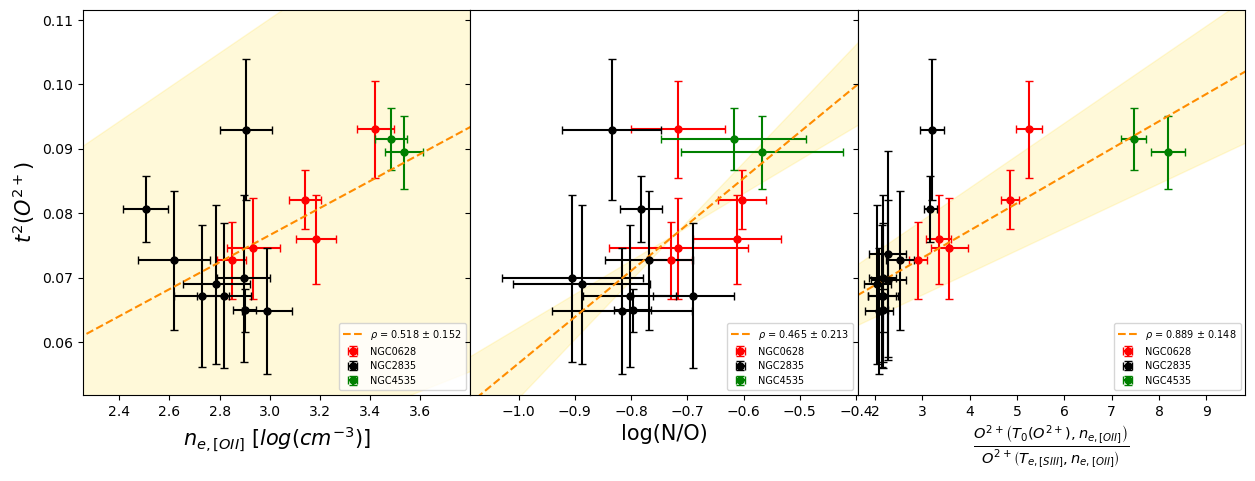

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1

### t^2 versus n([OII])

for k in range(2, len(galdic)+1):

    plot_ind_1 = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['t^2_MD23']/strong_data['t^2_MD23_ERR'] > snr) & (strong_data['OII_DEN']/strong_data['OII_DEN_ERR'] > snr))[0]

    if len(plot_ind_1) > 0:

        axs[0].errorbar(np.log10(strong_data['OII_DEN'][plot_ind_1]), strong_data['t^2_MD23'][plot_ind_1],
                    xerr = 1/np.log(10) * (strong_data['OII_DEN_ERR'][plot_ind_1]/strong_data['OII_DEN'][plot_ind_1]),
                    yerr= strong_data['t^2_MD23_ERR'][plot_ind_1], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_1 = np.where((strong_data['t^2_MD23']/strong_data['t^2_MD23_ERR'] > snr) & (strong_data['OII_DEN']/strong_data['OII_DEN_ERR'] > snr))[0]

axs[0].set_ylabel(r'$t^{2}(O^{2+})$', fontsize = 15)
axs[0].set_xlabel(r'$n_{e, [O II]}$ $[log(cm^{-3})]$', fontsize = 15)

x, y = np.log10(strong_data['OII_DEN'][plot_ind_1]), strong_data['t^2_MD23'][plot_ind_1]
x_err = 1/np.log(10) * (strong_data['OII_DEN_ERR'][plot_ind_1]/strong_data['OII_DEN'][plot_ind_1])
y_err = strong_data['t^2_MD23_ERR'][plot_ind_1]

axs[0].set_xlim(np.nanmin(x)*0.9, np.nanmax(x)*1.075)
axs[0].set_ylim(np.nanmin(y)*0.8, np.nanmax(y)*1.2)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[0].legend(loc='lower right', fontsize = 7)

### t^2 versus log(N/O)

for k in range(2, len(galdic)+1):

    plot_ind_2 = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['t^2_MD23']/strong_data['t^2_MD23_ERR'] > snr) & (1/ (np.log(10) * strong_data['N_T0_ERR']) > snr))[0]

    if len(plot_ind_2) > 0:

        axs[1].errorbar(strong_data['N_T0'][plot_ind_2], strong_data['t^2_MD23'][plot_ind_2],
                    xerr = strong_data['N_T0_ERR'][plot_ind_2],
                    yerr = strong_data['t^2_MD23_ERR'][plot_ind_2], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_2 = np.where((strong_data['t^2_MD23']/strong_data['t^2_MD23_ERR'] > snr) & (1/ (np.log(10) * strong_data['N_T0_ERR']) > snr))[0]

axs[1].set_xlabel(r'log(N/O)', fontsize = 15)

x, y = strong_data['N_T0'][plot_ind_2], strong_data['t^2_MD23'][plot_ind_2]
x_err = strong_data['N_T0_ERR'][plot_ind_2]
y_err = strong_data['t^2_MD23_ERR'][plot_ind_2]

axs[1].set_xlim(np.nanmin(x)*1.2, np.nanmax(x)*0.7)
axs[1].set_ylim(np.nanmin(y)*0.8, np.nanmax(y)*1.2)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].plot(np.linspace(-5, 10, 10), fit_coef + fit_slope*np.linspace(-5, 10, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].fill_between(np.linspace(-5, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-5, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-5, 10**11, 10),
                 color='gold', alpha=0.15)
axs[1].legend(loc='lower right', fontsize = 7)

### t^2 versus ADF proxy

adf_p = strong_data['O3_T0_OII'] / strong_data['O3_SIII_OII']
adf_p_err = np.sqrt((strong_data['O3_T0_OII_ERR'] / strong_data['O3_T0_OII'])**2 + (strong_data['O3_SIII_OII_ERR'] / strong_data['O3_SIII_OII'])**2)

for k in range(2, len(galdic)+1):

    plot_ind_3 = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['t^2_MD23']/strong_data['t^2_MD23_ERR'] > snr) & (adf_p/adf_p_err > snr))[0]

    if len(plot_ind_3) > 0:

        axs[2].errorbar(adf_p[plot_ind_3], strong_data['t^2_MD23'][plot_ind_3],
                    xerr = adf_p_err[plot_ind_3],
                    yerr= strong_data['t^2_MD23_ERR'][plot_ind_3], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_3 = np.where((strong_data['t^2_MD23']/strong_data['t^2_MD23_ERR'] > snr) & (adf_p/adf_p_err > snr))[0]

axs[2].set_xlabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [O II]}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [O II]}\right)}$', fontsize = 15)

x, y = adf_p[plot_ind_3], strong_data['t^2_MD23'][plot_ind_3]
x_err = adf_p_err[plot_ind_3]
y_err = strong_data['t^2_MD23_ERR'][plot_ind_3]

axs[2].set_xlim(np.nanmin(x)*0.8, np.nanmax(x)*1.2)
axs[2].set_ylim(np.nanmin(y)*0.8, np.nanmax(y)*1.2)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[2].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[2].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[2].legend(loc='lower right', fontsize = 7)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Plot ADF proxy versus log(N/O)

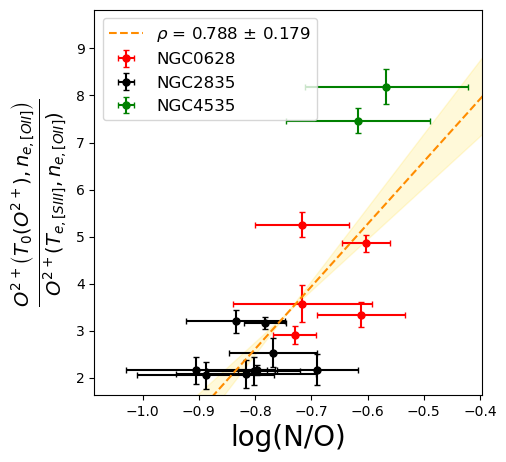

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}

### t^2 versus n([OII]) - n([SII])

mark_s = 5
cap_s = 2
a_val = 1


den_log = strong_data['O3_T0_OII'] / strong_data['O3_SIII_OII']
#den_err = 1/np.log(10) * (np.sqrt((strong_data['OH_T0_ERR'] / strong_data[var])**2 + (strong_data['SII_DEN_ERR'] / strong_data['SII_DEN'])**2))
den_err = np.sqrt((strong_data['O3_T0_OII_ERR'] / strong_data['O3_T0_OII'])**2 + (strong_data['O3_SIII_OII_ERR'] / strong_data['O3_SIII_OII'])**2)

var = 'OIII_TEMP_B12'

#den_log = np.log10(strong_data[var])
#den_err = 1/np.log(10) * (strong_data[var+'_ERR'] / strong_data[var])
#den_err = U_param_o_err #strong_data[var + '_ERR']

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (den_log/den_err > snr) & (1 / (np.log(10) * strong_data['N_T0_ERR']) > snr))[0]

    if len(plot_ind) > 0:

        axs.errorbar(strong_data['N_T0'][plot_ind], den_log[plot_ind],
                    yerr = den_err[plot_ind],
                    xerr=strong_data['N_T0_ERR'][plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

plot_ind_1 = np.where((den_log/den_err > snr) & (1 / (np.log(10) * strong_data['N_T0_ERR']) > snr))[0]

x, y = np.array(strong_data['N_T0'][plot_ind_1]), den_log[plot_ind_1]
x_err = np.array(strong_data['N_T0_ERR'][plot_ind_1])
y_err = den_err[plot_ind_1]

axs.set_xlim(np.nanmin(x)*1.2, np.nanmax(x)*0.7)
axs.set_ylim(np.nanmin(y)*0.8, np.nanmax(y)*1.2)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs.plot(np.linspace(-5, 10**11, 10), fit_coef + fit_slope*np.linspace(-5, 10**11, 10), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs.fill_between(np.linspace(-5, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-5, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-5, 10**11, 10),
                 color='gold', alpha=0.15)

axs.set_ylabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [O II]}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [O II]}\right)}$', fontsize = 20)

axs.set_xlabel(r'log(N/O)', fontsize = 20)
#axs.set_xlabel(r"log($\eta^{'}$)")
#axs.set_xlabel(r'12 + $log(O^{+}/H^{+})$ (Benchmark)')
#axs.set_xlabel(r'$n_{e, [O II]}$ - $n_{e, [S II]}$ $[log(cm^{-3})]$')
axs.legend(loc='upper left', fontsize=12)

### Comapre [OIII]/[OII] and [SIII]/[SII]

/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


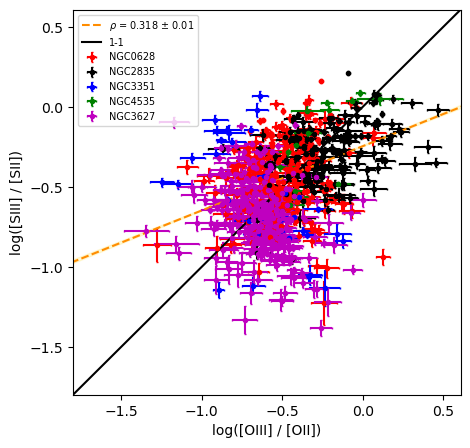

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s = 3
cap_s = 1

U_param_o = np.log10(np.array((strong_data['OIII5006_FLUX_CORR'] * 4/3) / strong_data['OII3727_FLUX_CORR']))
U_param_o_err = 1/np.log(10) * np.sqrt(np.array((strong_data['OIII5006_FLUX_CORR_ERR'] / strong_data['OIII5006_FLUX_CORR'])**2 + (strong_data['OII3727_FLUX_CORR_ERR'] / strong_data['OII3727_FLUX_CORR'])**2))

U_param_s = np.log10(np.array((strong_data['SIII9068_FLUX_CORR'] * 2.47) / (strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR'])))
U_param_s_err = 1/np.log(10) * np.sqrt(np.array((strong_data['SIII9068_FLUX_CORR_ERR'] / strong_data['SIII9068_FLUX_CORR'])**2 + ((np.sqrt(strong_data['SII6716_FLUX_CORR_ERR']**2 + strong_data['SII6730_FLUX_CORR_ERR']**2))/ (strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR']))))

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) *U_param_o_err) > snr) & (1 / (np.log(10) * U_param_s_err) > snr) & (strong_data['OII3727_FLUX_CORR']/strong_data['OII3727_FLUX_CORR_ERR'] > snr))[0]

    axs.errorbar(U_param_o[plot_ind], U_param_s[plot_ind],
                 xerr = U_param_o_err[plot_ind],
                 yerr = U_param_s_err[plot_ind], 
                 c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                 label=f'{galdic[k]}')

plot_ind_1 = np.where((1 / (np.log(10) *U_param_o_err) > snr) & (1 / (np.log(10) * U_param_s_err) > snr) & (strong_data['OII3727_FLUX_CORR']/strong_data['OII3727_FLUX_CORR_ERR'] > snr))[0]

x, y = U_param_o[plot_ind_1], U_param_s[plot_ind_1]
x_err = U_param_o_err[plot_ind_1]
y_err = U_param_s_err[plot_ind_1]

min, max = np.min(np.concatenate([x,y])), np.max(np.concatenate([x,y]))

updown = 1.3
axs.set_xlim(min*updown, max*updown)
axs.set_ylim(min*updown, max*updown)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs.plot(np.linspace(-2, 2, 100), fit_coef + fit_slope*np.linspace(-2, 2, 100), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs.fill_between(np.linspace(-2, 2, 100), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-2, 2, 100), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-2, 2, 100),
                 color='gold', alpha=0.15)

axs.plot(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10), c='k', label='1-1')

#axs.set_xscale('log')
#axs.set_yscale('log')

axs.set_ylabel(r'log([SIII] / [SII])')
axs.set_xlabel(r'log([OIII] / [OII])')
axs.legend(loc='upper left', fontsize = 7)

### Compare temperature difference with ionization parameter

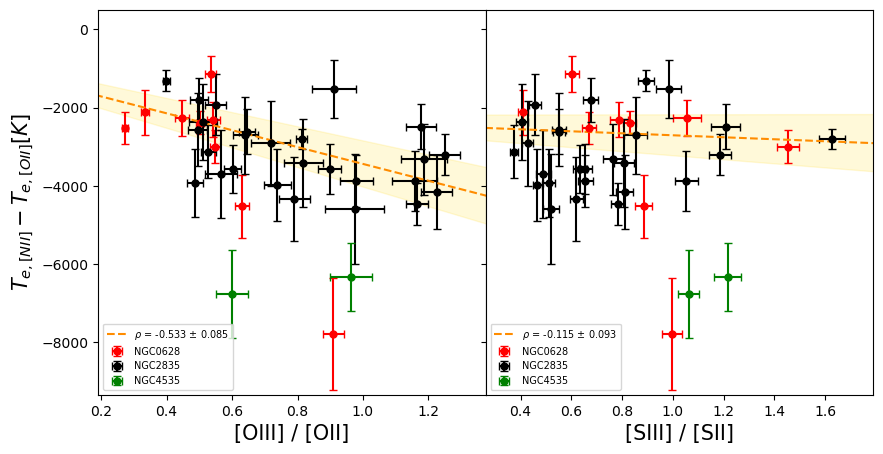

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1

U_param_o = np.array((strong_data['OIII5006_FLUX_CORR'] * 4/3) / strong_data['OII3727_FLUX_CORR'])
U_param_o_err = U_param_o * np.sqrt(np.array((strong_data['OIII5006_FLUX_CORR_ERR'] / strong_data['OIII5006_FLUX_CORR'])**2 + (strong_data['OII3727_FLUX_CORR_ERR'] / strong_data['OII3727_FLUX_CORR'])**2))

U_param_s = np.array((strong_data['SIII9068_FLUX_CORR'] * 2.47) / (strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR']))
U_param_s_err = U_param_s * np.sqrt(np.array((strong_data['SIII9068_FLUX_CORR_ERR'] / strong_data['SIII9068_FLUX_CORR'])**2 + ((np.sqrt(strong_data['SII6716_FLUX_CORR_ERR']**2 + strong_data['SII6730_FLUX_CORR_ERR']**2))/ (strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR']))))

temp_diff = np.array(strong_data['NII_TEMP'] - strong_data['OII_TEMP'])
temp_diff_err = np.array(np.sqrt(strong_data['NII_TEMP_ERR']**2 + strong_data['OII_TEMP_ERR']**2))

### Oxygen ionization parameter

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr))[0]

    if len(plot_ind) > 0:

        axs[0].errorbar(U_param_o[plot_ind], temp_diff[plot_ind],
                    xerr = U_param_o_err[plot_ind],
                    yerr=temp_diff_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_1 = np.where((strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr))[0]

axs[0].set_ylabel(r'$T_{e, [N II]} - T_{e, [O II]} [K]$', fontsize = 15)
axs[0].set_xlabel(r'[OIII] / [OII]', fontsize = 15)

x, y = U_param_o[plot_ind_1], temp_diff[plot_ind_1]
x_err = U_param_o_err[plot_ind_1]
y_err = temp_diff_err[plot_ind_1]

axs[0].set_xlim(np.nanmin(x)*0.7, np.nanmax(x)*1.1)
axs[0].set_ylim(np.nanmin(y)*1.2, 500)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[0].legend(loc='lower left', fontsize = 7)

### Sulfur ionization parameter

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr))[0]

    if len(plot_ind) > 0:

        axs[1].errorbar(U_param_s[plot_ind], temp_diff[plot_ind],
                    xerr = U_param_s_err[plot_ind],
                    yerr=temp_diff_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_2 = np.where((strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr))[0]

axs[1].set_xlabel(r'[SIII] / [SII]', fontsize = 15)

x, y = U_param_s[plot_ind_2], temp_diff[plot_ind_2]
x_err = U_param_s_err[plot_ind_2]
y_err = temp_diff_err[plot_ind_2]

axs[1].set_xlim(np.nanmin(x)*0.7, np.nanmax(x)*1.1)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[1].text(0.29, -9000, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', label = r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[1].legend(loc='lower left', fontsize = 7)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Compare eta with direct temperatures

/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


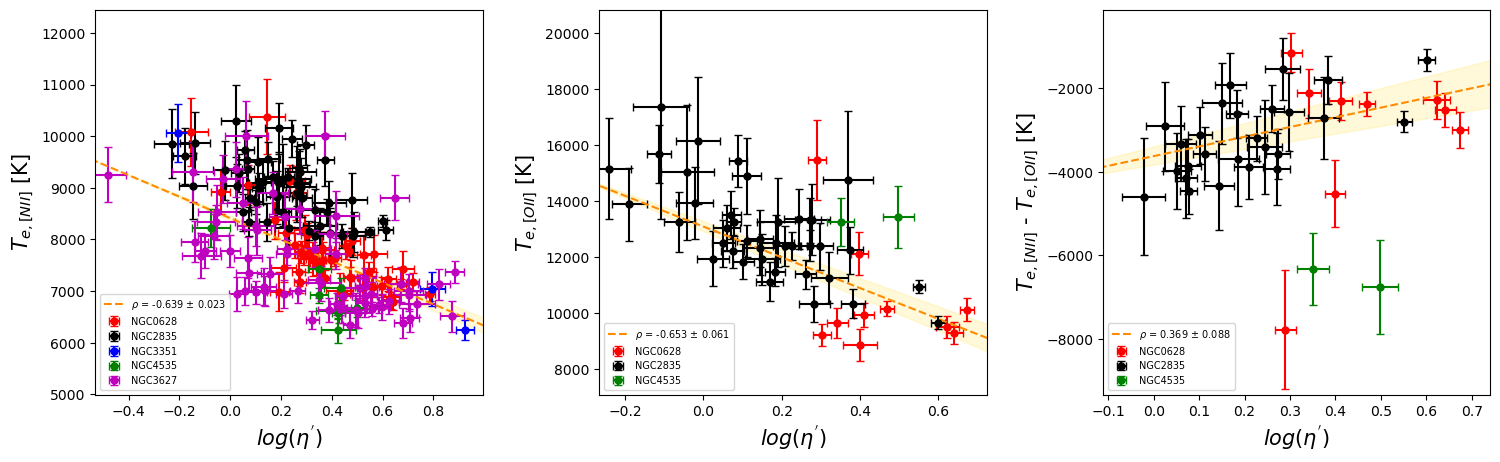

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1

n_eta = np.array((np.array(strong_data['OII3727_FLUX_CORR'])/ np.array(strong_data['OIII5006_FLUX_CORR']) * 4/3))
n_eta_err = n_eta * np.sqrt(np.array((strong_data['OIII5006_FLUX_CORR_ERR'] / strong_data['OIII5006_FLUX_CORR'])**2 + (strong_data['OII3727_FLUX_CORR_ERR'] / strong_data['OII3727_FLUX_CORR'])**2))

d_eta = (np.array(strong_data['SII6716_FLUX_CORR']) + np.array(strong_data['SII6730_FLUX_CORR'])) / (np.array(strong_data['SIII9068_FLUX_CORR']) * 2.47)
d_eta_err = d_eta * np.sqrt(np.array((strong_data['SIII9068_FLUX_CORR_ERR'] / strong_data['SIII9068_FLUX_CORR'])**2 + ((np.sqrt(strong_data['SII6716_FLUX_CORR_ERR']**2 + strong_data['SII6730_FLUX_CORR_ERR']**2))/ (strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR']))))

eta_p = np.log10(n_eta / d_eta)
eta_p_err = (1/np.log(10)) * np.sqrt((d_eta_err/d_eta)**2 + (n_eta_err/n_eta)**2)

temp_diff = strong_data['NII_TEMP'] - strong_data['OII_TEMP']
temp_diff_err = np.sqrt((strong_data['OII_TEMP_ERR']) ** 2 + (strong_data['NII_TEMP_ERR']) ** 2)

### eta prime versus Te([NII])

for k in range(2, len(galdic)+1):

    plot_ind_1 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * eta_p_err) > snr) & (strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr))[0]

    if len(plot_ind_1) > 0:

        axs[0].errorbar(eta_p[plot_ind_1], strong_data['NII_TEMP'][plot_ind_1],
                    xerr = eta_p_err[plot_ind_1],
                    yerr= strong_data['NII_TEMP_ERR'][plot_ind_1], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_1 = np.where((1 / (np.log(10) * eta_p_err) > snr) & (strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr))[0]

axs[0].set_xlabel(r"$log(\eta^{'})$", fontsize = 15)
axs[0].set_ylabel(r'$T_{e, [N II]}$ [K]', fontsize = 15)

x, y = eta_p[plot_ind_1], strong_data['NII_TEMP'][plot_ind_1]
x_err = eta_p_err[plot_ind_1]
y_err = strong_data['NII_TEMP_ERR'][plot_ind_1]

axs[0].set_xlim(np.nanmin(x)*1.1, np.nanmax(x)*1.075)
axs[0].set_ylim(np.nanmin(y)*0.8, np.nanmax(y)*1.2)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[0].legend(loc='lower left', fontsize = 7)

### eta prime versus Te([OII])

for k in range(2, len(galdic)+1):

    plot_ind_2 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * eta_p_err) > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr))[0]

    if len(plot_ind_2) > 0:

        axs[1].errorbar(eta_p[plot_ind_2], strong_data['OII_TEMP'][plot_ind_2],
                    xerr = eta_p_err[plot_ind_2],
                    yerr= strong_data['OII_TEMP_ERR'][plot_ind_2], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_2 = np.where((1 / (np.log(10) * eta_p_err) > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr))[0]

axs[1].set_xlabel(r"$log(\eta^{'})$", fontsize = 15)
axs[1].set_ylabel(r'$T_{e, [O II]}$ [K]', fontsize = 15)

x, y = eta_p[plot_ind_2], strong_data['OII_TEMP'][plot_ind_2]
x_err = eta_p_err[plot_ind_2]
y_err = strong_data['OII_TEMP_ERR'][plot_ind_2]

axs[1].set_xlim(np.nanmin(x)*1.1, np.nanmax(x)*1.075)
axs[1].set_ylim(np.nanmin(y)*0.8, np.nanmax(y)*1.2)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[1].legend(loc='lower left', fontsize = 7)

### eta prime versus T([NII]) - T([OII])

for k in range(2, len(galdic)+1):

    plot_ind_3 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * eta_p_err) > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr) & (strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr))[0]

    if len(plot_ind_3) > 0:

        axs[2].errorbar(eta_p[plot_ind_3], temp_diff[plot_ind_3],
                    xerr = eta_p_err[plot_ind_3],
                    yerr= temp_diff_err[plot_ind_3], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, label=f'{galdic[k]}')

plot_ind_3 = np.where((1 / (np.log(10) * eta_p_err) > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr) & (strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr))[0]

axs[2].set_xlabel(r"$log(\eta^{'})$", fontsize = 15)
axs[2].set_ylabel(r'$T_{e, [N II]}$ - $T_{e, [O II]}$ [K]', fontsize = 15)

x, y = eta_p[plot_ind_3], temp_diff[plot_ind_3]
x_err = eta_p_err[plot_ind_3]
y_err = temp_diff_err[plot_ind_3]

axs[2].set_xlim(np.nanmin(x)*5, np.nanmax(x)*1.1)
axs[2].set_ylim(np.nanmin(y)*1.2, np.nanmax(y)*0.1)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.22, -9000, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[2].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[2].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[2].legend(loc='lower left', fontsize = 7)

plt.subplots_adjust(wspace=0.3, hspace=0)
plt.show()

### Compare temperatures, color coated with ionization parameter

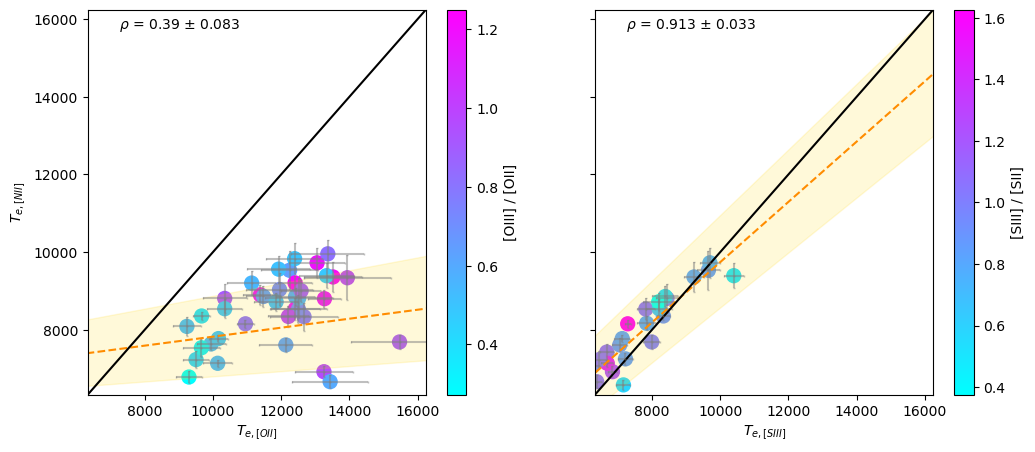

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 1, 1, 0.5

U_param_o = np.array((strong_data['OIII5006_FLUX_CORR'] * 4/3) / strong_data['OII3727_FLUX_CORR'])
U_param_o_err = U_param_o * np.sqrt(np.array((strong_data['OIII5006_FLUX_CORR_ERR'] / strong_data['OIII5006_FLUX_CORR'])**2 + (strong_data['OII3727_FLUX_CORR_ERR'] / strong_data['OII3727_FLUX_CORR'])**2))

U_param_s = np.array((strong_data['SIII9068_FLUX_CORR'] * 2.47) / (strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR']))
U_param_s_err = U_param_s * np.sqrt(np.array((strong_data['SIII9068_FLUX_CORR_ERR'] / strong_data['SIII9068_FLUX_CORR'])**2 + ((np.sqrt(strong_data['SII6716_FLUX_CORR_ERR']**2 + strong_data['SII6730_FLUX_CORR_ERR']**2))/ (strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR']))))

temp_diff = np.array(strong_data['NII_TEMP'] - strong_data['SIII_TEMP'])
temp_diff_err = np.array(np.sqrt(strong_data['NII_TEMP_ERR']**2 + strong_data['SIII_TEMP_ERR']**2))

### Oxygen ionization parameter

plot_ind_1 = np.where((strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr) & (strong_data['OII3727_FLUX_CORR']/strong_data['OII3727_FLUX_CORR_ERR'] > snr))[0]

axs[0].errorbar(strong_data['OII_TEMP'][plot_ind_1], strong_data['NII_TEMP'][plot_ind_1],
                    xerr = strong_data['OII_TEMP_ERR'][plot_ind_1],
                    yerr=strong_data['NII_TEMP_ERR'][plot_ind_1], 
                    c='gray', fmt=".", markersize=mark_s, capsize=cap_s, alpha=a_val)

sc1 = axs[0].scatter(strong_data['OII_TEMP'][plot_ind_1], strong_data['NII_TEMP'][plot_ind_1], c=U_param_o[plot_ind_1], cmap='cool', marker='o', s=100, alpha=1)

cbar1 = fig.colorbar(sc1, ax=axs[0])
cbar1.set_label('[OIII] / [OII]')


axs[0].set_ylabel(r'$T_{e, [N II]}$')
axs[0].set_xlabel(r'$T_{e, [O II]}$')

x, y = strong_data['OII_TEMP'][plot_ind_1], strong_data['NII_TEMP'][plot_ind_1]
x_err = strong_data['OII_TEMP_ERR'][plot_ind_1]
y_err = strong_data['NII_TEMP_ERR'][plot_ind_1]

axs[0].set_xlim(np.nanmin(np.concatenate([x, y]))*0.95, np.nanmax(np.concatenate([x, y]))*1.05)
axs[0].set_ylim(np.nanmin(np.concatenate([x, y]))*0.95, np.nanmax(np.concatenate([x, y]))*1.05)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[0].text(7250, 15750, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].plot(np.linspace(-1, 10**6, 10), fit_coef + fit_slope*np.linspace(-1, 10**6, 10), 
         c='darkorange', linestyle='--')
axs[0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[0].plot(np.linspace(-2, 10**5, 100), np.linspace(-2, 10**5, 100), c='k')

### Sulfur ionization parameter

plot_ind_2 = np.where((strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr) & (strong_data['SIII_TEMP']/strong_data['SIII_TEMP_ERR'] > snr))[0]
    
axs[1].errorbar(strong_data['SIII_TEMP'][plot_ind_2], strong_data['NII_TEMP'][plot_ind_2],
                    xerr = strong_data['SIII_TEMP_ERR'][plot_ind_2],
                    yerr=strong_data['NII_TEMP_ERR'][plot_ind_2], 
                    c='gray', fmt=".", markersize=mark_s, capsize=cap_s, alpha=a_val)

sc2 = axs[1].scatter(strong_data['SIII_TEMP'][plot_ind_2], strong_data['NII_TEMP'][plot_ind_2], c=U_param_s[plot_ind_2], cmap='cool', marker='o', s=100, alpha=1)

cbar2 = fig.colorbar(sc2, ax=axs[1])
cbar2.set_label('[SIII] / [SII]')

axs[1].set_xlabel(r'$T_{e, [S III]}$')

axs[1].set_xlim(np.nanmin(np.concatenate([x, y]))*0.95, np.nanmax(np.concatenate([x, y]))*1.05)

x, y = strong_data['SIII_TEMP'][plot_ind_2], strong_data['NII_TEMP'][plot_ind_2]
x_err = strong_data['SIII_TEMP_ERR'][plot_ind_2]
y_err = strong_data['NII_TEMP_ERR'][plot_ind_2]

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[1].text(7250, 15750, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].plot(np.linspace(-1, 10**6, 10), fit_coef + fit_slope*np.linspace(-1, 10**6, 10), 
         c='darkorange', linestyle='--')
axs[1].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[1].plot(np.linspace(-2, 10**5, 100), np.linspace(-2, 10**5, 100), c='k')

#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Compare densities, color coated with ionization parameter

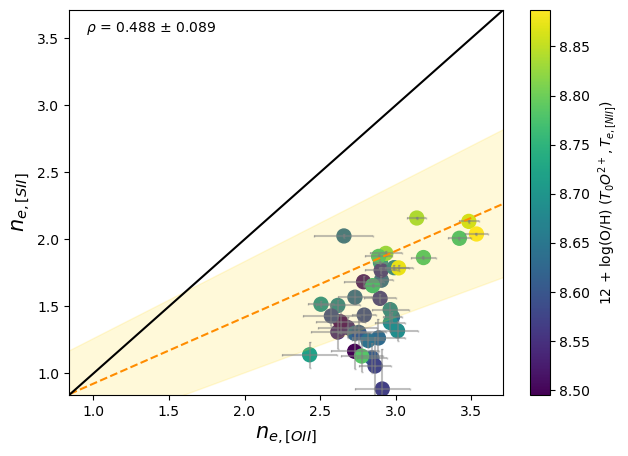

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5), sharey=True)

snr = 1
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 1, 1, 0.5

### Oxygen ionization parameter

plot_ind_1 = np.where((strong_data['SII_DEN']/strong_data['SII_DEN_ERR'] > snr) & (strong_data['OII_DEN']/strong_data['OII_DEN_ERR'] > snr))[0]

axs.errorbar(np.log10(strong_data['OII_DEN'][plot_ind_1]), np.log10(strong_data['SII_DEN'][plot_ind_1]),
             xerr = 1/np.log(10) * (strong_data['OII_DEN_ERR'][plot_ind_1] / strong_data['OII_DEN'][plot_ind_1]),
             yerr=1/np.log(10) * (strong_data['SII_DEN_ERR'][plot_ind_1] / strong_data['SII_DEN'][plot_ind_1]), 
                    c='gray', fmt=".", markersize=mark_s, capsize=cap_s, alpha=a_val)

sc1 = axs.scatter(np.log10(strong_data['OII_DEN'][plot_ind_1]), np.log10(strong_data['SII_DEN'][plot_ind_1]), c=strong_data['met_md23'][plot_ind_1], cmap='viridis', marker='o', s=100, alpha=1)

cbar1 = fig.colorbar(sc1, ax=axs)
cbar1.set_label('12 + log(O/H) 'r'$(T_{0}{O^{2+}}, T_{e, [NII]})$')


axs.set_ylabel(r'$n_{e, [S II]}$', fontsize=15)
axs.set_xlabel(r'$n_{e, [O II]}$', fontsize=15)

x, y = np.log10(strong_data['OII_DEN'][plot_ind_1]), np.log10(strong_data['SII_DEN'][plot_ind_1])
x_err = 1/np.log(10) * (strong_data['OII_DEN_ERR'][plot_ind_1] / strong_data['OII_DEN'][plot_ind_1])
y_err = 1/np.log(10) * (strong_data['SII_DEN_ERR'][plot_ind_1] / strong_data['SII_DEN'][plot_ind_1])

axs.set_xlim(np.nanmin(np.concatenate([x, y]))*0.95, np.nanmax(np.concatenate([x, y]))*1.05)
axs.set_ylim(np.nanmin(np.concatenate([x, y]))*0.95, np.nanmax(np.concatenate([x, y]))*1.05)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs.text(0.95, 3.55, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs.plot(np.linspace(-1, 10**6, 10), fit_coef + fit_slope*np.linspace(-1, 10**6, 10), 
         c='darkorange', linestyle='--')
axs.fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs.plot(np.linspace(-2, 10**5, 100), np.linspace(-2, 10**5, 100), c='k')

#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Compare [OII] and [NII] color coated by metallicity

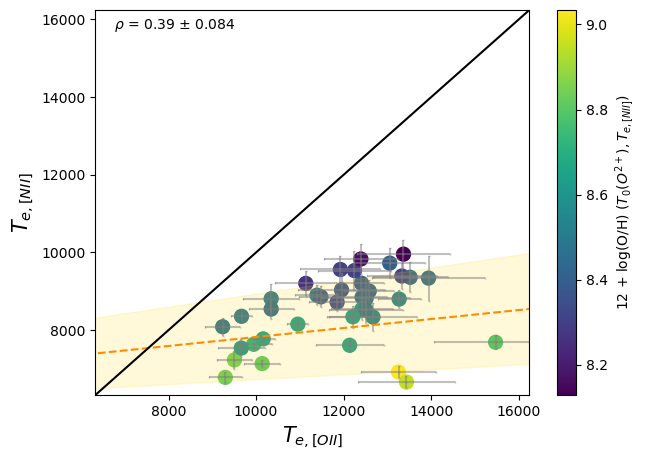

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5), sharey=True)

snr = 9.5
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 1, 1, 0.5

### Oxygen ionization parameter

plot_ind_1 = np.where((strong_data['NII_TEMP']/strong_data['NII_TEMP_ERR'] > snr) & (strong_data['OII_TEMP']/strong_data['OII_TEMP_ERR'] > snr))[0]

axs.errorbar(strong_data['OII_TEMP'][plot_ind_1], strong_data['NII_TEMP'][plot_ind_1],
             xerr = strong_data['OII_TEMP_ERR'][plot_ind_1],
             yerr=strong_data['NII_TEMP_ERR'][plot_ind_1], 
                    c='gray', fmt=".", markersize=mark_s, capsize=cap_s, alpha=a_val)

sc1 = axs.scatter(strong_data['OII_TEMP'][plot_ind_1], strong_data['NII_TEMP'][plot_ind_1], c=strong_data['OH_T0_OII'][plot_ind_1], cmap='viridis', marker='o', s=100, alpha=1)

cbar1 = fig.colorbar(sc1, ax=axs)
cbar1.set_label('12 + log(O/H) 'r'$(T_{0}(O^{2+}), T_{e, [NII]})$')


axs.set_ylabel(r'$T_{e, [N II]}$', fontsize=15)
axs.set_xlabel(r'$T_{e, [O II]}$', fontsize=15)

x, y = strong_data['OII_TEMP'][plot_ind_1], strong_data['NII_TEMP'][plot_ind_1]
x_err = strong_data['OII_TEMP_ERR'][plot_ind_1]
y_err = strong_data['NII_TEMP_ERR'][plot_ind_1]

axs.set_xlim(np.nanmin(np.concatenate([x, y]))*0.95, np.nanmax(np.concatenate([x, y]))*1.05)
axs.set_ylim(np.nanmin(np.concatenate([x, y]))*0.95, np.nanmax(np.concatenate([x, y]))*1.05)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs.text(6750, 15750, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs.plot(np.linspace(-1, 10**6, 10), fit_coef + fit_slope*np.linspace(-1, 10**6, 10), 
         c='darkorange', linestyle='--')
axs.fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs.plot(np.linspace(-2, 10**5, 100), np.linspace(-2, 10**5, 100), c='k')

#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Plot log(N/O) versus eta

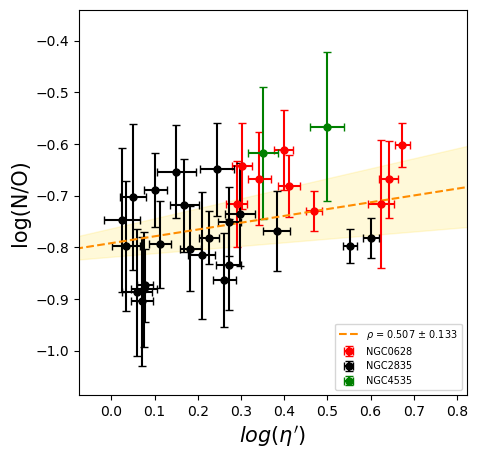

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1

### t^2 versus n([OII]) - n([SII])

tsquare = strong_data['N_T0']
tsquare_err = strong_data['N_T0_ERR']

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * tsquare_err) > snr) & (1 / (np.log(10) * eta_p_err) > snr))[0]

    if len(plot_ind) > 0:

        axs.errorbar(eta_p[plot_ind], tsquare[plot_ind],
                    yerr = tsquare_err[plot_ind],
                    xerr = eta_p_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((1 / (np.log(10) * tsquare_err) > snr) & (1 / (np.log(10) * eta_p_err) > snr))[0]

x, y = eta_p[plot_ind_1], tsquare[plot_ind_1]
x_err = eta_p_err[plot_ind_1]
y_err = tsquare_err[plot_ind_1]

axs.set_xlim(-np.nanmin(x)*3, np.nanmax(x)*1.22)
axs.set_ylim(np.nanmin(y)*1.2, np.nanmax(y)*0.6)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs.plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs.fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)

#axs.set_ylabel(r"$T_{e, [NII]}$ [K]", fontsize = 15)
axs.set_ylabel(r"log(N/O)", fontsize = 15)
axs.set_xlabel(r"$log(\eta')$", fontsize = 15)
axs.legend(loc='lower right', fontsize=7)

### Plot O++ (T0) / O++ (T([SIII])) versus log(n')

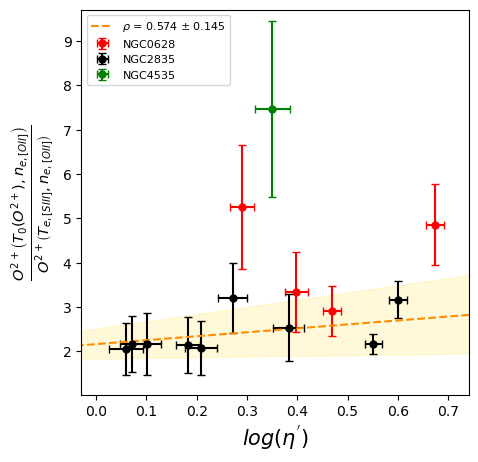

In [39]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}

### t^2 versus n([OII]) - n([SII])

adf = strong_data['O3_T0_OII'] / strong_data['O3_SIII_OII']
adf_err = adf * np.sqrt((strong_data['O3_T0_OII_ERR'] / strong_data['O3_T0_OII'])**2 + (strong_data['O3_SIII_OII_ERR'] / strong_data['O3_SIII_OII'])**2)

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (adf / adf_err > snr) & (1 / (np.log(10) * eta_p_err) > snr))[0]

    if len(plot_ind) > 0:

        axs.errorbar(eta_p[plot_ind], adf[plot_ind],
                    yerr = adf_err[plot_ind],
                    xerr = eta_p_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((adf / adf_err > snr) & (1 / (np.log(10) * eta_p_err) > snr))[0]

x, y = eta_p[plot_ind_1], adf[plot_ind_1]
x_err = eta_p_err[plot_ind_1]
y_err = adf_err[plot_ind_1]

axs.set_xlim(np.nanmin(x)*0.5*-1, np.nanmax(x)*1.1)
axs.set_ylim(np.nanmin(y)*0.5, np.nanmax(y)*1.3)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs.plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs.fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)

axs.set_xlabel(r"$log(\eta^{'})$", fontsize = 15)
axs.set_ylabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [O II]}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [O II]}\right)}$', fontsize = 15)
axs.legend(loc='upper left', fontsize=8)

### Plot O++ (T0) / O++ (T([SIII])) versus densities

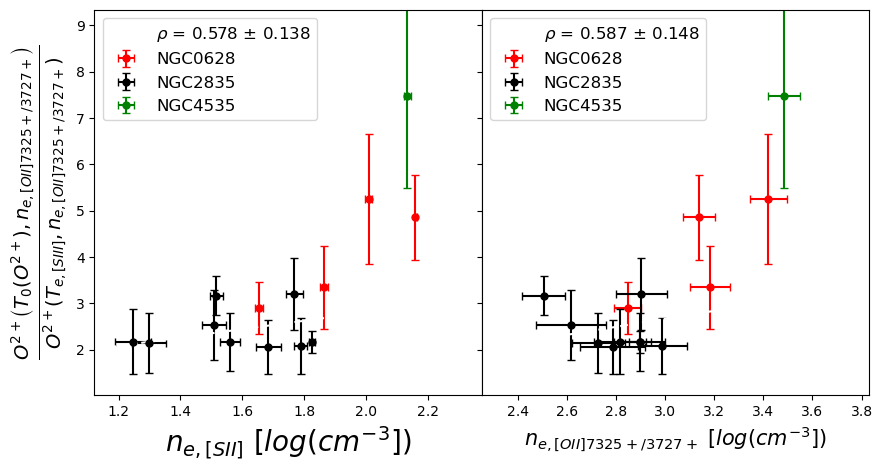

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1

adf = np.array(strong_data['O3_T0_OII'] / strong_data['O3_SIII_OII'])
adf_err = adf * np.sqrt((strong_data['O3_T0_OII_ERR'] / strong_data['O3_T0_OII'])**2 + (strong_data['O3_SIII_OII_ERR'] / strong_data['O3_SIII_OII'])**2)

den = np.array(np.log10(strong_data['SII_DEN']))
den_err = np.array(1/np.log(10) * (strong_data['SII_DEN_ERR'] / strong_data['SII_DEN']))

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (adf / adf_err > snr) & (1 / (np.log(10) * den_err) > snr))[0]

    if len(plot_ind) > 0:

        axs[0].errorbar(den[plot_ind], adf[plot_ind],
                    yerr = adf_err[plot_ind],
                    xerr = den_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((adf / adf_err > snr) & (1 / (np.log(10) * den_err) > snr))[0]

x, y = den[plot_ind_1], adf[plot_ind_1]
x_err = den_err[plot_ind_1]
y_err = adf_err[plot_ind_1]

axs[0].set_xlim(np.nanmin(x)*0.9, np.nanmax(x)*1.1)
axs[0].set_ylim(np.nanmin(y)*0.5, np.nanmax(y)*1.25)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[0].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='white', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

#axs[0].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
 #        c='darkorange', linestyle='--', 
  #       label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
#axs[0].fill_between(np.linspace(-1, 10**11, 10), 
 #                (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
  #               (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
   #              color='gold', alpha=0.15)

axs[0].set_xlabel(r"$n_{e, [S II]}$ $[log(cm^{-3}]$)", fontsize = 20)
axs[0].set_ylabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [O II]7325+/3727+}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [O II]7325+/3727+}\right)}$', fontsize = 20)
axs[0].legend(loc='upper left', fontsize=12)

den = np.array(np.log10(strong_data['OII_DEN']))
den_err = np.array(1/np.log(10) * (strong_data['OII_DEN_ERR'] / strong_data['OII_DEN']))

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (adf / adf_err > snr) & (1 / (np.log(10) * den_err) > snr))[0]

    if len(plot_ind) > 0:

        axs[1].errorbar(den[plot_ind], adf[plot_ind],
                    yerr = adf_err[plot_ind],
                    xerr = den_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((adf / adf_err > snr) & (1 / (np.log(10) * den_err) > snr))[0]

x, y = den[plot_ind_1], adf[plot_ind_1]
x_err = den_err[plot_ind_1]
y_err = adf_err[plot_ind_1]

axs[1].set_xlim(np.nanmin(x)*0.9, np.nanmax(x)*1.1)
axs[1].set_ylim(np.nanmin(y)*0.5, np.nanmax(y)*1.25)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[1].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='white', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

#axs[1].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
 #        c='darkorange', linestyle='--', 
  #       label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
#axs[1].fill_between(np.linspace(-1, 10**11, 10), 
 #                (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
  #               (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
   #              color='gold', alpha=0.15)

axs[1].set_xlabel(r"$n_{e, [O II]7325+/3727+}$ $[log(cm^{-3}]$)", fontsize = 15)
#axs[1].set_ylabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [O II]}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [O II]}\right)}$', fontsize = 15)
axs[1].legend(loc='upper left', fontsize=12)


plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### ADF proxy versus a bunch of different parameters

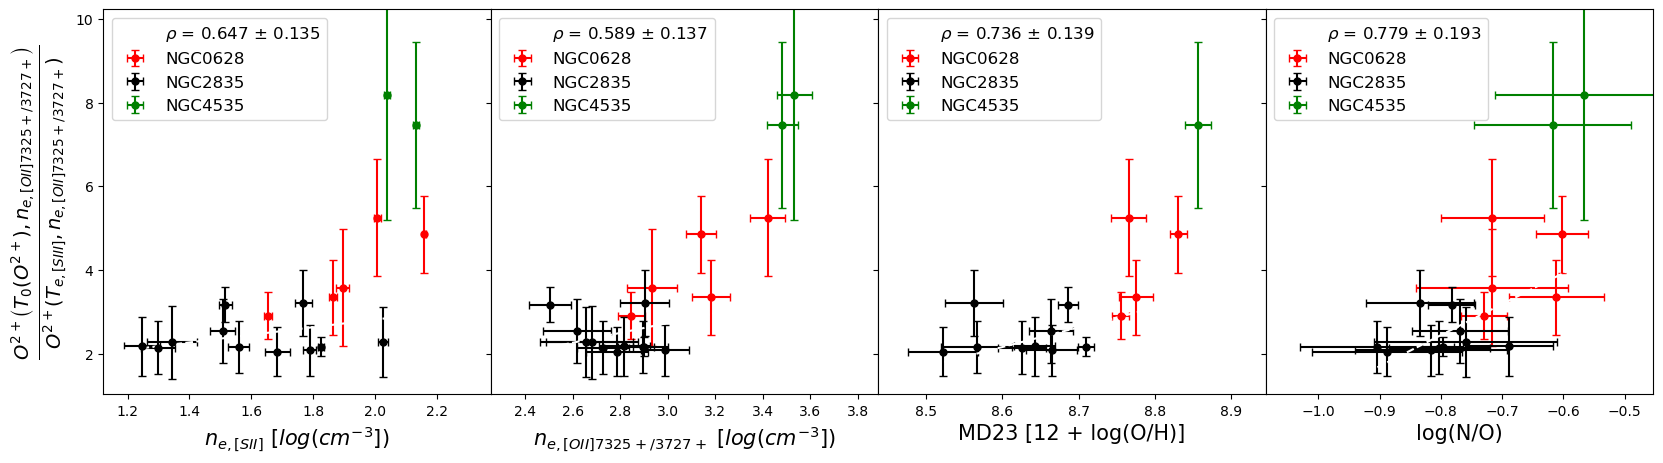

In [41]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

snr = 2
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1
label_size = 15

adf = np.array(strong_data['O3_T0_OII'] / strong_data['O3_SIII_OII'])
adf_err = adf * np.sqrt((strong_data['O3_T0_OII_ERR'] / strong_data['O3_T0_OII'])**2 + (strong_data['O3_SIII_OII_ERR'] / strong_data['O3_SIII_OII'])**2)

den = np.array(np.log10(strong_data['SII_DEN']))
den_err = np.array(1/np.log(10) * (strong_data['SII_DEN_ERR'] / strong_data['SII_DEN']))

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (adf / adf_err > snr) & (1 / (np.log(10) * den_err) > snr))[0]

    if len(plot_ind) > 0:

        axs[0].errorbar(den[plot_ind], adf[plot_ind],
                    yerr = adf_err[plot_ind],
                    xerr = den_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((adf / adf_err > snr) & (1 / (np.log(10) * den_err) > snr))[0]

x, y = den[plot_ind_1], adf[plot_ind_1]
x_err = den_err[plot_ind_1]
y_err = adf_err[plot_ind_1]

axs[0].set_xlim(np.nanmin(x)*0.9, np.nanmax(x)*1.1)
axs[0].set_ylim(np.nanmin(y)*0.5, np.nanmax(y)*1.25)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[0].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='white', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

#axs[0].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
 #        c='darkorange', linestyle='--', 
  #       label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
#axs[0].fill_between(np.linspace(-1, 10**11, 10), 
 #                (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
  #               (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
   #              color='gold', alpha=0.15)

axs[0].set_xlabel(r"$n_{e, [S II]}$ $[log(cm^{-3}]$)", fontsize = label_size)
axs[0].set_ylabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [O II]7325+/3727+}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [O II]7325+/3727+}\right)}$', fontsize = label_size + 5)
axs[0].legend(loc='upper left', fontsize=12)

den = np.array(np.log10(strong_data['OII_DEN']))
den_err = np.array(1/np.log(10) * (strong_data['OII_DEN_ERR'] / strong_data['OII_DEN']))

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (adf / adf_err > snr) & (1 / (np.log(10) * den_err) > snr))[0]

    if len(plot_ind) > 0:

        axs[1].errorbar(den[plot_ind], adf[plot_ind],
                    yerr = adf_err[plot_ind],
                    xerr = den_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((adf / adf_err > snr) & (1 / (np.log(10) * den_err) > snr))[0]

x, y = den[plot_ind_1], adf[plot_ind_1]
x_err = den_err[plot_ind_1]
y_err = adf_err[plot_ind_1]

axs[1].set_xlim(np.nanmin(x)*0.9, np.nanmax(x)*1.1)
axs[1].set_ylim(np.nanmin(y)*0.5, np.nanmax(y)*1.25)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[1].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='white', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

#axs[1].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
 #        c='darkorange', linestyle='--', 
  #       label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
#axs[1].fill_between(np.linspace(-1, 10**11, 10), 
 #                (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
  #               (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
   #              color='gold', alpha=0.15)

axs[1].set_xlabel(r"$n_{e, [O II]7325+/3727+}$ $[log(cm^{-3}]$)", fontsize = label_size)
#axs[1].set_ylabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [O II]}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [O II]}\right)}$', fontsize = 15)
axs[1].legend(loc='upper left', fontsize=12)

in_met = 'met_md23'

met = np.array(strong_data[in_met])
adf = np.array(strong_data['O3_T0_OII']) / np.array(strong_data['O3_SIII_OII'])

met_err = np.array(strong_data[in_met + '_err'])
adf_err = adf * np.sqrt( ( np.array(strong_data['O3_T0_OII_ERR']) / np.array(strong_data['O3_T0_OII']) )**2 + ( np.array(strong_data['O3_SIII_OII_ERR']) / np.array(strong_data['O3_SIII_OII']) )**2)

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * met_err) > 3) & (adf/adf_err > 3))[0]

    if len(plot_ind) > 0:

        axs[2].errorbar(met[plot_ind], adf[plot_ind],
                    yerr = adf_err[plot_ind],
                    xerr = met_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((1 / (np.log(10) * met_err) > 3) & (adf/adf_err > 3))[0]

x, y = met[plot_ind_1], adf[plot_ind_1]
x_err = met_err[plot_ind_1]
y_err = adf_err[plot_ind_1]

axs[2].set_xlim(np.nanmin(x)*0.99, np.nanmax(x)*1.01)
axs[2].set_ylim(np.nanmin(y)*0.5, np.nanmax(y)*1.25)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[2].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='white', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

#axs[1].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
 #        c='darkorange', linestyle='--', 
  #       label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
#axs[1].fill_between(np.linspace(-1, 10**11, 10), 
 #                (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
  #               (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
   #              color='gold', alpha=0.15)

axs[2].set_xlabel(r"MD23 [12 + log(O/H)]", fontsize = label_size)
#axs[1].set_ylabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [O II]}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [O II]}\right)}$', fontsize = 15)
axs[2].legend(loc='upper left', fontsize=12)

no = np.array(strong_data['N_T0'])
no_err = np.array(strong_data['N_T0_ERR'])

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (adf / adf_err > snr) & (1 / (np.log(10) * no_err) > snr))[0]

    if len(plot_ind) > 0:

        axs[3].errorbar(no[plot_ind], adf[plot_ind],
                    yerr = adf_err[plot_ind],
                    xerr = no_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f"{galdic[k]}")

plot_ind_1 = np.where((adf / adf_err > snr) & (1 / (np.log(10) * no_err) > snr))[0]

x, y = no[plot_ind_1], adf[plot_ind_1]
x_err = no_err[plot_ind_1]
y_err = adf_err[plot_ind_1]

axs[3].set_xlim(np.nanmin(x)*1.2, np.nanmax(x)*0.8)
axs[3].set_ylim(np.nanmin(y)*0.5, np.nanmax(y)*1.25)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[3].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
         c='white', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')

#axs[1].plot(np.linspace(-1, 10**11, 10), fit_coef + fit_slope*np.linspace(-1, 10**11, 10), 
 #        c='darkorange', linestyle='--', 
  #       label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
#axs[1].fill_between(np.linspace(-1, 10**11, 10), 
 #                (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
  #               (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
   #              color='gold', alpha=0.15)

axs[3].set_xlabel(r"log(N/O)", fontsize = label_size)
#axs[1].set_ylabel(r'$\frac{O^{2+} \left(T_{0}(O^{2+}), n_{e, [O II]}\right)}{O^{2+} \left(T_{e, [S III]}, n_{e, [O II]}\right)}$', fontsize = 15)
axs[3].legend(loc='upper left', fontsize=12)


plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Compare log(n') with each metallicity

/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


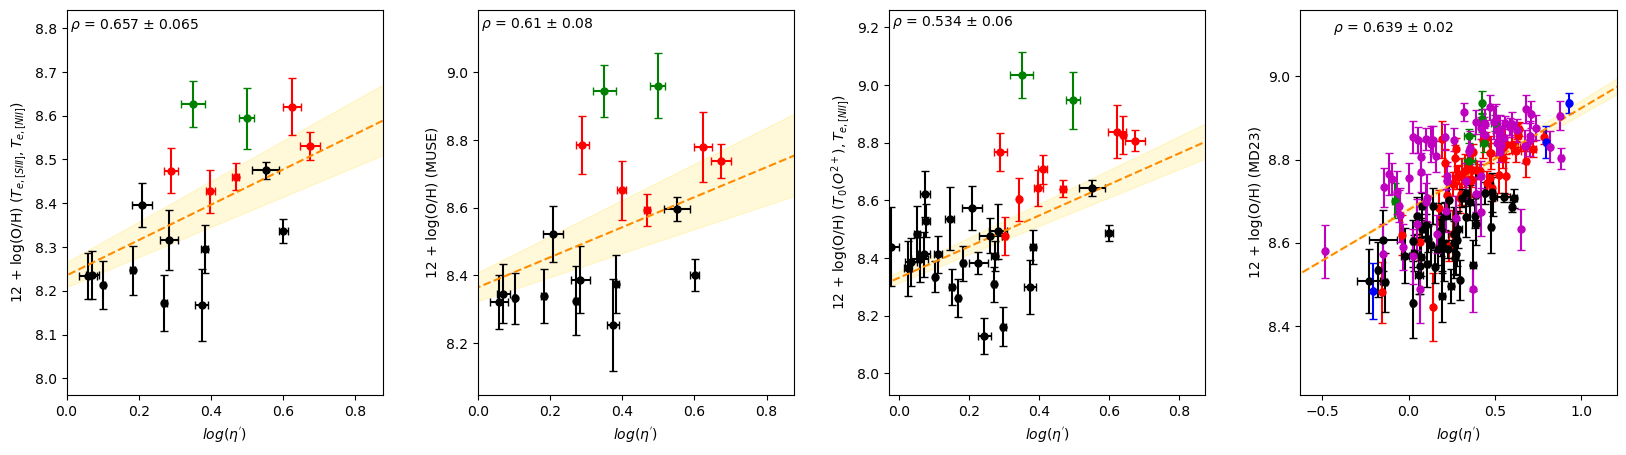

In [42]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=False)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1

n_eta = np.array((strong_data['OII3727_FLUX_CORR']/ strong_data['OIII5006_FLUX_CORR'] * 4/3))
n_eta_err = U_param_o * np.sqrt(np.array((strong_data['OIII5006_FLUX_CORR_ERR'] / strong_data['OIII5006_FLUX_CORR'])**2 + (strong_data['OII3727_FLUX_CORR_ERR'] / strong_data['OII3727_FLUX_CORR'])**2))

d_eta = np.array((strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR']) / (strong_data['SIII9068_FLUX_CORR'] * 2.47))
d_eta_err = U_param_s * np.sqrt(np.array((strong_data['SIII9068_FLUX_CORR_ERR'] / strong_data['SIII9068_FLUX_CORR'])**2 + ((np.sqrt(strong_data['SII6716_FLUX_CORR_ERR']**2 + strong_data['SII6730_FLUX_CORR_ERR']**2))/ (strong_data['SII6716_FLUX_CORR'] + strong_data['SII6730_FLUX_CORR']))))

eta_p = np.log10(n_eta / d_eta)
eta_p_err = (1/np.log(10)) * np.sqrt((d_eta_err/d_eta)**2 + (n_eta_err/n_eta)**2)

### T([SIII]), T([NII])

temp_diff = np.array(strong_data['OH_SIII_OII'])
temp_diff_err = np.array(strong_data['OH_SIII_OII_ERR'])

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_SIII_OII_ERR'])) > snr) & (strong_data['OII3727_FLUX_CORR']/strong_data['OII3727_FLUX_CORR_ERR'] > snr))[0]

    axs[0].errorbar(eta_p[plot_ind], temp_diff[plot_ind],
                    xerr = eta_p_err[plot_ind],
                    yerr=temp_diff_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

plot_ind_1 = np.where((1 / (np.log(10) * np.array(strong_data['OH_SIII_OII_ERR'])) > snr) & (strong_data['OII3727_FLUX_CORR']/strong_data['OII3727_FLUX_CORR_ERR'] > snr))[0]

axs[0].set_ylabel(r'12 + log(O/H) ($T_{e, [S III]}, T_{e, [N II]}$)')
axs[0].set_xlabel(r"$log(\eta^{'})$")

x, y = eta_p[plot_ind_1], temp_diff[plot_ind_1]
x_err = eta_p_err[plot_ind_1]
y_err = temp_diff_err[plot_ind_1]

axs[0].set_xlim(0, np.nanmax(x)*1.3)
axs[0].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[0].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--')
axs[0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)

### MUSE O/H

temp_diff = np.array(strong_data['OH_SIII_SII'])
temp_diff_err = np.array(strong_data['OH_SIII_SII_ERR'])

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (strong_data['OII3727_FLUX_CORR']/strong_data['OII3727_FLUX_CORR_ERR'] > snr))[0]

    axs[1].errorbar(eta_p[plot_ind], temp_diff[plot_ind],
                    xerr = eta_p_err[plot_ind],
                    yerr=temp_diff_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

plot_ind_1 = np.where((1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (strong_data['OII3727_FLUX_CORR']/strong_data['OII3727_FLUX_CORR_ERR'] > snr))[0]

axs[1].set_ylabel(r'12 + log(O/H) (MUSE)')
axs[1].set_xlabel(r"$log(\eta^{'})$")

x, y = eta_p[plot_ind_1], temp_diff[plot_ind_1]
x_err = eta_p_err[plot_ind_1]
y_err = temp_diff_err[plot_ind_1]

axs[1].set_xlim(0, np.nanmax(x)*1.3)
axs[1].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[1].text(0.01, np.nanmax(y)*1.019, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[1].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--')
axs[1].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)

### T0, T([NII])

temp_diff = np.array(strong_data['OH_T0_OII'])
temp_diff_err = np.array(strong_data['OH_T0_OII_ERR'])

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_T0_OII_ERR'])) > snr) & (strong_data['OII3727_FLUX_CORR']/strong_data['OII3727_FLUX_CORR_ERR'] > snr))[0]

    axs[2].errorbar(eta_p[plot_ind], temp_diff[plot_ind],
                    xerr = eta_p_err[plot_ind],
                    yerr=temp_diff_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

plot_ind_1 = np.where((1 / (np.log(10) * np.array(strong_data['OH_T0_OII_ERR'])) > snr) & (strong_data['OII3727_FLUX_CORR']/strong_data['OII3727_FLUX_CORR_ERR'] > snr))[0]

axs[2].set_ylabel(r'12 + log(O/H) ($T_{0}(O^{2+}), T_{e, [N II]}$)')
axs[2].set_xlabel(r"$log(\eta^{'})$")

x, y = eta_p[plot_ind_1], temp_diff[plot_ind_1]
x_err = eta_p_err[plot_ind_1]
y_err = temp_diff_err[plot_ind_1]

axs[2].set_xlim(np.nanmin(x)*1.3, np.nanmax(x)*1.3)
axs[2].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[2].text(np.nanquantile(x, 0.0005), np.nanmax(y)*1.019, s=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[2].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--')
axs[2].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)

### Sulfur ionization parameter

temp_diff = np.array(strong_data['met_md23'])
temp_diff_err = np.array(strong_data['met_md23_err'])

for k in range(2, len(galdic)+1):

    plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * temp_diff_err) > snr) & (strong_data['OII3727_FLUX_CORR']/strong_data['OII3727_FLUX_CORR_ERR'] > snr))[0]

    axs[3].errorbar(eta_p[plot_ind], temp_diff[plot_ind],
                    xerr = eta_p_err[plot_ind],
                    yerr=temp_diff_err[plot_ind], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val)

plot_ind_2 = np.where((1 / (np.log(10) * temp_diff_err) > snr) & (strong_data['OII3727_FLUX_CORR']/strong_data['OII3727_FLUX_CORR_ERR'] > snr))[0]

axs[3].set_xlabel(r"$log(\eta^{'})$")
axs[3].set_ylabel(r'12 + log(O/H) (MD23)')

x, y = eta_p[plot_ind_2], temp_diff[plot_ind_2]
x_err = eta_p_err[plot_ind_2]
y_err = temp_diff_err[plot_ind_2]

axs[3].set_xlim(np.nanmin(x)*1.3, np.nanmax(x)*1.3)
axs[3].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

axs[3].text(np.nanquantile(x, 0.001), np.nanmax(y)*1.019, r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs[3].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--')
axs[3].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)

plt.subplots_adjust(wspace=0.3)
plt.show()

### Code to find the Strong Line method that agrees best with a metallicity

In [43]:
#Z_comp, Z_comp_err = 'met_md23', 'met_md23_err'
#Z_comp, Z_comp_err = 'OH_T0_OII', 'OH_T0_OII_ERR'
#Z_comp, Z_comp_err = 'OH_SIII_OII', 'OH_SIII_OII_ERR'
Z_comp, Z_comp_err = 'OH_SIII_SII', 'OH_SIII_SII_ERR'
#Z_comp, Z_comp_err = 'OH_T0_SII', 'OH_T0_SII_ERR'
#Z_comp, Z_comp_err = 'OH_OIII_OII', 'OH_OIII_OII_ERR'
Z_arr = np.array(strong_data[Z_comp]) #10**(np.array(strong_data[Z_comp])-12)
Z_arr_err = np.array(strong_data[Z_comp_err]) #* np.log(10) * Z_arr

strong_list = np.array(['met_scal', 'met_rcal', 'met_rs2Dcal', 'met_kk04', 'met_m91', 'met_p05', 'met_d02', 
                        'met_m13_o3n2', 'met_m13_n2', 'met_d16'])
strong_list_err = np.array(['met_scal_err', 'met_rcal_err', 'met_rs2Dcal_err','met_kk04_err', 'met_m91_err', 
                            'met_p05_err', 'met_d02_err', 'met_m13_o3n2_err', 'met_m13_n2_err', 'met_d16_err'])

len_arr = np.zeros(len(strong_list))

chi2 = np.zeros(len(strong_list))
chi2_err = np.zeros(len(strong_list))

chi2 = np.zeros(len(strong_list))
chi2_err = np.zeros(len(strong_list))

spearman = np.zeros(len(strong_list))
spearman_err = np.zeros(len(strong_list))

fit_coef_arr, fit_slope_arr, fit_coef_arr_err, fit_slope_arr_err = np.zeros(len(strong_list)), np.zeros(len(strong_list)), np.zeros(len(strong_list)), np.zeros(len(strong_list))

snr = 5

for i in range(len(strong_list)):
    strong_arr = np.array(strong_data[strong_list[i]]) #10**(np.array(strong_data[strong_list[i]])-12)
    strong_arr_err = np.array(strong_data[strong_list_err[i]]) #* np.log(10) * strong_arr

    comp_ind = np.where(~np.isnan(strong_arr) & ~np.isnan(Z_arr) & (1 / (np.log(10)*strong_arr_err) > snr) & (1 / (np.log(10)*Z_arr_err) > snr))[0]

    len_arr[i] = len(comp_ind)

    chi2[i] = np.sum(((strong_arr[comp_ind] - Z_arr[comp_ind]) / strong_arr_err[comp_ind]) ** 2) / len_arr[i]

    ### Error propagation 
    mc_err = np.full(10**3, np.nan)
    for mc in range(len(mc_err)):
        
        mc_err[mc] = np.sqrt(np.nansum(((((np.random.normal(strong_arr[comp_ind], strong_arr_err[comp_ind]) - np.random.normal(Z_arr[comp_ind], Z_arr_err[comp_ind])) / strong_arr_err[comp_ind]) ** 2) - chi2[i])**2) / (len_arr[i] - 1))
        
    chi2_err[i] = np.nanstd(mc_err)
    #chi2_err[i] = np.sqrt(np.nansum(((((strong_arr[comp_ind] - Z_arr[comp_ind]) / strong_arr_err[comp_ind]) ** 2) - chi2[i])**2) / (len_arr[i] - 1))

    spearman[i], spearman_err[i] = spear_func(strong_arr[comp_ind], Z_arr[comp_ind], strong_arr_err[comp_ind], Z_arr_err[comp_ind])

    fit_coef_arr[i], fit_slope_arr[i], fit_coef_arr_err[i], fit_slope_arr_err[i] = WLS_func(strong_arr[comp_ind], Z_arr[comp_ind], strong_arr_err[comp_ind], Z_arr_err[comp_ind])

best_strong_ind = np.where(np.min(chi2) == chi2)[0]
best_strong = strong_list[best_strong_ind][0]

best_spear_ind = np.where(np.max(spearman) == spearman)[0]
best_spear = strong_list[best_spear_ind][0]

best_slope_ind = np.where(np.min(abs(fit_slope_arr - 1)) == abs(fit_slope_arr - 1))[0]
best_slope = strong_list[best_slope_ind][0]

print(best_strong, len_arr)
print(best_spear)
print(best_slope)

for i in range(len(strong_list)):
    print(f'{strong_list[i]} with an average of {np.round(chi2[i], 4)} with an uncertainty of {np.round(chi2_err[i], 4)}')
    print(f'Spearnman {np.round(spearman[i], 4)} with an uncertainty of {np.round(spearman_err[i], 4)}')
    print(f'Slope of {fit_slope_arr[i]} with uncertainty of {fit_slope_arr_err[i]}')
    print(' ')

met_p05 [10. 12. 12. 12. 12. 12. 12. 12. 12. 12.]
met_scal
met_d16
met_scal with an average of 34392.0386 with an uncertainty of 18148.3664
Spearnman 0.9394 with an uncertainty of 0.0808
Slope of 2.1931465569751936 with uncertainty of 0.29433342437134535
 
met_rcal with an average of 2820.8614 with an uncertainty of 2560.4049
Spearnman 0.8811 with an uncertainty of 0.0682
Slope of 2.7010709277483755 with uncertainty of 0.3295508628268027
 
met_rs2Dcal with an average of 43651.9666 with an uncertainty of 25984.1371
Spearnman 0.8392 with an uncertainty of 0.0711
Slope of 2.635035297494106 with uncertainty of 0.33210520459868564
 
met_kk04 with an average of 20048.1365 with an uncertainty of 2476.291
Spearnman 0.6014 with an uncertainty of 0.0904
Slope of 1.9752401500927128 with uncertainty of 0.37200642005142737
 
met_m91 with an average of 4951.6957 with an uncertainty of 797.0304
Spearnman 0.7133 with an uncertainty of 0.0942
Slope of 1.8039785523664085 with uncertainty of 0.2922830450

### Comparea a strong metallicity to a direct metallicity

0.3964518961367869 0.04804532743215737
5.1656285145506615 0.41301189821044426


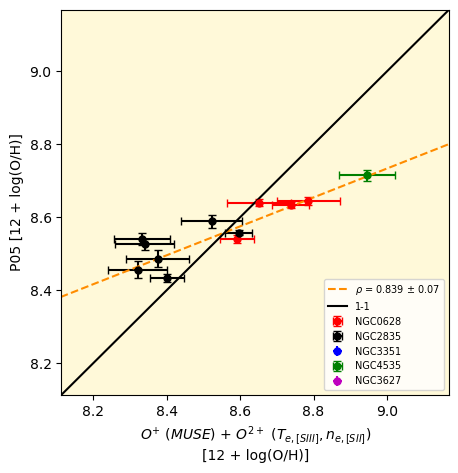

In [44]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharey=True)


colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1


OH_x = np.array(strong_data[Z_comp])
OH_x_err = np.array(strong_data[Z_comp_err])

strong_in = best_strong
OH_y = np.array(strong_data[strong_in])
OH_y_err = np.array(strong_data[strong_in+'_err'])


for k in range(2, len(galdic)+1):


   plot_ind = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * OH_x_err) > snr) & (1 / (np.log(10) * OH_y_err) > snr))[0]


   axs.errorbar(OH_x[plot_ind], OH_y[plot_ind],
                xerr = OH_x_err[plot_ind],
                yerr = OH_y_err[plot_ind],
                c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                label=f'{galdic[k]}')


plot_ind_1 = np.where((1 / (np.log(10) * OH_x_err) > snr) & (1 / (np.log(10) * OH_y_err) > snr))[0]


x, y = OH_x[plot_ind_1], OH_y[plot_ind_1]
x_err = OH_x_err[plot_ind_1]
y_err = OH_y_err[plot_ind_1]


min, max = np.min(np.concatenate([x,y])), np.max(np.concatenate([x,y]))


up = 1.025
down = 0.975
axs.set_xlim(min*down, max*up)
axs.set_ylim(min*down, max*up)


spear, spear_err = spear_func(x, y, x_err, y_err)


fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)


axs.plot(np.linspace(-2, 10, 100), fit_coef + fit_slope*np.linspace(-2, 10, 100),
        c='darkorange', linestyle='--',
        label=r'$\rho$ = 'f'{np.round(spear, decimals=3)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=3)}')
axs.fill_between(np.linspace(-2, 10, 100),
                (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-2, 10, 100),
                (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-2, 10, 100),
                color='gold', alpha=0.15)


print(fit_slope, fit_slope_err)
print(fit_coef, fit_coef_err)


axs.plot(np.linspace(-2, 10, 10), np.linspace(-2, 10, 10), c='k', label='1-1')


met_label_dict = {'met_scal':'Scal-PG16', 'met_rcal':'Rcal-PG16', 'met_rs2Dcal':'RScal-PG16', 'met_kk04':'KK04',
                 'met_m91':'M91', 'met_p05':'P05', 'met_d02':'D02', 'met_m13_o3n2':'O3N2-M13', 'met_m13_n2':'N2-M13', 'met_d16':'D16'}


direct_label_dict = {'OH_T0_OII':r'$O^{+}$ $\left(Benchmark\right)$ + $O^{2+}$ $\left(Benchmark\right)$' + '\n' + r'[12 + log(O/H)]',
                   'OH_SIII_OII':r'$O^{+}$ $\left(Benchmark\right)$ + $O^{2+}$ $\left(T_{e, [SIII]}, n_{e, [OII]7325+/3727+}\right)$' + '\n' + r'[12 + log(O/H)]',
                   'OH_SIII_SII': r'$O^{+}$ $\left(MUSE\right)$ + $O^{2+}$ $\left(T_{e, [SIII]}, n_{e, [SII]}\right)$' + '\n' + '[12 + log(O/H)]',
                   'OH_T0_SII': r'$O^{+}$ $\left(MUSE\right)$ + $O^{2+}$ $\left(T_{0}(O^{2+}), n_{e, [SII]}\right)$' + '\n' + r'[12 + log(O/H)]',
                   'OH_OIII_OII':r'$O^{+}$ $\left(Benchmark\right)$ + $O^{2+}$ $\left(T_{e, [OIII]}, n_{e, [OII]7325+/3727+}\right)$'  + '\n' + r'12 + log(O/H)',
                   'met_md23':r'$MD23$' + '\n' + r'[12 + log(O/H)]'}


axs.set_ylabel(f'{met_label_dict[strong_in]} [12 + log(O/H)]')
axs.set_xlabel(f'{direct_label_dict[Z_comp]}')
axs.legend(loc='lower right', fontsize = 7)

### Plot the strong line method that agrees best with MD23

Text(0, 0.5, 'P05 [12 + log(O/H)]')

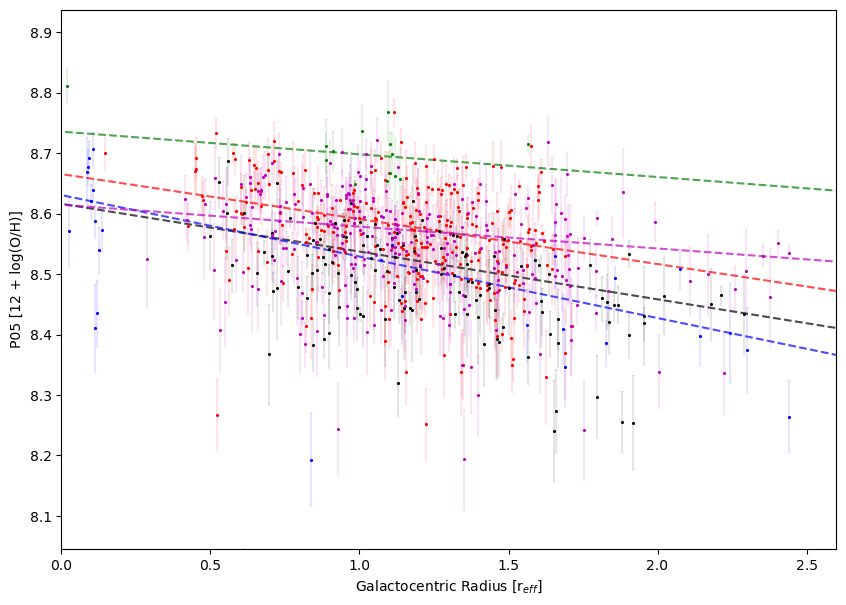

In [45]:
met = best_strong

seq = np.linspace(-10, 10, 10)

plot_lim_arr = []

plt.figure(figsize=(10, 7))

for i in range(1, len(galdic)):
    plot_bool = strong_data['gal_name'] == table_dic[i]['gal_name'][0]
    md23_ind = np.where((1 / (np.log(10) * np.array(strong_data[met+'_err'][plot_bool])) > snr) & (abs(strong_data[met][plot_bool]/strong_data[met+'_err'][plot_bool]) < 10**10))[0]
    a_val = 0.1
    mark_s = 1.2
    cap_s = 0.5
    plt.errorbar(strong_data['r_reff'][plot_bool][md23_ind], strong_data[met][plot_bool][md23_ind],
                 yerr=strong_data[met+'_err'][plot_bool][md23_ind], c=colordic[i], 
                 fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val) 
    
    plt.errorbar(strong_data['r_reff'][plot_bool][md23_ind], strong_data[met][plot_bool][md23_ind],
                 #yerr=strong_data[met+'_err'][plot_bool][md23_ind], 
                 c=colordic[i], 
                 fmt="o", markersize=mark_s, capsize=cap_s, alpha=1) 

    scals = np.array(strong_data[met][plot_bool][md23_ind])
    plot_lim_arr = np.concatenate([plot_lim_arr, scals])
    if len(scals) > 10:

        weights = 1.0 / np.array(strong_data[met+'_err'][plot_bool][md23_ind])**2
        X = sm.add_constant(np.array(strong_data['r_reff'][plot_bool][md23_ind]))
        model = sm.WLS(np.array(strong_data[met][plot_bool][md23_ind]), X, weights=weights)
        results = model.fit()
        scal = np.polyfit(np.array(strong_data['r_reff'][plot_bool][md23_ind]), scals, 1)
        scalfunc = np.poly1d(scal)
        plt.plot(seq, seq*results.params[1] + results.params[0], c=colordic[i],  linestyle="--", alpha = 0.7,
                label=f'Scal-PG16: y = {round(scalfunc[1],3)}x + {round(scalfunc[0],3)}')


plt.ylim(np.nanquantile(plot_lim_arr, 0.01)*0.975, np.nanquantile(plot_lim_arr, 0.99)*1.025)
plt.xlim(0, 2.6)

met_label_dict = {'met_scal':'Scal-PG16', 'met_rcal':'Rcal-PG16', 'met_rs2Dcal':'RScal-PG16', 'met_kk04':'KK04', 
                  'met_m91':'M91', 'met_p05':'P05', 'met_d02':'D02', 'met_m13_o3n2':'O3N2-M13', 'met_m13_n2':'N2-M13', 'met_d16':'D16'}

plt.xlabel(r'Galactocentric Radius [r$_{eff}$]', fontsize = 10)
plt.ylabel(f'{met_label_dict[met]} [12 + log(O/H)]', fontsize = 10)
#plt.title(f'SNR: {snr}')

### Make box plot with a strong line galaxy

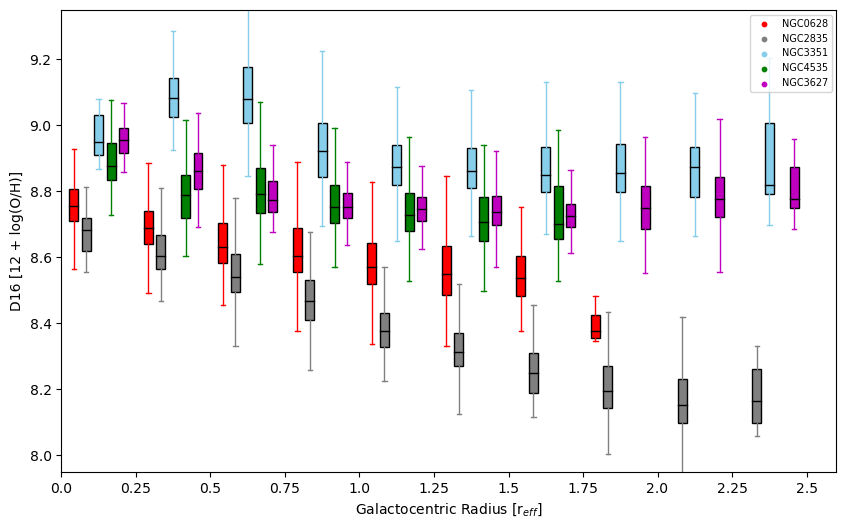

In [46]:
met = best_strong
met = 'met_d16'


seq = np.linspace(-1, 3, 10)

plot_lim_arr = []
dx = 0.25
bin_dict = {1: -(dx/6)*2, 2:-(dx/6), 3:0, 4:(dx/6), 5:(dx/6)*2}
colordic = {1: 'red', 2:'gray', 3:'skyblue', 4:'green', 5:'m'}

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(1, len(galdic)):
    #fig, ax = plt.subplots(figsize=(10, 6))
    plot_bool = strong_data['gal_name'] == table_dic[i]['gal_name'][0]
    gal_iter = table_dic[i]['gal_name'][0]
    md23_ind = np.where((1 / (np.log(10) * np.array(strong_data[met+'_err'][plot_bool])) > snr) & (abs(strong_data[met][plot_bool]/strong_data[met+'_err'][plot_bool]) < 10**10))[0]
    a_val = 1
    mark_s = 1.2
    cap_s = 0.5

    x = np.array(strong_data['r_reff'][plot_bool][md23_ind])
    y = np.array(strong_data[met][plot_bool][md23_ind])
    bins = np.arange(0, np.max(x) + dx, dx)
    bin_indices = np.digitize(x, bins)

    for k in range(1, len(bins)):
        bin_data = y[bin_indices == k]
            
        if len(bin_data) > 0:
            ax.boxplot(bin_data, positions=[bins[k-1] + dx/2 + bin_dict[i]], 
                       boxprops=dict(edgecolor='k', alpha=1, facecolor=colordic[i]),
                       capprops=dict(color=colordic[i]),
                       flierprops=dict(marker='.', markerfacecolor=colordic[i], markersize=8, markeredgecolor=colordic[i]),
                       whiskerprops=dict(color=colordic[i]),
                       medianprops=dict(color='k'), 
                       showfliers=False,
                       showbox=True,
                       widths=0.03, patch_artist=True)
    
    ax.scatter([0], [0], color=colordic[i], marker='o', s=10, label=f'{galdic[i+1]}')
    
    plot_lim_arr = np.concatenate([plot_lim_arr, y])
    if len(x) > 10:

        weights = 1.0 / np.array(strong_data[met+'_err'][plot_bool][md23_ind])**2
        X = sm.add_constant(np.array(strong_data['r_reff'][plot_bool][md23_ind]))
        model = sm.WLS(np.array(strong_data[met][plot_bool][md23_ind]), X, weights=weights)
        results = model.fit()
        scal = np.polyfit(np.array(strong_data['r_reff'][plot_bool][md23_ind]), y, 1)
        scalfunc = np.poly1d(scal)
        #plt.plot(seq, seq*results.params[1] + results.params[0], c=colordic[i],  linestyle="--", alpha = 0.7,
         #        label=f'Scal-PG16: y = {round(scalfunc[1],3)}x + {round(scalfunc[0],3)}')
    
    z_ind = np.where((1 / (np.log(10) * np.array(strong_data[Z_comp_err][plot_bool])) > snr))[0]
  #  plt.errorbar(strong_data['r_reff'][plot_bool][z_ind], strong_data[Z_comp][plot_bool][z_ind],
   #                 yerr=strong_data[Z_comp_err][plot_bool][z_ind], 
    #                c=colordic[i], 
     #               fmt=".", markersize=5, markerfacecolor='None', capsize=2, alpha=1, capthick=1)
    
rounded_bins = np.around(bins, decimals=2)
ax.set_xticks(rounded_bins)
ax.set_xticklabels(rounded_bins)

plt.xlim(0, 2.6)

met_label_dict = {'met_scal':'Scal-PG16', 'met_rcal':'Rcal-PG16', 'met_rs2Dcal':'RScal-PG16', 'met_kk04':'KK04', 
                  'met_m91':'M91', 'met_p05':'P05', 'met_d02':'D02', 'met_m13_o3n2':'O3N2-M13', 'met_m13_n2':'N2-M13', 'met_d16':'D16',
                  'met_md23':'MD23'}

title_dict = {'met_md23':'12 + log(O/H) (MD23) 'r'| $t^{2} = 0$', 'Z_SIII_OII':'12 + log(O/H) 'r'$(T_{e}([NII]), T_{e}([SIII]))$ | $t^{2} > 0$', 
              'Z_T0':'12 + log(O/H) 'r'$(T_{e}([NII]), T_{0}(O^{2+}))$ | $t^{2} > 0$'}

grad_line = np.linspace(-1, 5, 10)

def grad_func(x, m, b):
    return m*x + b

#plt.plot(grad_line, grad_func(grad_line, -0.054, 8.533), linestyle='--', c='r')
#plt.plot(grad_line, grad_func(grad_line, -0.157, 8.555), linestyle='--', c='gray')
#plt.plot(grad_line, grad_func(grad_line, 0.007, 8.579), linestyle='--', c='skyblue')
#plt.plot(grad_line, grad_func(grad_line, 0.006, 8.538), linestyle='--', c='green')
#plt.plot(grad_line, grad_func(grad_line, -0.040, 8.580), linestyle='--', c='m')


#plt.title(f'{title_dict[Z_comp]}')
plt.xlabel(r'Galactocentric Radius [r$_{eff}$]', fontsize = 10)
plt.ylabel(f'{met_label_dict[met]} [12 + log(O/H)]', fontsize = 10)
plt.legend(loc='upper right', fontsize = 7)
#plt.ylim(np.nanquantile(strong_data[met][abs(strong_data[met]) < 10**10], 0.01) * 0.975, np.nanquantile(strong_data[met][abs(strong_data[met]) < 10**10], 0.99) * 1.025)
plt.ylim(7.95, 9.35)
plt.show()

### Plot comparing Direct metallicities/MD23 with Strong Line prescriptions

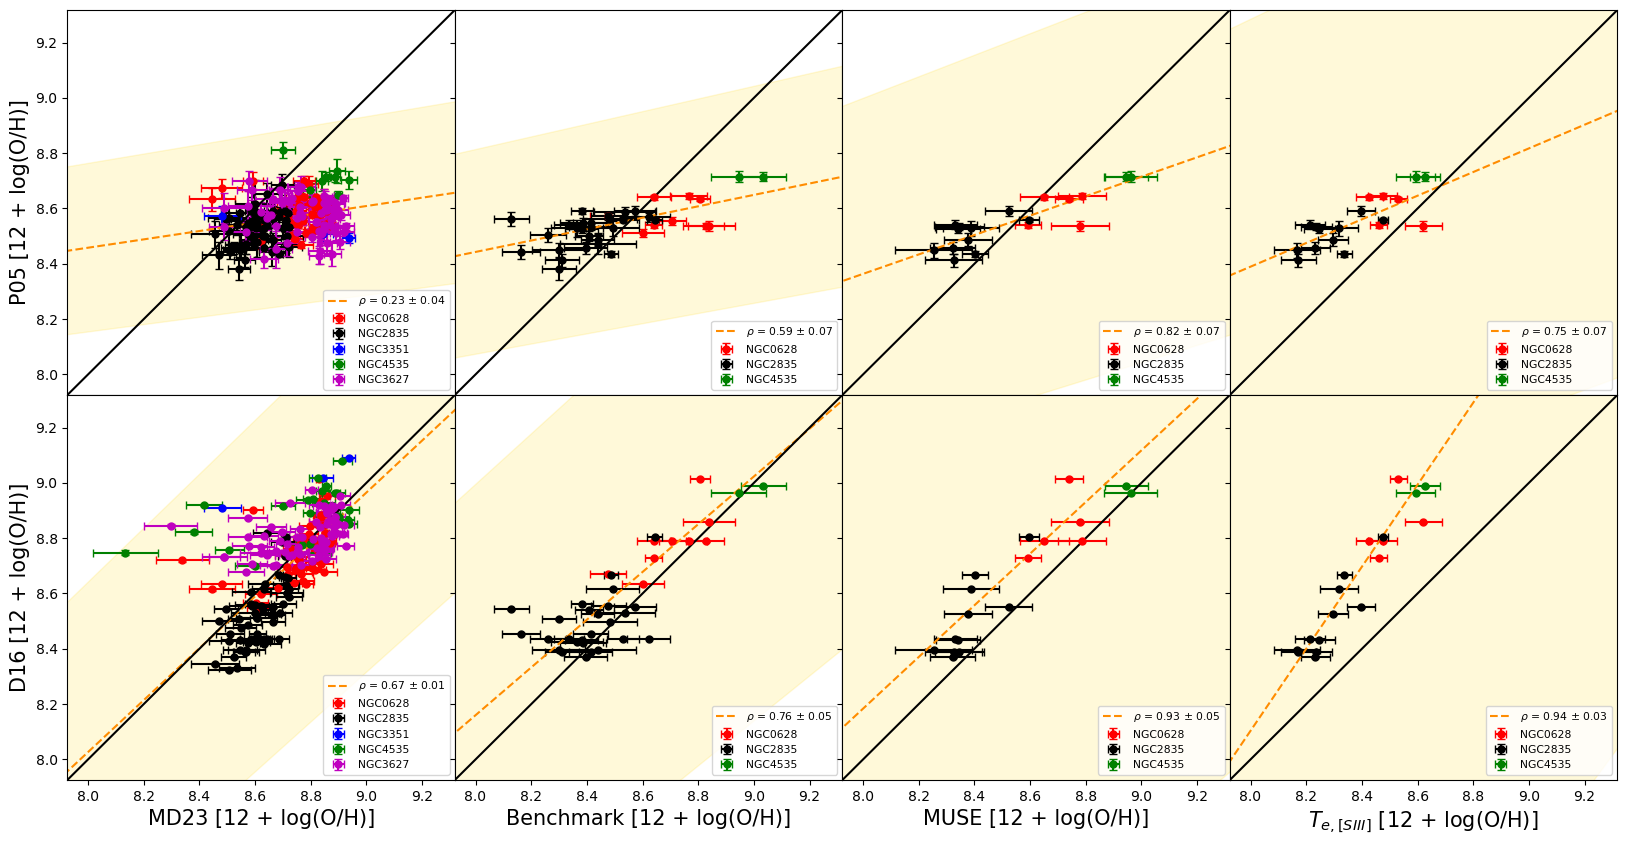

In [47]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True, sharex=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1
label_size = 15
legend_size = 7.75
spear_dec = 2

lim_list = []

### D02 versus MD23

for k in range(2, len(galdic)+1):

    plot_ind_1 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_p05_err'])) > snr))[0]

    if len(plot_ind_1) > 0:
        
        axs[0][0].errorbar(strong_data['met_md23'][plot_ind_1], strong_data['met_p05'][plot_ind_1],
                    xerr = strong_data['met_md23_err'][plot_ind_1],
                    yerr = strong_data['met_p05_err'][plot_ind_1], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

plot_ind_1 = np.where((1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_p05_err'])) > snr))[0]

axs[0][0].set_ylabel(r'P05 [12 + log(O/H)]', fontsize = label_size)
#axs[0][0].set_xlabel(r'12 + log(O/H) (MD23)', fontsize = label_size)

x, y = strong_data['met_md23'][plot_ind_1], strong_data['met_p05'][plot_ind_1]
x_err = strong_data['met_md23_err'][plot_ind_1]
y_err = strong_data['met_p05_err'][plot_ind_1]

axs[0][0].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
axs[0][0].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[0][0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[0][0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[0][0].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
axs[0][0].legend(loc='lower right', fontsize = legend_size)

lim_list.append(x), lim_list.append(y)

### D16 versus OH(Benchmark)

for k in range(2, len(galdic)+1):

    plot_ind_2 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_T0_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_p05_err'])) > snr))[0]

    if len(plot_ind_2) > 0:
        
        axs[0][1].errorbar(strong_data['OH_T0_OII'][plot_ind_2], strong_data['met_p05'][plot_ind_2],
                    xerr = strong_data['OH_T0_OII_ERR'][plot_ind_2],
                    yerr = strong_data['met_p05_err'][plot_ind_2], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

plot_ind_2 = np.where((1 / (np.log(10) * np.array(strong_data['OH_T0_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_p05_err'])) > snr))[0]

#axs[1].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
#axs[0][1].set_xlabel(r'12 + log(O/H) (Benchmark)', fontsize = label_size)

x, y = strong_data['OH_T0_OII'][plot_ind_2], strong_data['met_p05'][plot_ind_2]
x_err = strong_data['OH_T0_OII_ERR'][plot_ind_2]
y_err = strong_data['met_p05_err'][plot_ind_2]

axs[0][1].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
axs[0][1].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[1].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[0][1].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[0][1].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[0][1].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
axs[0][1].legend(loc='lower right', fontsize = legend_size)

lim_list.append(x), lim_list.append(y)

### D16 versus OH(MUSE)

for k in range(2, len(galdic)+1):

    plot_ind_3 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_p05_err'])) > snr))[0]

    if len(plot_ind_3) > 0:
        
        axs[0][2].errorbar(strong_data['OH_SIII_SII'][plot_ind_3], strong_data['met_p05'][plot_ind_3],
                    xerr = strong_data['OH_SIII_SII_ERR'][plot_ind_3],
                    yerr = strong_data['met_p05_err'][plot_ind_3], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

plot_ind_3 = np.where((1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_p05_err'])) > snr))[0]

#axs[2].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
#axs[0][2].set_xlabel(r'12 + log(O/H) (MUSE)', fontsize = label_size)

x, y = strong_data['OH_SIII_SII'][plot_ind_3], strong_data['met_p05'][plot_ind_3]
x_err = strong_data['OH_SIII_SII_ERR'][plot_ind_3]
y_err = strong_data['met_p05_err'][plot_ind_3]

axs[0][2].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
axs[0][2].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[0][2].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[0][2].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[0][2].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
axs[0][2].legend(loc='lower right', fontsize = legend_size)

lim_list.append(x), lim_list.append(y)

### Scal_pg16 versus OH(t^2 > 0)

for k in range(2, len(galdic)+1):

    plot_ind_4 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_SIII_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_p05_err'])) > snr))[0]

    if len(plot_ind_4) > 0:
        
        axs[0][3].errorbar(strong_data['OH_SIII_OII'][plot_ind_4], strong_data['met_p05'][plot_ind_4],
                    xerr = strong_data['OH_SIII_OII_ERR'][plot_ind_4],
                    yerr = strong_data['met_p05_err'][plot_ind_4], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, 
                    label=f'{galdic[k]}')

plot_ind_4 = np.where((1 / (np.log(10) * np.array(strong_data['OH_SIII_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_p05_err'])) > snr))[0]

#axs[3].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
#axs[0][3].set_xlabel(r'12 + log(O/H) ($t^2 > 0$)', fontsize = label_size)

x, y = strong_data['OH_SIII_OII'][plot_ind_4], strong_data['met_p05'][plot_ind_4]
x_err = strong_data['OH_SIII_OII_ERR'][plot_ind_4]
y_err = strong_data['met_p05_err'][plot_ind_4]

axs[0][3].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
axs[0][3].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[0][3].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[0][3].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[0][3].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
axs[0][3].legend(loc='lower right', fontsize = legend_size)

lim_list.append(x), lim_list.append(y)
lim_arr = np.concatenate(lim_list)
axs[0][3].set_xlim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)
axs[0][3].set_ylim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)

### D16 versus MD23

for k in range(2, len(galdic)+1):

    plot_ind_1 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

    if len(plot_ind_1) > 0:
        
        axs[1][0].errorbar(strong_data['met_md23'][plot_ind_1], strong_data['met_d16'][plot_ind_1],
                    xerr = strong_data['met_md23_err'][plot_ind_1],
                    yerr = strong_data['met_d16_err'][plot_ind_1], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

plot_ind_1 = np.where((1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

axs[1][0].set_ylabel(r'D16 [12 + log(O/H)]', fontsize = label_size)
axs[1][0].set_xlabel(r'MD23 [12 + log(O/H)]', fontsize = label_size)

x, y = strong_data['met_md23'][plot_ind_1], strong_data['met_d16'][plot_ind_1]
x_err = strong_data['met_md23_err'][plot_ind_1]
y_err = strong_data['met_d16_err'][plot_ind_1]

axs[1][0].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
axs[1][0].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[0].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[1][0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[1][0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[1][0].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
axs[1][0].legend(loc='lower right', fontsize = legend_size)

lim_list.append(x), lim_list.append(y)

### D16 versus OH(Benchmark)

for k in range(2, len(galdic)+1):

    plot_ind_2 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_T0_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

    if len(plot_ind_2) > 0:
        
        axs[1][1].errorbar(strong_data['OH_T0_OII'][plot_ind_2], strong_data['met_d16'][plot_ind_2],
                    xerr = strong_data['OH_T0_OII_ERR'][plot_ind_2],
                    yerr = strong_data['met_d16_err'][plot_ind_2], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

plot_ind_2 = np.where((1 / (np.log(10) * np.array(strong_data['OH_T0_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

#axs[5].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
axs[1][1].set_xlabel(r'Benchmark [12 + log(O/H)]', fontsize = label_size)

x, y = strong_data['OH_T0_OII'][plot_ind_2], strong_data['met_d16'][plot_ind_2]
x_err = strong_data['OH_T0_OII_ERR'][plot_ind_2]
y_err = strong_data['met_d16_err'][plot_ind_2]

axs[1][1].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
axs[1][1].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[1].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[1][1].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[1][1].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[1][1].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
axs[1][1].legend(loc='lower right', fontsize = legend_size)

lim_list.append(x), lim_list.append(y)

### D16 versus OH(MUSE)

for k in range(2, len(galdic)+1):

    plot_ind_3 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

    if len(plot_ind_3) > 0:
        
        axs[1][2].errorbar(strong_data['OH_SIII_SII'][plot_ind_3], strong_data['met_d16'][plot_ind_3],
                    xerr = strong_data['OH_SIII_SII_ERR'][plot_ind_3],
                    yerr = strong_data['met_d16_err'][plot_ind_3], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

plot_ind_3 = np.where((1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

#axs[2].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
axs[1][2].set_xlabel(r'MUSE [12 + log(O/H)]', fontsize = label_size)

x, y = strong_data['OH_SIII_SII'][plot_ind_3], strong_data['met_d16'][plot_ind_3]
x_err = strong_data['OH_SIII_SII_ERR'][plot_ind_3]
y_err = strong_data['met_d16_err'][plot_ind_3]

axs[1][2].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
axs[1][2].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[1][2].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[1][2].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[1][2].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
axs[1][2].legend(loc='lower right', fontsize = legend_size)

lim_list.append(x), lim_list.append(y)

### D16 versus OH(t^2 > 0)

for k in range(2, len(galdic)+1):

    plot_ind_4 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_SIII_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

    if len(plot_ind_4) > 0:
        
        axs[1][3].errorbar(strong_data['OH_SIII_OII'][plot_ind_4], strong_data['met_d16'][plot_ind_4],
                    xerr = strong_data['OH_SIII_OII_ERR'][plot_ind_4],
                    yerr = strong_data['met_d16_err'][plot_ind_4], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, 
                    label=f'{galdic[k]}')

plot_ind_4 = np.where((1 / (np.log(10) * np.array(strong_data['OH_SIII_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

#axs[3].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
axs[1][3].set_xlabel(r'$T_{e, [SIII]}$ [12 + log(O/H)]', fontsize = label_size)

x, y = strong_data['OH_SIII_OII'][plot_ind_4], strong_data['met_d16'][plot_ind_4]
x_err = strong_data['OH_SIII_OII_ERR'][plot_ind_4]
y_err = strong_data['met_d16_err'][plot_ind_4]

axs[1][3].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
axs[1][3].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[1][3].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[1][3].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[1][3].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
axs[1][3].legend(loc='lower right', fontsize = legend_size)

lim_list.append(x), lim_list.append(y)
lim_arr = np.concatenate(lim_list)
axs[1][3].set_xlim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)
axs[1][3].set_ylim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Plot comparing Direct metallicities/MD23 with Strong Line prescriptions

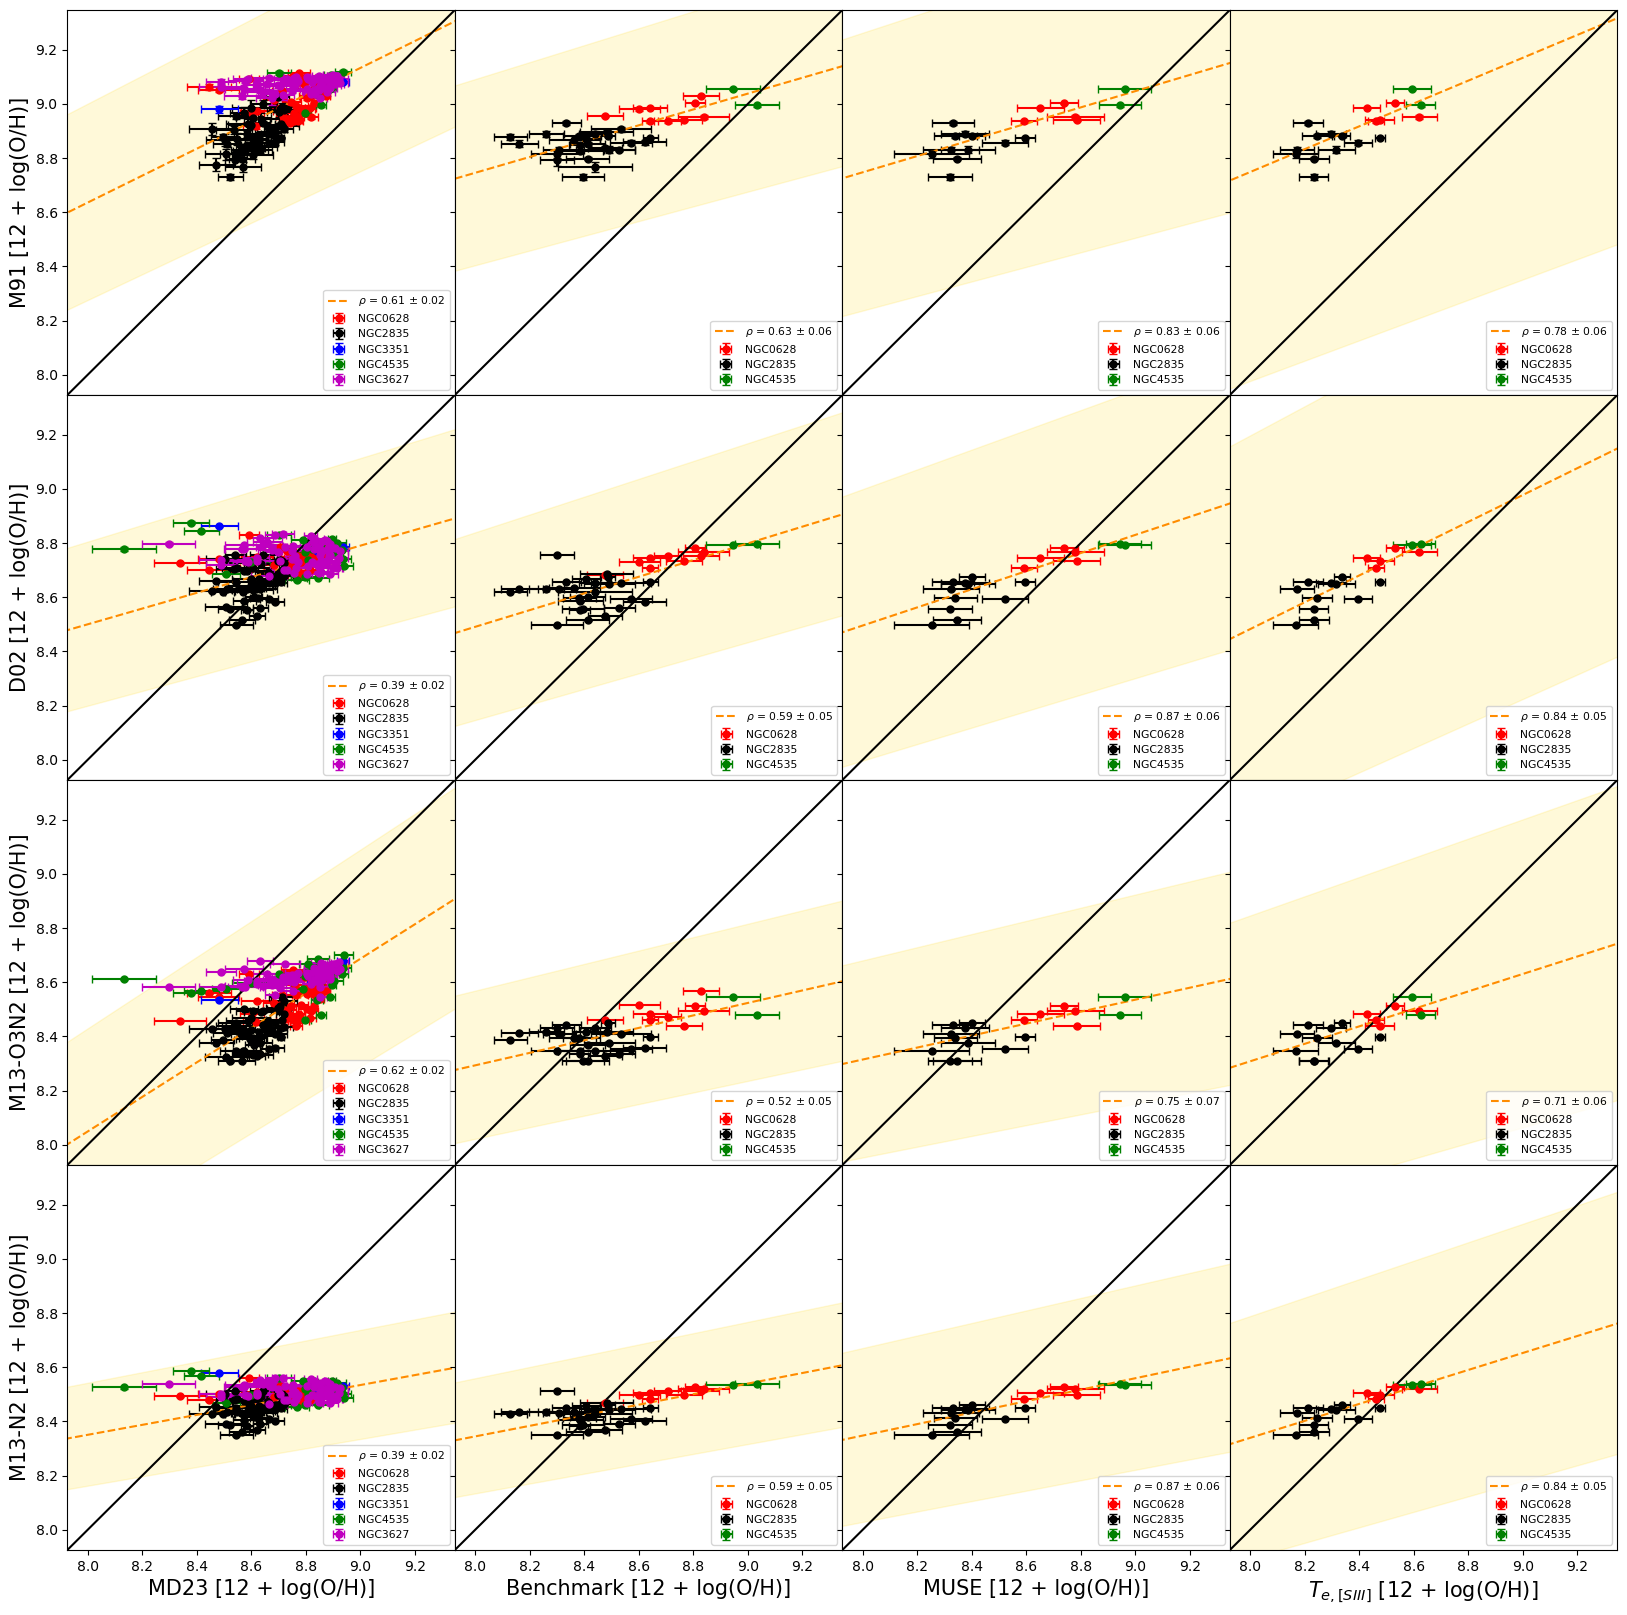

In [48]:
snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1
label_size = 15
legend_size = 7.75
spear_dec = 2

#met_labs = np.array(['met_scal', 'met_rcal', 'met_rs2Dcal', 'met_kk04'])
met_labs = np.array(['met_m91', 'met_d02', 'met_m13_o3n2', 'met_m13_n2'])

#met_label_dict = {'met_scal':'PG16-Scal', 'met_rcal':'PG16-Rcal', 'met_rs2Dcal':'PG16-RScal', 'met_kk04':'KK04'}  #'met_p05':'P05', 'met_d16':'D16', 'met_md23':'MD23'
met_label_dict = {'met_m91':'M91', 'met_d02':'D02', 'met_m13_o3n2':'M13-O3N2', 'met_m13_n2':'M13-N2'}  #'met_p05':'P05', 'met_d16':'D16', 'met_md23':'MD23'

fig, axs = plt.subplots(len(met_label_dict), 4, figsize=(20, 5*len(met_label_dict)), sharey=True, sharex=True)

lim_list = []

for j in range(len(met_labs)):
    
    met_in, met_in_err = met_labs[j], met_labs[j]+'_err'
    plt_lab = met_label_dict[met_labs[j]]

    ### MD23

    for k in range(2, len(galdic)+1):

        plot_ind_1 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

        if len(plot_ind_1) > 0:
        
            axs[j][0].errorbar(strong_data['met_md23'][plot_ind_1], strong_data[met_in][plot_ind_1],
                    xerr = strong_data['met_md23_err'][plot_ind_1],
                    yerr = strong_data[met_in_err][plot_ind_1], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

    plot_ind_1 = np.where((1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

    axs[j][0].set_ylabel(f'{plt_lab} [12 + log(O/H)]', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][0].set_xlabel(r'MD23 [12 + log(O/H)]', fontsize = label_size)

    x, y = strong_data['met_md23'][plot_ind_1], strong_data[met_in][plot_ind_1]
    x_err = strong_data['met_md23_err'][plot_ind_1]
    y_err = strong_data[met_in_err][plot_ind_1]

    axs[j][0].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][0].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs.text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][0].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][0].legend(loc='lower right', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)

    ### OH(Benchmark)

    for k in range(2, len(galdic)+1):

        plot_ind_2 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_T0_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

        if len(plot_ind_2) > 0:
        
            axs[j][1].errorbar(strong_data['OH_T0_OII'][plot_ind_2], strong_data[met_in][plot_ind_2],
                    xerr = strong_data['OH_T0_OII_ERR'][plot_ind_2],
                    yerr = strong_data[met_in_err][plot_ind_2], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

    plot_ind_2 = np.where((1 / (np.log(10) * np.array(strong_data['OH_T0_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

    #axs[j][1].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][1].set_xlabel(r'Benchmark [12 + log(O/H)]', fontsize = label_size)

    x, y = strong_data['OH_T0_OII'][plot_ind_2], strong_data[met_in][plot_ind_2]
    x_err = strong_data['OH_T0_OII_ERR'][plot_ind_2]
    y_err = strong_data[met_in_err][plot_ind_2]

    axs[j][1].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][1].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs[j][1].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][1].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][1].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][1].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][1].legend(loc='lower right', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)

    ### OH(MUSE)

    for k in range(2, len(galdic)+1):

        plot_ind_3 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

        if len(plot_ind_3) > 0:
        
            axs[j][2].errorbar(strong_data['OH_SIII_SII'][plot_ind_3], strong_data[met_in][plot_ind_3],
                    xerr = strong_data['OH_SIII_SII_ERR'][plot_ind_3],
                    yerr = strong_data[met_in_err][plot_ind_3], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

    plot_ind_3 = np.where((1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

    #axs[j][2].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][2].set_xlabel(r'MUSE [12 + log(O/H)]', fontsize = label_size)

    x, y = strong_data['OH_SIII_SII'][plot_ind_3], strong_data[met_in][plot_ind_3]
    x_err = strong_data['OH_SIII_SII_ERR'][plot_ind_3]
    y_err = strong_data[met_in_err][plot_ind_3]

    axs[j][2].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][2].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs[j][2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][2].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][2].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][2].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][2].legend(loc='lower right', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)

    ### OH(t^2 > 0)

    for k in range(2, len(galdic)+1):

        plot_ind_4 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_SIII_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

        if len(plot_ind_4) > 0:
        
            axs[j][3].errorbar(strong_data['OH_SIII_OII'][plot_ind_4], strong_data[met_in][plot_ind_4],
                    xerr = strong_data['OH_SIII_OII_ERR'][plot_ind_4],
                    yerr = strong_data[met_in_err][plot_ind_4], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, 
                    label=f'{galdic[k]}')

    plot_ind_4 = np.where((1 / (np.log(10) * np.array(strong_data['OH_SIII_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data[met_in_err])) > snr))[0]

    #axs[j][3].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
    if j == len(met_labs) - 1:
        axs[j][3].set_xlabel(r'$T_{e, [SIII]}$ [12 + log(O/H)]', fontsize = label_size)

    x, y = strong_data['OH_SIII_OII'][plot_ind_4], strong_data[met_in][plot_ind_4]
    x_err = strong_data['OH_SIII_OII_ERR'][plot_ind_4]
    y_err = strong_data[met_in_err][plot_ind_4]

    axs[j][3].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
    axs[j][3].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

    spear, spear_err = spear_func(x, y, x_err, y_err)

    fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

    #axs[j][2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][3].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
    axs[j][3].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
    axs[j][3].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
    axs[j][3].legend(loc='lower right', fontsize = legend_size)

    lim_list.append(x), lim_list.append(y)
    lim_arr = np.concatenate(lim_list)
    axs[j][3].set_xlim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)
    axs[j][3].set_ylim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Plot comparing Direct metallicities/MD23 with Strong Line prescriptions

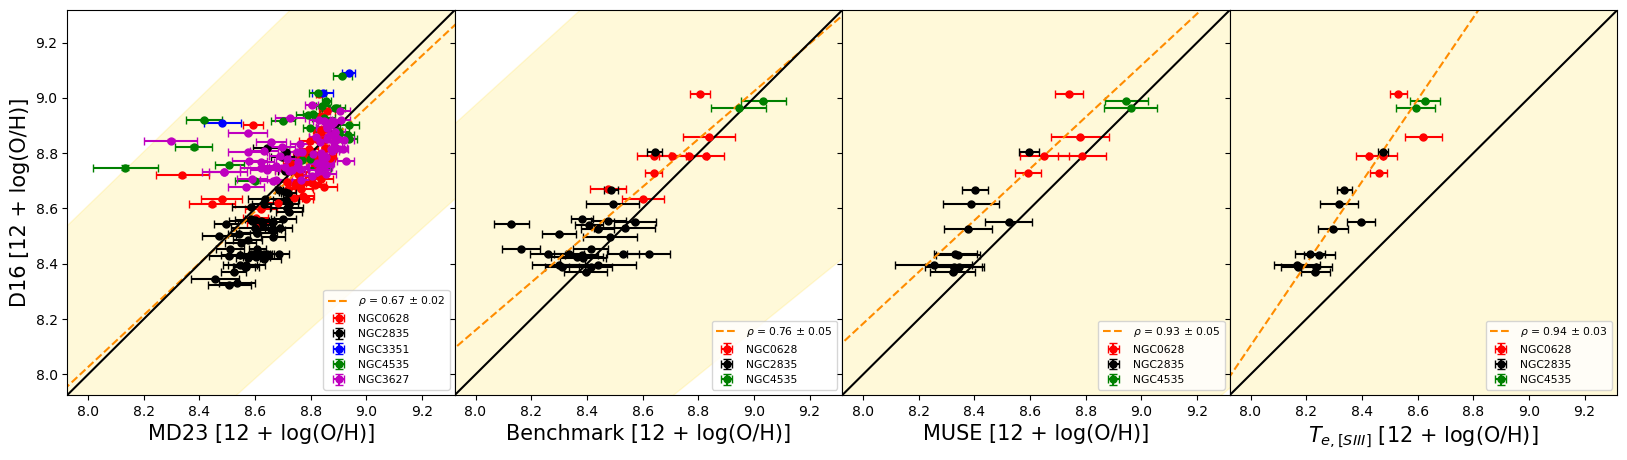

In [49]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True, sharex=True)

snr = 3
colordic = {1: 'red', 2:'k', 3:'blue', 4:'green', 5:'m'}
mark_s, cap_s, a_val = 5, 3, 1
label_size = 15
legend_size = 7.75
spear_dec = 2

lim_list = []

### D16 versus MD23

for k in range(2, len(galdic)+1):

    plot_ind_1 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

    if len(plot_ind_1) > 0:
        
        axs[0].errorbar(strong_data['met_md23'][plot_ind_1], strong_data['met_d16'][plot_ind_1],
                    xerr = strong_data['met_md23_err'][plot_ind_1],
                    yerr = strong_data['met_d16_err'][plot_ind_1], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

plot_ind_1 = np.where((1 / (np.log(10) * np.array(strong_data['met_md23_err'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

axs[0].set_ylabel(r'D16 [12 + log(O/H)]', fontsize = label_size)
axs[0].set_xlabel(r'MD23 [12 + log(O/H)]', fontsize = label_size)

x, y = strong_data['met_md23'][plot_ind_1], strong_data['met_d16'][plot_ind_1]
x_err = strong_data['met_md23_err'][plot_ind_1]
y_err = strong_data['met_d16_err'][plot_ind_1]

axs[0].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
axs[0].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs.text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[0].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[0].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[0].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
axs[0].legend(loc='lower right', fontsize = legend_size)

lim_list.append(x), lim_list.append(y)

### D16 versus OH(Benchmark)

for k in range(2, len(galdic)+1):

    plot_ind_2 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_T0_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

    if len(plot_ind_2) > 0:
        
        axs[1].errorbar(strong_data['OH_T0_OII'][plot_ind_2], strong_data['met_d16'][plot_ind_2],
                    xerr = strong_data['OH_T0_OII_ERR'][plot_ind_2],
                    yerr = strong_data['met_d16_err'][plot_ind_2], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

plot_ind_2 = np.where((1 / (np.log(10) * np.array(strong_data['OH_T0_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

#axs[5].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
axs[1].set_xlabel(r'Benchmark [12 + log(O/H)]', fontsize = label_size)

x, y = strong_data['OH_T0_OII'][plot_ind_2], strong_data['met_d16'][plot_ind_2]
x_err = strong_data['OH_T0_OII_ERR'][plot_ind_2]
y_err = strong_data['met_d16_err'][plot_ind_2]

axs[1].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
axs[1].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[1].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[1].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[1].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[1].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
axs[1].legend(loc='lower right', fontsize = legend_size)

lim_list.append(x), lim_list.append(y)

### D16 versus OH(MUSE)

for k in range(2, len(galdic)+1):

    plot_ind_3 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

    if len(plot_ind_3) > 0:
        
        axs[2].errorbar(strong_data['OH_SIII_SII'][plot_ind_3], strong_data['met_d16'][plot_ind_3],
                    xerr = strong_data['OH_SIII_SII_ERR'][plot_ind_3],
                    yerr = strong_data['met_d16_err'][plot_ind_3], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val,
                    label=f'{galdic[k]}')

plot_ind_3 = np.where((1 / (np.log(10) * np.array(strong_data['OH_SIII_SII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

#axs[2].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
axs[2].set_xlabel(r'MUSE [12 + log(O/H)]', fontsize = label_size)

x, y = strong_data['OH_SIII_SII'][plot_ind_3], strong_data['met_d16'][plot_ind_3]
x_err = strong_data['OH_SIII_SII_ERR'][plot_ind_3]
y_err = strong_data['met_d16_err'][plot_ind_3]

axs[2].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
axs[2].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[2].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--',
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[2].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[2].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
axs[2].legend(loc='lower right', fontsize = legend_size)

lim_list.append(x), lim_list.append(y)

### D16 versus OH(t^2 > 0)

for k in range(2, len(galdic)+1):

    plot_ind_4 = np.where((strong_data['gal_name'] == galdic[k]) & (1 / (np.log(10) * np.array(strong_data['OH_SIII_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

    if len(plot_ind_4) > 0:
        
        axs[3].errorbar(strong_data['OH_SIII_OII'][plot_ind_4], strong_data['met_d16'][plot_ind_4],
                    xerr = strong_data['OH_SIII_OII_ERR'][plot_ind_4],
                    yerr = strong_data['met_d16_err'][plot_ind_4], 
                    c=colordic[k-1], fmt="o", markersize=mark_s, capsize=cap_s, alpha=a_val, 
                    label=f'{galdic[k]}')

plot_ind_4 = np.where((1 / (np.log(10) * np.array(strong_data['OH_SIII_OII_ERR'])) > snr) & (1 / (np.log(10) * np.array(strong_data['met_d16_err'])) > snr))[0]

#axs[3].set_ylabel(r'12 + log(O/H) (P05)', fontsize = label_size)
axs[3].set_xlabel(r'$T_{e, [SIII]}$ [12 + log(O/H)]', fontsize = label_size)

x, y = strong_data['OH_SIII_OII'][plot_ind_4], strong_data['met_d16'][plot_ind_4]
x_err = strong_data['OH_SIII_OII_ERR'][plot_ind_4]
y_err = strong_data['met_d16_err'][plot_ind_4]

axs[3].set_xlim(np.nanmin(x)*0.975, np.nanmax(x)*1.025)
axs[3].set_ylim(np.nanmin(y)*0.975, np.nanmax(y)*1.025)

spear, spear_err = spear_func(x, y, x_err, y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)

#axs[2].text(0.01, np.nanmax(y)*1.02, s=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[3].plot(np.linspace(-1, 10, 10), fit_coef + fit_slope*np.linspace(-1, 10, 10), 
         c='darkorange', linestyle='--', 
         label=r'$\rho$ = 'f'{np.round(spear, decimals=spear_dec)} 'r'$\pm$ 'f'{np.round(spear_err, decimals=spear_dec)}')
axs[3].fill_between(np.linspace(-1, 10**11, 10), 
                 (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(-1, 10**11, 10), 
                 (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(-1, 10**11, 10),
                 color='gold', alpha=0.15)
axs[3].plot(np.linspace(-1, 10, 10), np.linspace(-1, 10, 10), c='k')
axs[3].legend(loc='lower right', fontsize = legend_size)

lim_list.append(x), lim_list.append(y)
lim_arr = np.concatenate(lim_list)
axs[3].set_xlim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)
axs[3].set_ylim(np.nanmin(lim_arr)*0.975, np.nanmax(lim_arr)*1.025)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# [SIII]6312 quality check

### Data from CHAOS paper

In [50]:
temp_nii_chaos = np.array([7700, 7900, 8000, 8900, 9200, 8900, 8600, 9100, 8900, 8900, 8600, 8400, 9700, 9900, 9600, 9800, 10400])
temp_nii_chaos_err = np.array([700, 300, 300, 500, 700, 300, 400, 600, 500, 1000, 500, 400, 1300, 1000, 800, 1300, 1100])

temp_siii_chaos = np.array([7300, 7900, 7600, 9300, 8500, 8900, 8100, 7900, 9300, 7900, 8700, 8800, 10100, 9300, 10300, 9000, 10900])
temp_siii_chaos_err = np.array([300, 400, 300, 300, 500, 300, 200, 300, 300, 400, 300, 400, 600, 800, 300, 400, 700])

### Function to find [SIII] temperature from CHAOS paper

In [51]:
def CHAOS_VI(temp_nii):
    temp_ = temp_nii 
    return (1.46*(temp_/10**4) -0.41) * 10**4

### Plot comparison

2.2095448404379567


/home/habjan/.conda/envs/orb3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


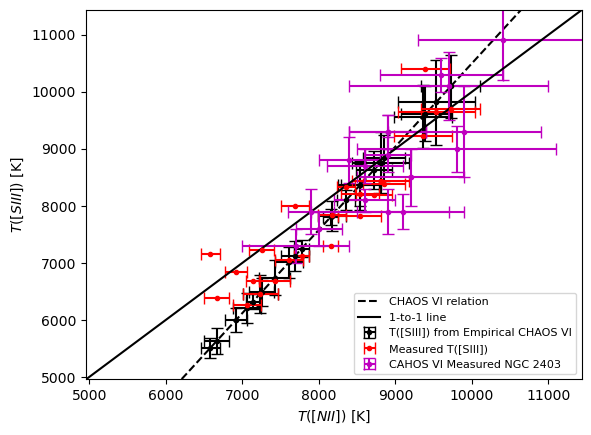

In [52]:
snr = 3

te_nii, te_nii_err = np.array(strong_data['NII_TEMP']), np.array(strong_data['NII_TEMP_ERR'])
te_siii, te_siii_err = np.array(strong_data['SIII_TEMP']), np.array(strong_data['SIII_TEMP_ERR'])

te_siii_chaos = CHAOS_VI(te_nii)
te_siii_chaos_err = np.nanstd(np.array([CHAOS_VI(np.random.normal(te_nii, te_nii_err)) for j in range(10**3)]), axis=0)

plot_ind = np.where((te_siii_chaos/te_siii_chaos_err > snr) & (te_siii/te_siii_err > snr))[0]
    
plt.errorbar(te_nii[plot_ind], te_siii_chaos[plot_ind], 
             xerr=te_nii_err[plot_ind], 
             yerr=te_siii_chaos_err[plot_ind], 
             color='k', fmt="o", markersize=3, capsize=4, label=f'T([SIII]) from Empirical CHAOS VI')

plt.plot(np.linspace(-10, 10**6, 10), CHAOS_VI(np.linspace(-10, 10**6, 10)), c='k', linestyle='--', label='CHAOS VI relation')
#plt.plot(temp_siii_nii(np.linspace(-10, 10**6, 10)), np.linspace(-10, 10**6, 10), c='green', linestyle='--', label='CHAOS IV relation')

plt.errorbar(te_nii[plot_ind], te_siii[plot_ind], 
             xerr=te_nii_err[plot_ind], 
             #yerr=te_siii_chaos_err[plot_ind], 
             color='red', fmt="o", markersize=3, capsize=4, label=f'Measured T([SIII])')

plt.errorbar(temp_nii_chaos, temp_siii_chaos, 
             xerr=temp_nii_chaos_err, 
             yerr=temp_siii_chaos_err, 
             color='m', fmt="o", markersize=3, capsize=4, label=f'CAHOS VI Measured NGC 2403')

plt.plot(np.linspace(-10, 10**6, 10), np.linspace(-10, 10**6, 10), c='k', label='1-to-1 line')
plt.xlabel(r'$T([NII])$ [K]')
plt.ylabel(r'$T([SIII])$ [K]')

concat_vals = np.concatenate([te_siii[plot_ind], te_siii_chaos[plot_ind]])
lowb = np.nanmin(concat_vals) * 0.9
upb = np.nanmax(concat_vals) * 1.1
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
#plt.xscale('log')
#plt.yscale('log')

print(np.median(te_siii_chaos[plot_ind] - te_siii[plot_ind]))

plt.legend(loc='lower right', fontsize = 8)

# Comparison to KCWI [OII] temperatures

### Import KCWI data

In [53]:
infile = open(inter_data_path + f'/ngc2835_hii_cat_v1.fits','rb')
kcwi_2835 = Table.read(infile)

infile = open(inter_data_path + f'/ngc628_hii_cat_v1.fits','rb')
kcwi_628 = Table.read(infile)

kcwi = vstack([kcwi_2835, kcwi_628])

### Plot comparing temeprature trends

0.8301780110408861 -0.13612206680047256 0.10101372618615777 0.11993712020822346
0.6747211285040485 0.06596130201560257 0.04721663671919859 0.0453364537548865
0.4263744924075943 0.4152471410963541 0.08908465390633573 0.09776751684643037
0.5604911022698293 0.2672419499758274 0.0537770833671368 0.04686026891295657


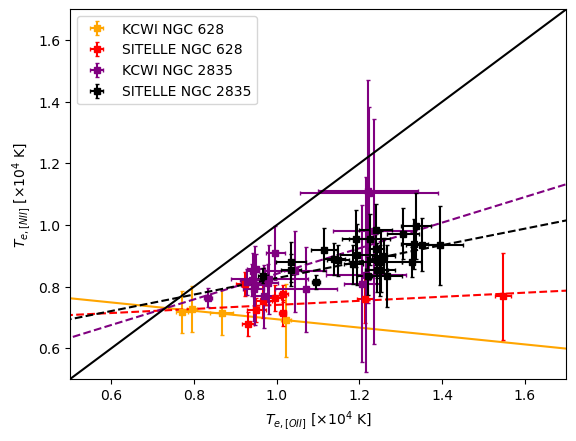

In [54]:
snr = 3

### Plot data from NGC 628

# KCWI

plot_ind = np.where((np.array(kcwi_628['T_NII'])/ np.array(kcwi_628['T_NII_ERR']) > snr) & (np.array(kcwi_628['T_OII'])/np.array(kcwi_628['T_OII_ERR']) > snr) )[0]

x, y = np.array(np.array(kcwi_628['T_OII'][plot_ind])) / 10**4, np.array(np.array(kcwi_628['T_NII'][plot_ind]))/ 10**4
x_err = np.array(kcwi_628['T_OII_ERR'][plot_ind]) / 10**4
y_err = np.array(kcwi_628['T_NII_ERR'][plot_ind]) / 10**4

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)
print(fit_coef, fit_slope, fit_coef_err, fit_slope_err)

plt.errorbar(x, y, x_err, y_err, c='orange', fmt="s", markersize=5, capsize=1.5, alpha=1, label = 'KCWI NGC 628')

plt.plot(np.linspace(0, 5*10**4, 20), fit_coef + fit_slope*np.linspace(0, 5*10**4, 20), linestyle = '-', c='orange')

# SITELLE 

plot_ind = np.where((np.array(strong_data['NII_TEMP'])/ np.array(strong_data['NII_TEMP_ERR']) > snr) & (np.array(strong_data['OII_TEMP'])/np.array(strong_data['OII_TEMP_ERR']) > snr) & (strong_data['gal_name'] == "NGC0628"))[0]

x, y = np.array(np.array(strong_data['OII_TEMP'][plot_ind])) / 10**4, np.array(np.array(strong_data['NII_TEMP'][plot_ind]))/ 10**4
x_err = np.array(strong_data['OII_TEMP_ERR'][plot_ind]) / 10**4
y_err = np.array(strong_data['NII_TEMP_ERR'][plot_ind]) / 10**4

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)
print(fit_coef, fit_slope, fit_coef_err, fit_slope_err)

plt.errorbar(x, y, x_err, y_err, c='red', fmt="s", markersize=5, capsize=1.5, alpha=1, label = 'SITELLE NGC 628')

plt.plot(np.linspace(0, 5*10**4, 20), fit_coef + fit_slope*np.linspace(0, 5*10**4, 20), linestyle = '--', c='red')

### Plot data from NGC 2835

# KCWI

plot_ind = np.where((np.array(kcwi_2835['T_NII'])/ np.array(kcwi_2835['T_NII_ERR']) > snr) & (np.array(kcwi_2835['T_OII'])/np.array(kcwi_2835['T_OII_ERR']) > snr) )[0]

x, y = np.array(np.array(kcwi_2835['T_OII'][plot_ind])) / 10**4, np.array(np.array(kcwi_2835['T_NII'][plot_ind]))/ 10**4
x_err = np.array(kcwi_2835['T_OII_ERR'][plot_ind]) / 10**4
y_err = np.array(kcwi_2835['T_NII_ERR'][plot_ind]) / 10**4

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)
print(fit_coef, fit_slope, fit_coef_err, fit_slope_err)

plt.errorbar(x, y, x_err, y_err, c='purple', fmt="s", markersize=5, capsize=1.5, alpha=1, label='KCWI NGC 2835')

plt.plot(np.linspace(0, 5*10**4, 20), fit_coef + fit_slope*np.linspace(0, 5*10**4, 20), linestyle = '--', c='purple')

# SITELLE 

plot_ind = np.where((np.array(strong_data['NII_TEMP'])/ np.array(strong_data['NII_TEMP_ERR']) > snr) & (np.array(strong_data['OII_TEMP'])/np.array(strong_data['OII_TEMP_ERR']) > snr) & (strong_data['gal_name'] == "NGC2835"))[0]

x, y = np.array(np.array(strong_data['OII_TEMP'][plot_ind])) / 10**4, np.array(np.array(strong_data['NII_TEMP'][plot_ind]))/ 10**4
x_err = np.array(strong_data['OII_TEMP_ERR'][plot_ind]) / 10**4
y_err = np.array(strong_data['NII_TEMP_ERR'][plot_ind]) / 10**4

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)
print(fit_coef, fit_slope, fit_coef_err, fit_slope_err)

plt.errorbar(x, y, x_err, y_err, c='k', fmt="s", markersize=5, capsize=1.5, alpha=1, label = 'SITELLE NGC 2835')

plt.plot(np.linspace(0, 5*10**4, 20), fit_coef + fit_slope*np.linspace(0, 5*10**4, 20), linestyle = '--', c='k')

plt.plot(np.linspace(0, 5*10**4, 20), np.linspace(0, 5*10**4, 20), c='k')

min = 0.5 #np.nanmin(np.concatenate([x,y])) * 0.9
max = 1.7 #np.nanmax(np.concatenate([x,y])) * 1.1
plt.xlim(min, max)
plt.ylim(min, max)

plt.xlabel(r'$T_{e, [OII]}$ $[\times 10^4$ K]')
plt.ylabel(r'$T_{e, [NII]}$ $[\times 10^4$ K]')
plt.legend()

# Compare to SIGNALS

In [55]:
galaxynum = 5
galdic = {1:'NGC4254', 2:'NGC4535', 3:'NGC3351', 4:'NGC2835', 5:'NGC0628'}  #There is no SITELLE data for NGC 4254, NGC 2835 has the best data 
galaxy = galdic[galaxynum]
print(galaxy)

inter_data_path = '/home/habjan/SITELLE/data/data_raw_intermediate'

infile = open(inter_data_path + f"/{galaxy}_physdata_MUSE+SITELLE.fits",'rb')
physdata = Table.read(infile)

infile = open(inter_data_path + f"/{galaxy}_refit+SITELLEfits_data.fits",'rb')
data = Table.read(infile)

#hdul = fits.open(f"/home/habjan/jupfiles/data/SIGNALS_Catalog/NGC628_catalog.fits")
hdul = fits.open(inter_data_path + f"/NGC628_catalog_WCS_corr.fits")
signals = hdul[0].data             #This is just a numpy array, use the text file to see what each index of the array is. There are 4284 HII regions in total

infile = fits.open(inter_data_path + f'/Nebulae_Catalogue_DR2_native_with_OII.fits')
hdul = Table.read(infile)
fabian = hdul[hdul['gal_name'] == f'{galaxy}']

#signals_amp = fits.open(inter_data_path + f"/NGC628_SN1_1.0.LineMaps.map.3727.amplitude.fits")

#hdul = fits.open(inter_data_path + f"/NGC628_SN1_1.0.LineMaps.map.3727.fwhm.fits")
#signals_fwhm = hdul[0].data

nebulae_mask = fits.open(inter_data_path + f"/{galaxy}_nebulae_mask_V2.fits")

coord_dic = {'NGC4535':np.array([188.5851585 , 8.19257]), 'NGC3351':np.array([160.99236896, 11.70541767]), 'NGC2835':np.array([139.47045857, -22.35414826]), 'NGC0628':np.array([24.17123567, 15.78081634])}
zoom_dic = {'NGC4535':np.array([0.05, 0.05]), 'NGC3351':np.array([0.053, 0.053]), 'NGC2835':np.array([0.05, 0.05]), 'NGC0628':np.array([0.08, 0.08])}
galaxy

NGC0628


'NGC0628'

### Write code to make a list of HII regions that have centers that are within 1.5 arcseconds of the Nebular catalog

In [56]:
muse_ind = []
sig_ind = []

arcseconds = 0.3
error_val = 1

for i in range(len(data)):
    for s in range(len(signals)):
        cen_ra = (data['cen_ra'][i] - signals[s][1]) * 3600
        cen_dec = (data['cen_dec'][i] - signals[s][2]) * 3600
        if np.sqrt(cen_ra**2 + cen_dec**2) < arcseconds:# and 10**signals[s][27] > error_val * 10**signals[s][28]:
            muse_ind.append(i)
            sig_ind.append(s)

### Compare [OII]3727/H$\beta$ from my analysis and SIGNALS

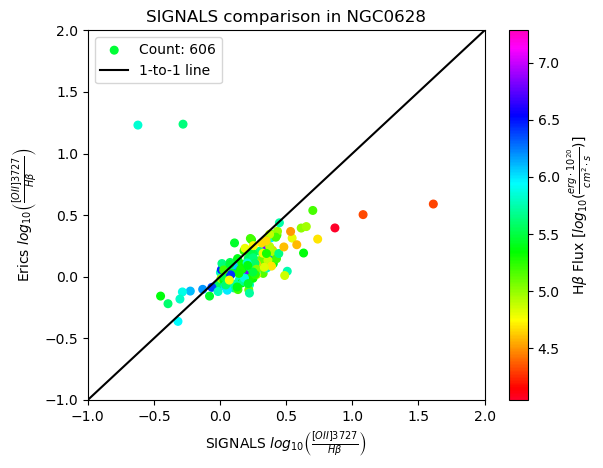

In [57]:
sig_ind = np.array(sig_ind)
muse_ind = np.array(muse_ind)

hbeta = np.array(data['HB4861_FLUX_CORR'][muse_ind])
signals_oii_hb = signals[sig_ind, 27]
sitelle_oii = np.array(data['OII3727_FLUX_CORR'][muse_ind])

plot_sig = signals_oii_hb
#plot_sig = (10**signals_oii_hb) * hbeta
plot_muse = np.log10(sitelle_oii / hbeta)

#plt.scatter(sigoiihb[sig_ind], museoiihb[muse_ind], color='k', s=10, label=f'SIGNALS: {len(np.where(~np.isnan(sigoiiioii))[0])}')
plt.scatter(plot_sig, plot_muse, c=np.log10(hbeta), cmap='gist_rainbow', s=30, label=f'Count: {len(muse_ind)}')

plt.plot(np.linspace(-10, 10**11, 10), np.linspace(-10, 10**11, 10), c='k', label='1-to-1 line')

plt.title(f'SIGNALS comparison in {galaxy}')
plt.xlabel(r'SIGNALS $log_{10} \left(\frac{[OII]3727}{H \beta} \right)$')
plt.ylabel(r'Erics $log_{10} \left(\frac{[OII]3727}{H \beta} \right)$')
lowb = -1 #10**4.5
upb = 2 #10**7.7
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
plt.legend(loc='best')
#plt.xscale('log')
#plt.yscale('log')

plt.colorbar(label=r'H$\beta$ Flux [$log_{10} (\frac{erg \cdot 10^{20}}{cm^{2} \cdot s}) $]')

### Compare [OII]3727 from my analysis and SIGNALS

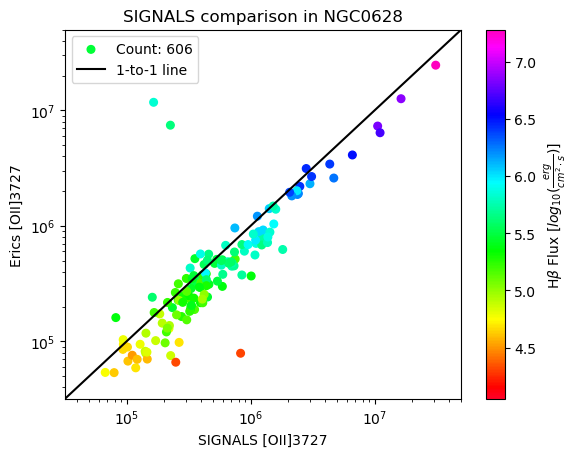

In [58]:
sig_ind = np.array(sig_ind)
muse_ind = np.array(muse_ind)

hbeta = np.array(data[muse_ind]['HB4861_FLUX_CORR'])
signals_oii_hb = signals[sig_ind, 27]
sitelle_oii = np.array(data['OII3727_FLUX_CORR'][muse_ind])

#plot_sig = np.exp(signals_oii_hb) * hbeta
plot_sig = (10**signals_oii_hb) * hbeta
plot_muse = sitelle_oii

#plt.scatter(sigoiihb[sig_ind], museoiihb[muse_ind], color='k', s=10, label=f'SIGNALS: {len(np.where(~np.isnan(sigoiiioii))[0])}')
plt.scatter(plot_sig, plot_muse, c=np.log10(hbeta), cmap='gist_rainbow', s=30, label=f'Count: {len(muse_ind)}')

plt.plot(np.linspace(-10, 10**11, 10), np.linspace(-10, 10**11, 10), c='k', label='1-to-1 line')

plt.title(f'SIGNALS comparison in {galaxy}')
plt.xlabel(r'SIGNALS [OII]3727')
plt.ylabel(r'Erics [OII]3727')
lowb = 10**4.5
upb = 10**7.7
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')

plt.colorbar(label=r'H$\beta$ Flux [$log_{10} (\frac{erg}{cm^{2} \cdot s}) $]')

### [OIII]5007 comparison

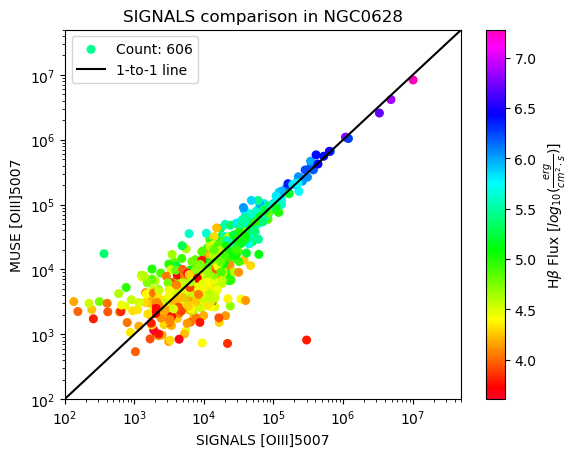

In [59]:
sig_ind = np.array(sig_ind)
muse_ind = np.array(muse_ind)

hbeta = np.array(data[muse_ind]['HB4861_FLUX_CORR'])
signals_oii_hb = signals[sig_ind, 24]
sitelle_oii = np.array(data['OIII5006_FLUX_CORR'][muse_ind])

#plot_sig = np.exp(signals_oii_hb) * hbeta
plot_sig = (10**signals_oii_hb) * hbeta
plot_muse = sitelle_oii

#plt.scatter(sigoiihb[sig_ind], museoiihb[muse_ind], color='k', s=10, label=f'SIGNALS: {len(np.where(~np.isnan(sigoiiioii))[0])}')
plt.scatter(plot_sig, plot_muse, c=np.log10(hbeta), cmap='gist_rainbow', s=30, label=f'Count: {len(muse_ind)}')

plt.plot(np.linspace(-10, 10**11, 10), np.linspace(-10, 10**11, 10), c='k', label='1-to-1 line')

plt.title(f'SIGNALS comparison in {galaxy}')
plt.xlabel(r'SIGNALS [OIII]5007')
plt.ylabel(r'MUSE [OIII]5007')
lowb = 10**2
upb = 10**7.7
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
plt.legend(loc='best')
plt.xscale('log')
plt.yscale('log')

plt.colorbar(label=r'H$\beta$ Flux [$log_{10} (\frac{erg}{cm^{2} \cdot s}) $]')

### Make arrays for histograms

In [60]:
logoiiihb = np.array(data['OIII5006_FLUX_CORR']) / np.array(data['HB4861_FLUX_CORR'])
logoiiihb = np.log10(logoiiihb[(logoiiihb > 0) & (np.array(data['OIII5006_FLUX_CORR']) / np.array(data['OIII5006_FLUX_CORR_ERR']) > 5)])
logoiiihb = logoiiihb[~np.isnan(logoiiihb) & ~np.isinf(logoiiihb)]

sig_bool = ~np.isnan(signals[:, 24]) & ~np.isinf(signals[:, 24]) & (1 / (np.log(10) * signals[:, 25]) > 5)
sigoiiihb= signals[sig_bool, 24]


logoiihb = np.array(data['OII3727_FLUX_CORR']) / np.array(data['HB4861_FLUX_CORR'])
logoiihb = np.log10(logoiihb[(logoiihb > 0) & (np.array(data['OII3727_FLUX_CORR']) / np.array(data['OII3727_FLUX_CORR_ERR']) > 5)])
logoiihb = logoiihb[~np.isnan(logoiihb) & ~np.isinf(logoiihb)]

sig_bool = ~np.isnan(signals[:,27]) & ~np.isinf(signals[:, 27]) & (1 / (np.log(10) * signals[:, 25]) > 5)
sigoiihb = signals[sig_bool, 27]

### Histgorams comparing SIGNALS and MUSE

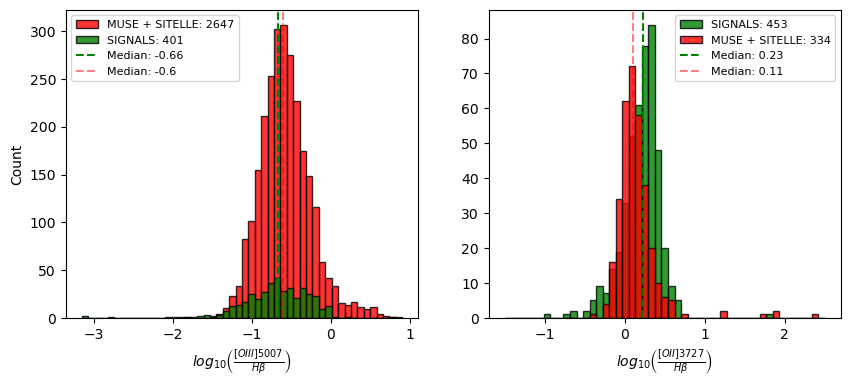

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First subplot (left)
a=np.random.random(100)*0.5 #a uniform distribution
b=1-np.random.normal(size=100)*0.1 #a normal distribution 
bins=np.histogram(np.hstack((sigoiiihb,logoiiihb)), bins=50)[1] #get the bin edges

axes[0].hist(logoiiihb, color='red', edgecolor='k', alpha = 0.8, bins=bins, label = f'MUSE + SITELLE: {len(logoiiihb)}');
axes[0].hist(sigoiiihb, color='green', edgecolor='k', alpha = 0.8, bins=bins, label = f'SIGNALS: {len(sigoiiihb)}');
axes[0].axvline(np.median(sigoiiihb), color='green', linestyle='--', label = f'Median: {round(np.median(sigoiiihb), 2)}')
axes[0].axvline(np.median(logoiiihb), color='red', alpha=0.5, linestyle='--', label = f'Median: {round(np.median(logoiiihb), 2)}')
axes[0].set_xlabel(r'$log_{10} \left(\frac{[OIII]5007}{H \beta} \right)$')
axes[0].set_ylabel("Count")
axes[0].legend(fontsize=8)

# Second subplot (right)
a=np.random.random(100)*0.5 #a uniform distribution
b=1-np.random.normal(size=100)*0.1 #a normal distribution 
bins=np.histogram(np.hstack((sigoiihb,logoiihb)), bins=50)[1] #get the bin edges

bins = np.linspace(-1.5, 2.5, 50)

axes[1].hist(sigoiihb, color='green', edgecolor='k', alpha = 0.8, bins=bins, label = f'SIGNALS: {len(sigoiihb)}');
axes[1].hist(logoiihb, color='red', edgecolor='k', alpha = 0.8, bins=bins, label = f'MUSE + SITELLE: {len(logoiihb)}');
axes[1].axvline(np.median(sigoiihb), color='green', linestyle='--', label = f'Median: {round(np.median(sigoiihb), 2)}')
axes[1].axvline(np.median(logoiihb), color='red', alpha=0.5, linestyle='--', label = f'Median: {round(np.median(logoiihb), 2)}')
axes[1].set_xlabel(r'$log_{10} \left(\frac{[OII]3727}{H \beta} \right)$')
axes[1].legend(fontsize=8)

# Comparison to v4 of the nebular catalog

In [62]:
infile = open(f"/home/habjan/SITELLE/data/data_raw_intermediate/Nebulae_catalogue_v4.fits",'rb')
neb_v4 = Table.read(infile)

### Compare [NII] temperatures

-488.54868832875377 1.0431519671333376 288.03561915196184 0.03686124848619715


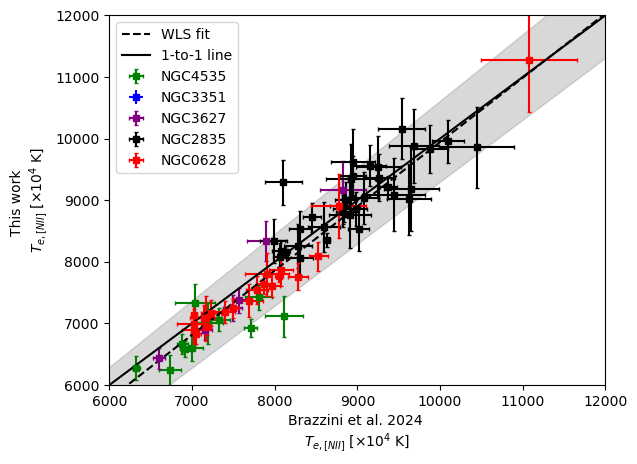

In [63]:
galaxies = np.array(['NGC4535', 'NGC3351', 'NGC3627', 'NGC2835', 'NGC0628'])
colors = np.array(['green', 'blue', 'purple', 'k', 'red'])

x, y, x_err, y_err = [], [], [], []

for i in range(len(galaxies)):
    
    v4_bool = neb_v4['gal_name'] == galaxies[i]
    st_bool = strong_data['gal_name'] == galaxies[i]

    nii_bool = ~np.isnan(np.array(neb_v4[v4_bool]['TEM_NII'])) & ~np.isnan(np.array(strong_data[st_bool]['NII_TEMP']))

    plt.errorbar(x = neb_v4[v4_bool]['TEM_NII'][nii_bool], y = strong_data[st_bool]['NII_TEMP'][nii_bool],
                 xerr = neb_v4[v4_bool]['TEM_NII_ERR'][nii_bool], yerr = strong_data[st_bool]['NII_TEMP_ERR'][nii_bool], 
                 markersize=5, fmt="s", capsize=1.5, alpha=1, label=galaxies[i], color=colors[i])
    
    x.append(np.array(neb_v4[v4_bool]['TEM_NII'][nii_bool]))
    y.append(np.array(strong_data[st_bool]['NII_TEMP'][nii_bool]))
    x_err.append(np.array(neb_v4[v4_bool]['TEM_NII_ERR'][nii_bool]))
    y_err.append(np.array(strong_data[st_bool]['NII_TEMP_ERR'][nii_bool]))

x = np.concatenate(x)
y = np.concatenate(y)
x_err = np.concatenate(x_err)
y_err = np.concatenate(y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)
print(fit_coef, fit_slope, fit_coef_err, fit_slope_err)

plt.plot(np.linspace(0, 5*10**4, 20), fit_coef + fit_slope*np.linspace(0, 5*10**4, 20), linestyle = '--', c='k', label='WLS fit')

plt.fill_between(np.linspace(0, 5*10**4, 20), 
                     (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(0, 5*10**4, 20), 
                     (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(0, 5*10**4, 20),
                     color='gray', alpha=0.3)

plt.plot(np.linspace(-10, 10**11, 10), np.linspace(-10, 10**11, 10), c='k', label='1-to-1 line')

plt.xlabel('Brazzini et al. 2024 \n'r'$T_{e, [NII]}$ $[\times 10^4$ K]')
plt.ylabel('This work \n' r'$T_{e, [NII]}$ $[\times 10^4$ K]')

lowb = 6000
upb = 12000
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
plt.legend()

### Compare [SIII] temperatures

432.29251269629094 0.925914439288881 384.1285767686579 0.04976112935215631


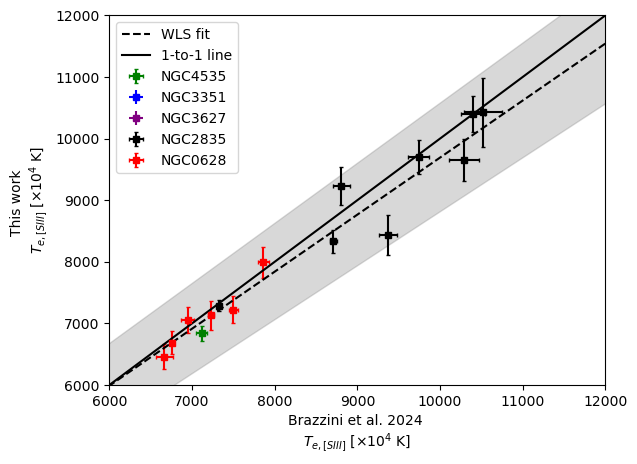

In [64]:
galaxies = np.array(['NGC4535', 'NGC3351', 'NGC3627', 'NGC2835', 'NGC0628'])
colors = np.array(['green', 'blue', 'purple', 'k', 'red'])

x, y, x_err, y_err = [], [], [], []

for i in range(len(galaxies)):
    
    v4_bool = neb_v4['gal_name'] == galaxies[i]
    st_bool = strong_data['gal_name'] == galaxies[i]

    SIII_bool = ~np.isnan(np.array(neb_v4[v4_bool]['TEM_SIII'])) & ~np.isnan(np.array(strong_data[st_bool]['SIII_TEMP']))

    plt.errorbar(x = neb_v4[v4_bool]['TEM_SIII'][SIII_bool], y = strong_data[st_bool]['SIII_TEMP'][SIII_bool],
                 xerr = neb_v4[v4_bool]['TEM_SIII_ERR'][SIII_bool], yerr = strong_data[st_bool]['SIII_TEMP_ERR'][SIII_bool], 
                 markersize=5, fmt="s", capsize=1.5, alpha=1, label=galaxies[i], color=colors[i])
    
    x.append(np.array(neb_v4[v4_bool]['TEM_SIII'][SIII_bool]))
    y.append(np.array(strong_data[st_bool]['SIII_TEMP'][SIII_bool]))
    x_err.append(np.array(neb_v4[v4_bool]['TEM_SIII_ERR'][SIII_bool]))
    y_err.append(np.array(strong_data[st_bool]['SIII_TEMP_ERR'][SIII_bool]))

x = np.concatenate(x)
y = np.concatenate(y)
x_err = np.concatenate(x_err)
y_err = np.concatenate(y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)
print(fit_coef, fit_slope, fit_coef_err, fit_slope_err)

plt.plot(np.linspace(0, 5*10**4, 20), fit_coef + fit_slope*np.linspace(0, 5*10**4, 20), linestyle = '--', c='k', label='WLS fit')

plt.fill_between(np.linspace(0, 5*10**4, 20), 
                     (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(0, 5*10**4, 20), 
                     (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(0, 5*10**4, 20),
                     color='gray', alpha=0.3)

plt.plot(np.linspace(-10, 10**11, 10), np.linspace(-10, 10**11, 10), c='k', label='1-to-1 line')

plt.xlabel('Brazzini et al. 2024 \n'r'$T_{e, [SIII]}$ $[\times 10^4$ K]')
plt.ylabel('This work \n' r'$T_{e, [SIII]}$ $[\times 10^4$ K]')

lowb = 6000
upb = 12000
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
plt.legend()

### Compare [OII]7320

70.56390985738247 1.005197848135445 121.73060325590325 0.01458722547778599


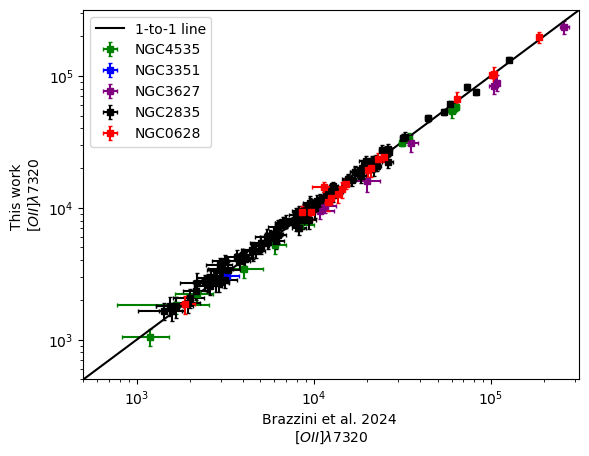

In [65]:
galaxies = np.array(['NGC4535', 'NGC3351', 'NGC3627', 'NGC2835', 'NGC0628'])
colors = np.array(['green', 'blue', 'purple', 'k', 'red'])

x, y, x_err, y_err = [], [], [], []

for i in range(len(galaxies)):
    
    v4_bool = neb_v4['gal_name'] == galaxies[i]
    st_bool = strong_data['gal_name'] == galaxies[i]

    SIII_bool = ~np.isnan(np.array(neb_v4[v4_bool]['OII7319_FLUX_CORR'])) & ~np.isnan(np.array(strong_data[st_bool]['OII7319_FLUX_CORR_REFIT'])) & ~np.isinf(np.array(neb_v4[v4_bool]['OII7319_FLUX_CORR'])) & ~np.isinf(np.array(strong_data[st_bool]['OII7319_FLUX_CORR_REFIT'])) & (np.array(neb_v4[v4_bool]['OII7319_FLUX_CORR']) > 0) & (np.array(strong_data[st_bool]['OII7319_FLUX_CORR_REFIT']) > 0)

    plt.errorbar(x = neb_v4[v4_bool]['OII7319_FLUX_CORR'][SIII_bool], y = strong_data[st_bool]['OII7319_FLUX_CORR_REFIT'][SIII_bool],
                 xerr = neb_v4[v4_bool]['OII7319_FLUX_CORR_ERR'][SIII_bool], yerr = strong_data[st_bool]['OII7319_FLUX_CORR_REFIT_ERR'][SIII_bool], 
                 markersize=5, fmt="s", capsize=1.5, alpha=1, label=galaxies[i], color=colors[i])
    
    x.append(np.array(neb_v4[v4_bool]['OII7319_FLUX_CORR'][SIII_bool]))
    y.append(np.array(strong_data[st_bool]['OII7319_FLUX_CORR_REFIT'][SIII_bool]))
    x_err.append(np.array(neb_v4[v4_bool]['OII7319_FLUX_CORR_ERR'][SIII_bool]))
    y_err.append(np.array(strong_data[st_bool]['OII7319_FLUX_CORR_REFIT_ERR'][SIII_bool]))

x = np.concatenate(x)
y = np.concatenate(y)
x_err = np.concatenate(x_err)
y_err = np.concatenate(y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)
print(fit_coef, fit_slope, fit_coef_err, fit_slope_err)

#plt.plot(np.linspace(0, 5*10**4, 20), fit_coef + fit_slope*np.linspace(0, 5*10**4, 20), linestyle = '--', c='k', label='WLS fit')

#plt.fill_between(np.linspace(0, 5*10**4, 20), (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(0, 5*10**4, 20), (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(0, 5*10**4, 20),color='gray', alpha=0.3)

plt.plot(np.linspace(-10, 10**11, 10), np.linspace(-10, 10**11, 10), c='k', label='1-to-1 line')

plt.xlabel('Brazzini et al. 2024 \n'r'$[OII] \lambda7320$')
plt.ylabel('This work \n' r'$[OII] \lambda7320$')

lowb = 500
upb = 10**5.5
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
plt.xscale('log')
plt.yscale('log')
plt.legend()

### Compare [OII]7330

2.4502774693597758 0.9352646620782517 175.08382898523888 0.017327497749689672


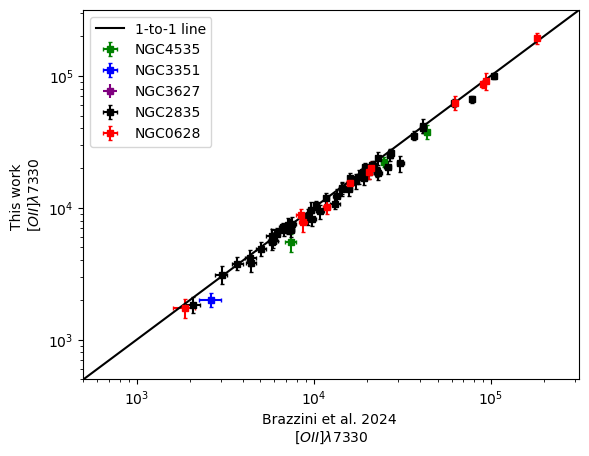

In [66]:
galaxies = np.array(['NGC4535', 'NGC3351', 'NGC3627', 'NGC2835', 'NGC0628'])
colors = np.array(['green', 'blue', 'purple', 'k', 'red'])

x, y, x_err, y_err = [], [], [], []

for i in range(len(galaxies)):
    
    v4_bool = neb_v4['gal_name'] == galaxies[i]
    st_bool = strong_data['gal_name'] == galaxies[i]

    SIII_bool = ~np.isnan(np.array(neb_v4[v4_bool]['OII7330_FLUX_CORR'])) & ~np.isnan(np.array(strong_data[st_bool]['OII7330_FLUX_CORR_REFIT'])) & ~np.isinf(np.array(neb_v4[v4_bool]['OII7330_FLUX_CORR'])) & ~np.isinf(np.array(strong_data[st_bool]['OII7330_FLUX_CORR_REFIT'])) & (np.array(neb_v4[v4_bool]['OII7330_FLUX_CORR']) > 0) & (np.array(strong_data[st_bool]['OII7330_FLUX_CORR_REFIT']) > 0)

    plt.errorbar(x = neb_v4[v4_bool]['OII7330_FLUX_CORR'][SIII_bool], y = strong_data[st_bool]['OII7330_FLUX_CORR_REFIT'][SIII_bool],
                 xerr = neb_v4[v4_bool]['OII7330_FLUX_CORR_ERR'][SIII_bool], yerr = strong_data[st_bool]['OII7330_FLUX_CORR_REFIT_ERR'][SIII_bool], 
                 markersize=5, fmt="s", capsize=1.5, alpha=1, label=galaxies[i], color=colors[i])
    
    x.append(np.array(neb_v4[v4_bool]['OII7330_FLUX_CORR'][SIII_bool]))
    y.append(np.array(strong_data[st_bool]['OII7330_FLUX_CORR_REFIT'][SIII_bool]))
    x_err.append(np.array(neb_v4[v4_bool]['OII7330_FLUX_CORR_ERR'][SIII_bool]))
    y_err.append(np.array(strong_data[st_bool]['OII7330_FLUX_CORR_REFIT_ERR'][SIII_bool]))

x = np.concatenate(x)
y = np.concatenate(y)
x_err = np.concatenate(x_err)
y_err = np.concatenate(y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)
print(fit_coef, fit_slope, fit_coef_err, fit_slope_err)

#plt.plot(np.linspace(0, 5*10**4, 20), fit_coef + fit_slope*np.linspace(0, 5*10**4, 20), linestyle = '--', c='k', label='WLS fit')

#plt.fill_between(np.linspace(0, 5*10**4, 20), (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(0, 5*10**4, 20), (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(0, 5*10**4, 20),color='gray', alpha=0.3)

plt.plot(np.linspace(-10, 10**11, 10), np.linspace(-10, 10**11, 10), c='k', label='1-to-1 line')

plt.xlabel('Brazzini et al. 2024 \n'r'$[OII] \lambda7330$')
plt.ylabel('This work \n' r'$[OII] \lambda7330$')

lowb = 500
upb = 10**5.5
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
plt.xscale('log')
plt.yscale('log')
plt.legend()

### Compare [NII]5755

1109.3008394054832 0.5333224725472819 47.08473068361209 0.007596226412568548


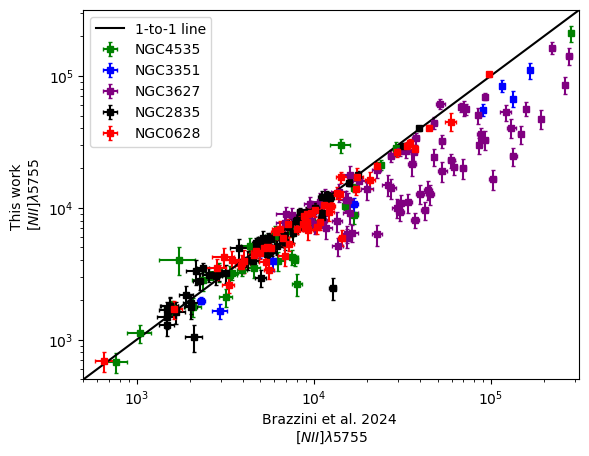

In [67]:
galaxies = np.array(['NGC4535', 'NGC3351', 'NGC3627', 'NGC2835', 'NGC0628'])
colors = np.array(['green', 'blue', 'purple', 'k', 'red'])

x, y, x_err, y_err = [], [], [], []

for i in range(len(galaxies)):
    
    v4_bool = neb_v4['gal_name'] == galaxies[i]
    st_bool = strong_data['gal_name'] == galaxies[i]

    SIII_bool = ~np.isnan(np.array(neb_v4[v4_bool]['NII5754_FLUX_CORR'])) & ~np.isnan(np.array(strong_data[st_bool]['NII5754_FLUX_CORR_REFIT'])) & ~np.isinf(np.array(neb_v4[v4_bool]['NII5754_FLUX_CORR'])) & ~np.isinf(np.array(strong_data[st_bool]['NII5754_FLUX_CORR_REFIT'])) & (np.array(neb_v4[v4_bool]['NII5754_FLUX_CORR']) > 0) & (np.array(strong_data[st_bool]['NII5754_FLUX_CORR_REFIT']) > 0)

    plt.errorbar(x = neb_v4[v4_bool]['NII5754_FLUX_CORR'][SIII_bool], y = strong_data[st_bool]['NII5754_FLUX_CORR_REFIT'][SIII_bool],
                 xerr = neb_v4[v4_bool]['NII5754_FLUX_CORR_ERR'][SIII_bool], yerr = strong_data[st_bool]['NII5754_FLUX_CORR_REFIT_ERR'][SIII_bool], 
                 markersize=5, fmt="s", capsize=1.5, alpha=1, label=galaxies[i], color=colors[i])
    
    x.append(np.array(neb_v4[v4_bool]['NII5754_FLUX_CORR'][SIII_bool]))
    y.append(np.array(strong_data[st_bool]['NII5754_FLUX_CORR_REFIT'][SIII_bool]))
    x_err.append(np.array(neb_v4[v4_bool]['NII5754_FLUX_CORR_ERR'][SIII_bool]))
    y_err.append(np.array(strong_data[st_bool]['NII5754_FLUX_CORR_REFIT_ERR'][SIII_bool]))

x = np.concatenate(x)
y = np.concatenate(y)
x_err = np.concatenate(x_err)
y_err = np.concatenate(y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)
print(fit_coef, fit_slope, fit_coef_err, fit_slope_err)

#plt.plot(np.linspace(0, 5*10**4, 20), fit_coef + fit_slope*np.linspace(0, 5*10**4, 20), linestyle = '--', c='k', label='WLS fit')

#plt.fill_between(np.linspace(0, 5*10**4, 20), (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(0, 5*10**4, 20), (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(0, 5*10**4, 20),color='gray', alpha=0.3)

plt.plot(np.linspace(-10, 10**11, 10), np.linspace(-10, 10**11, 10), c='k', label='1-to-1 line')

plt.xlabel('Brazzini et al. 2024 \n'r'$[NII] \lambda5755$')
plt.ylabel('This work \n' r'$[NII] \lambda5755$')

lowb = 500
upb = 10**5.5
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
plt.xscale('log')
plt.yscale('log')
plt.legend()

### Compare [SIII]6312

87.01156451333497 0.9244985432756735 149.35027345533743 0.01998433243461508


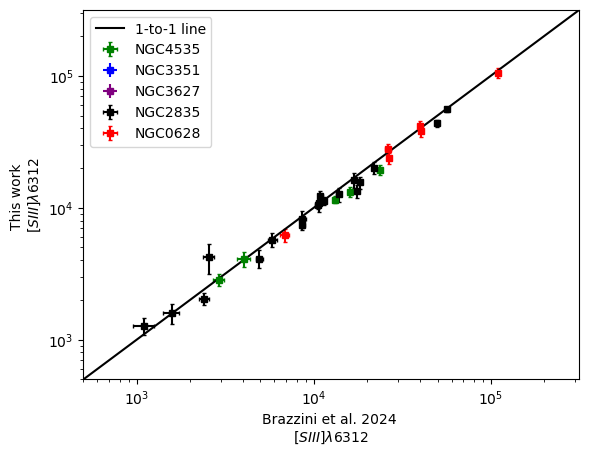

In [68]:
galaxies = np.array(['NGC4535', 'NGC3351', 'NGC3627', 'NGC2835', 'NGC0628'])
colors = np.array(['green', 'blue', 'purple', 'k', 'red'])

x, y, x_err, y_err = [], [], [], []

for i in range(len(galaxies)):
    
    v4_bool = neb_v4['gal_name'] == galaxies[i]
    st_bool = strong_data['gal_name'] == galaxies[i]

    SIII_bool = ~np.isnan(np.array(neb_v4[v4_bool]['SIII6312_FLUX_CORR'])) & ~np.isnan(np.array(strong_data[st_bool]['SIII6312_FLUX_CORR_REFIT'])) & ~np.isinf(np.array(neb_v4[v4_bool]['SIII6312_FLUX_CORR'])) & ~np.isinf(np.array(strong_data[st_bool]['SIII6312_FLUX_CORR_REFIT'])) & (np.array(neb_v4[v4_bool]['SIII6312_FLUX_CORR']) > 0) & (np.array(strong_data[st_bool]['SIII6312_FLUX_CORR_REFIT']) > 0)

    plt.errorbar(x = neb_v4[v4_bool]['SIII6312_FLUX_CORR'][SIII_bool], y = strong_data[st_bool]['SIII6312_FLUX_CORR_REFIT'][SIII_bool],
                 xerr = neb_v4[v4_bool]['SIII6312_FLUX_CORR_ERR'][SIII_bool], yerr = strong_data[st_bool]['SIII6312_FLUX_CORR_REFIT_ERR'][SIII_bool], 
                 markersize=5, fmt="s", capsize=1.5, alpha=1, label=galaxies[i], color=colors[i])
    
    x.append(np.array(neb_v4[v4_bool]['SIII6312_FLUX_CORR'][SIII_bool]))
    y.append(np.array(strong_data[st_bool]['SIII6312_FLUX_CORR_REFIT'][SIII_bool]))
    x_err.append(np.array(neb_v4[v4_bool]['SIII6312_FLUX_CORR_ERR'][SIII_bool]))
    y_err.append(np.array(strong_data[st_bool]['SIII6312_FLUX_CORR_REFIT_ERR'][SIII_bool]))

x = np.concatenate(x)
y = np.concatenate(y)
x_err = np.concatenate(x_err)
y_err = np.concatenate(y_err)

fit_coef, fit_slope, fit_coef_err, fit_slope_err = WLS_func(x, y, x_err, y_err)
print(fit_coef, fit_slope, fit_coef_err, fit_slope_err)

#plt.plot(np.linspace(0, 5*10**4, 20), fit_coef + fit_slope*np.linspace(0, 5*10**4, 20), linestyle = '--', c='k', label='WLS fit')

#plt.fill_between(np.linspace(0, 5*10**4, 20), (fit_coef - fit_coef_err) + (fit_slope - fit_slope_err)*np.linspace(0, 5*10**4, 20), (fit_coef + fit_coef_err) + (fit_slope + fit_slope_err)*np.linspace(0, 5*10**4, 20),color='gray', alpha=0.3)

plt.plot(np.linspace(-10, 10**11, 10), np.linspace(-10, 10**11, 10), c='k', label='1-to-1 line')

plt.xlabel('Brazzini et al. 2024 \n'r'$[SIII] \lambda6312$')
plt.ylabel('This work \n' r'$[SIII] \lambda6312$')

lowb = 500
upb = 10**5.5
plt.xlim(lowb, upb)
plt.ylim(lowb, upb)
plt.xscale('log')
plt.yscale('log')
plt.legend()